<a href="https://colab.research.google.com/github/SergeiVKalinin/ACerS_AE_2024/blob/main/14_DKL_BO_cards.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Kernel Learning for Cards (and Process Optimization, Molecules, ...)

- Made by Mani Valleti, https://scholar.google.com/citations?hl=en&user=Jt7c5d4AAAAJ
- Based on GPax library by Maxim Ziatdinov, https://scholar.google.com/citations?user=YnSdOoUAAAAJ&hl=en
- Adapted by Sergei V. Kalinin (2023), https://scholar.google.com/citations?hl=en&user=-cuxoSQAAAAJ

If you are interested in GP/BO for automated experiment, check GPax repository (https://github.com/ziatdinovmax/gpax) and add your stars!



In this notebook, we illustrate the principles of deep kernel learning (DKL) for applications such as process optimization, scientific discovery, or active experiment. As a model scenario, we use the discovery of the properties in card data set. Here, we have the collection of 4 type of images (diamonds, clubs, pikes, and hearts) that have been transformed via application of rotations, shear, and translations. We aim to learn functions f(image) -> suite and g(image) -> (rotation or shear) in an active manner.

This of course is a well-familiar problem for ML, if the data set is available in full. Then it f(image)->suite is a supervised classification problem, and g(image) -> (rotation or shear) is a regression problem.

However, here we attempt to explore these as an active learning problem. In this settings, the data (features) are available in full in the beginning of the experiment. However, the attributes (targets) are not - they become available only if we query data. This setting imitates experiment, where we choose which protocol to test, molecule to synthesize, or region of image to explore. Overall, we want to train our functions f(image) and g(image) in the shortest number of steps in an active manner, meaning that given all images and few targets, the algorith queries the image space for attributes sequentially.

While somewhat abstract as applied to cards, this problem has multiple real world applications. We can explore:
- image space in microscopy (local patches) to decide where to take detailed measurements
- molecular space  to decide which property to test (or calculate)
- processign space for optimization of manufacturing process
- charging trajectory of a battery to minimize charging time or maximize safety
- and so on.

In other words, card image is our multidimensional object, and hand or distortion is a function we want to discover via active learning. You can find more disucssion of this topic in:

https://arxiv.org/abs/2303.14554


In [1]:
!pip install kornia
!pip install -q --upgrade git+https://github.com/ziatdinovmax/gpax
!pip install -q atomai  # we will use the atomai's utility function for preparing the input data

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 65.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylin

In [2]:
import atomai as aoi
import kornia as K
import cv2
import torch
import torch.nn as nn
tt = torch.tensor
import numpy as np
import matplotlib.pyplot as plt

# Importing the packages
#import pyroved as pv
#import gpim

import gpax
import jax.numpy as jnp
gpax.utils.enable_x64()
import pickle

In [3]:
#@title Helper function and downloading the dataset
rs = lambda x: cv2.resize(x, (64, 64), cv2.INTER_CUBIC)

def get_data():
    card1 = rs(cv2.imread("cards/card1.JPG", cv2.IMREAD_GRAYSCALE))
    card2 = rs(cv2.imread("cards/card2.JPG", cv2.IMREAD_GRAYSCALE))
    card3 = rs(cv2.imread("cards/card3.JPG", cv2.IMREAD_GRAYSCALE))
    card4 = rs(cv2.imread("cards/card4.JPG", cv2.IMREAD_GRAYSCALE))
    card1 = tt(1 - card1 / card1.max())
    card2 = tt(1 - card2 / card2.max())
    card3 = tt(1 - card3 / card3.max())
    card4 = tt(1 - card4 / card4.max())
    return card1, card2, card3, card4


import math
def transform_imgs(cards, **kwargs):
    np.random.seed(0)
    torch.manual_seed(0)

    a = kwargs.get("angle")
    t = kwargs.get("translation")
    s = (kwargs.get("shear"))
    if s is not None:
        s = math.radians(s)


    n_samples = kwargs.get("samples", 3000)
    n_samples_total = n_samples*4

    card1 = K.geometry.transform.resize(cards[0], (45,45), interpolation='bilinear')
    card2 = K.geometry.transform.resize(cards[1], (45,45), interpolation='bilinear')
    card3 = K.geometry.transform.resize(cards[2], (45,45), interpolation='bilinear')
    card4 = K.geometry.transform.resize(cards[3], (45,45), interpolation='bilinear')

    card1 = card1[None, None].repeat_interleave(n_samples, dim = 0)
    card2 = card2[None, None].repeat_interleave(n_samples, dim = 0)
    card3 = card3[None, None].repeat_interleave(n_samples, dim = 0)
    card4 = card4[None, None].repeat_interleave(n_samples, dim = 0)

    cards_all = torch.cat((card1, card2, card3, card4), dim = 0)

    angles = tt(np.random.uniform(low = -a, high = a, size = [n_samples_total]))
    translations = tt(np.random.uniform(low = -t, high = t, size = [n_samples_total,1])).repeat_interleave(2, dim = 1)
    shears = tt(np.random.uniform(low = -s, high = s, size = [n_samples_total, 1])).repeat_interleave(2, dim = 1)

    transform = nn.Sequential(
        K.augmentation.CenterCrop((30, 30)),
        K.geometry.Affine(angle = angles, translation = translations,
                          shear = shears)
    )

    cards = transform(cards_all).squeeze().float()
    labels = torch.cat([torch.zeros(len(card1)), torch.ones(len(card2)),
                           2*torch.ones(len(card3)), 3*torch.ones(len(card4))])
    return cards, labels, angles, translations, shears


def plot_manifolds(model):
    fig, axes = plt.subplots(2, 2, figsize=(12, 12),
                            subplot_kw={'xticks':[], 'yticks':[]},
                            gridspec_kw=dict(hspace=0.1, wspace=0.05))
    for i, ax in enumerate(axes.flat):
        manifold = model.manifold2d(d=9, label=i, plot=False)
        grid = make_grid(manifold[:, None], nrow=9, pad_value=.5)
        ax.imshow(grid[0], cmap='viridis')
    plt.show()

In [4]:
# Downloading the cards dataset
!gdown -q https://drive.google.com/uc?id=1AyGHVflbIjzinkKBURHNVDx1wWg9JixB
!unzip -o -qq cards.zip

First, we create a data set of cards of different hands, varying in rotations, translations, and shear. Here, we draw 2000 data sets. You can play with a smaller number, but then VAEs should be trained longer. Furthermore, the behavior of the VAE, rVAE, and DKL will be very much affected by the distirbution parameters - feel free to experiment what will happen if the angle distribution is much narrower compared to translation/shear, if some factors are made very small, etc.

In [5]:
cards = get_data()

cards_all, labels_all, angles_all, translations_all, shears_all = transform_imgs(cards,
                                                                                angle = 120,
                                                                                translation = 0.1,
                                                                                shear = 20,
                                                                                samples = 2000)

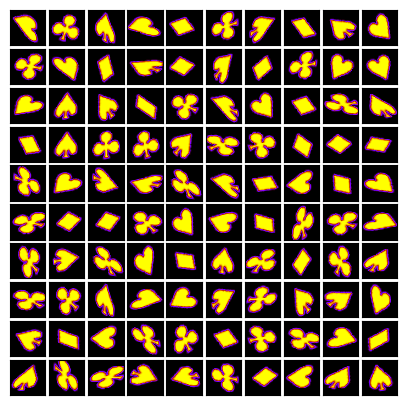

In [6]:
# Plotting random images
np.random.seed(1)  # fix seed so that we get the same samples displayed at every run
fig, axes = plt.subplots(10, 10, figsize=(5, 5),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax in axes.flat:
    i = np.random.randint(len(cards_all))
    ax.imshow(cards_all[i], cmap='gnuplot', interpolation='bilinear')

# VAE on the dataset

First we perform the VAE analysis on the cards data set. VAE analysis is always useful first step when working in the unsupervised or active learning problems, where the feature space is available in full and target space needs to be explored sequentially. Since here we have the access to the ground truth labels, it gives us some idea how the behaviors we can obtain from feature data only (latent representations and distributions) compare to the targets of interest.

If the ground truth data is available (meaning we have toy problem with known answers), visualization of the target fucntion behavior in the latent space allows to have a very good idea how useful the analysis may be on a real data (without the targets available)

In [7]:
# Running the model with atomai rvae
input_dim = (30,30)
vae = aoi.models.VAE(input_dim, latent_dim=2,
                    numlayers_encoder=3, numhidden_encoder=1024,
                    numlayers_decoder=3, numhidden_decoder=1024,
                    skip=True)

vae.fit(cards_all, training_cycles=200, batch_size=75, loss="ce",
         filename='vae')

Epoch: 1/200, Training loss: 286.3586
Epoch: 2/200, Training loss: 232.0131
Epoch: 3/200, Training loss: 224.6293
Epoch: 4/200, Training loss: 221.8112
Epoch: 5/200, Training loss: 217.4931
Epoch: 6/200, Training loss: 203.6777
Epoch: 7/200, Training loss: 197.3699
Epoch: 8/200, Training loss: 192.9998
Epoch: 9/200, Training loss: 188.8419
Epoch: 10/200, Training loss: 184.7000
Epoch: 11/200, Training loss: 181.3609
Epoch: 12/200, Training loss: 177.9529
Epoch: 13/200, Training loss: 175.3781
Epoch: 14/200, Training loss: 172.9029
Epoch: 15/200, Training loss: 170.3526
Epoch: 16/200, Training loss: 167.8119
Epoch: 17/200, Training loss: 166.6897
Epoch: 18/200, Training loss: 164.0650
Epoch: 19/200, Training loss: 162.6774
Epoch: 20/200, Training loss: 161.1855
Epoch: 21/200, Training loss: 160.0937
Epoch: 22/200, Training loss: 158.5190
Epoch: 23/200, Training loss: 157.4068
Epoch: 24/200, Training loss: 155.8610
Epoch: 25/200, Training loss: 154.6823
Epoch: 26/200, Training loss: 153.

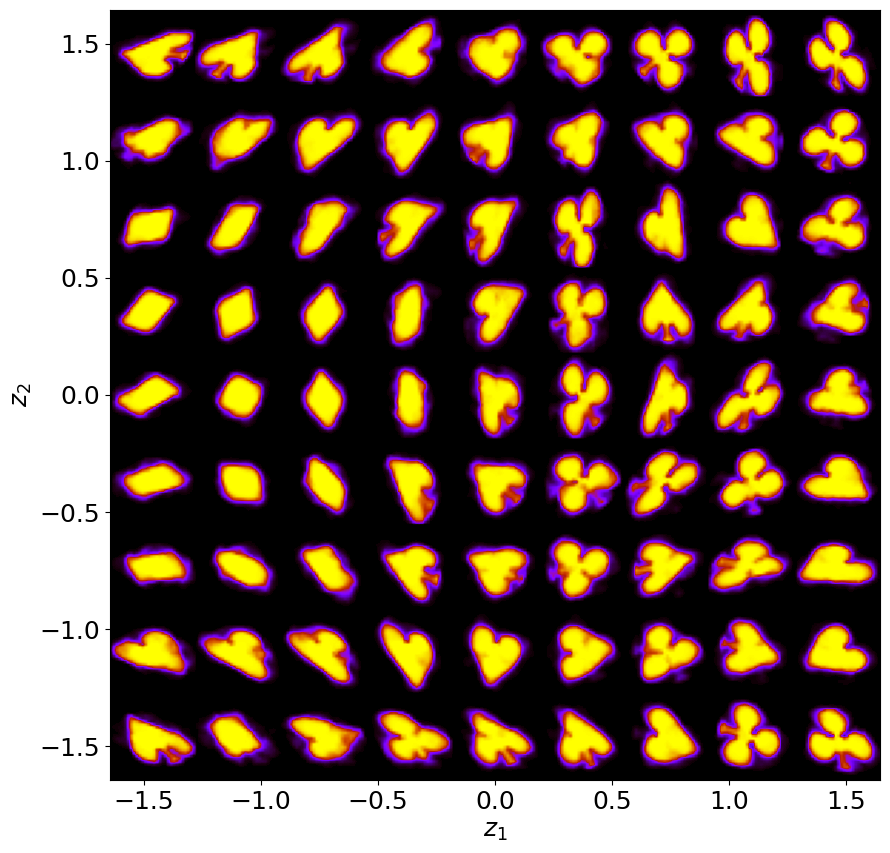

In [8]:
# Latent representation
vae.manifold2d(d = 9, origin = 'upper');

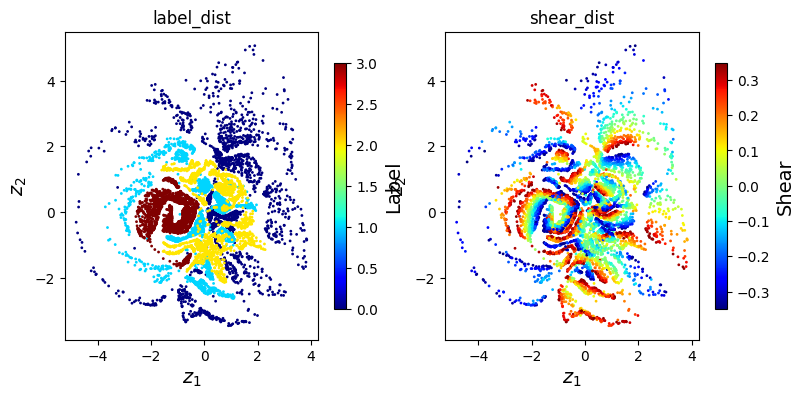

In [9]:
# Latent distributions

z_mean, z_sd = vae.encode(cards_all)
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (9,4))

im = ax[0].scatter(z_mean[:,-1], z_mean[:,-2], c=labels_all, s=1, cmap='jet')
ax[0].set_title('label_dist')
ax[0].set_xlabel("$z_1$", fontsize=14)
ax[0].set_ylabel("$z_2$", fontsize=14)
cbar = fig.colorbar(im, ax=ax[0], shrink=.8)
cbar.set_label("Label", fontsize=14)
cbar.ax.tick_params(labelsize=10)


im = ax[1].scatter(z_mean[:,-1], z_mean[:,-2], c=shears_all[:,0], s=1, cmap='jet')
ax[1].set_title('shear_dist')
ax[1].set_xlabel("$z_1$", fontsize=14)
ax[1].set_ylabel("$z_2$", fontsize=14)
cbar = fig.colorbar(im, ax=ax[1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)

Note here that the ground truth labels have very complex distribution in the latent space. This is because different factors of variability including the hand, rotation, and shear "compete" for latent space. The manifolds corresponding to different hands cannot mix (unless objects are identical) as driven by reconstruction loss, but at the same time KL loss tries to bring them together.  

Experiment with the variability of the data set - e.g. the distributions of the angles vs. shear. The manifolds will change!

# rVAE on the dataset

Now, let's check this supposition by running the rotationally invariant VAE, where the rotation is separated into a dedicated latent variable.

In [10]:
# Running the model with atomai rvae
input_dim = (30,30)
rvae = aoi.models.rVAE(input_dim, latent_dim=2,
                        numlayers_encoder=3, numhidden_encoder=1024,
                        numlayers_decoder=3, numhidden_decoder=1024,
                        skip=True)

rvae.fit(cards_all, training_cycles=100, batch_size=75, loss="ce", translation_prior=0.1,
         filename='rvae')

/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch: 1/100, Training loss: 317.7916
Epoch: 2/100, Training loss: 204.5009
Epoch: 3/100, Training loss: 200.4194
Epoch: 4/100, Training loss: 197.8084
Epoch: 5/100, Training loss: 187.6620
Epoch: 6/100, Training loss: 183.7376
Epoch: 7/100, Training loss: 179.7385
Epoch: 8/100, Training loss: 176.8512
Epoch: 9/100, Training loss: 172.7943
Epoch: 10/100, Training loss: 168.4212
Epoch: 11/100, Training loss: 164.5864
Epoch: 12/100, Training loss: 159.3120
Epoch: 13/100, Training loss: 154.2460
Epoch: 14/100, Training loss: 150.4021
Epoch: 15/100, Training loss: 146.4531
Epoch: 16/100, Training loss: 142.6362
Epoch: 17/100, Training loss: 139.1420
Epoch: 18/100, Training loss: 135.5054
Epoch: 19/100, Training loss: 134.4055
Epoch: 20/100, Training loss: 130.1389
Epoch: 21/100, Training loss: 127.7118
Epoch: 22/100, Training loss: 123.9572
Epoch: 23/100, Training loss: 122.8924
Epoch: 24/100, Training loss: 120.9602
Epoch: 25/100, Training loss: 120.0755
Epoch: 26/100, Training loss: 118.

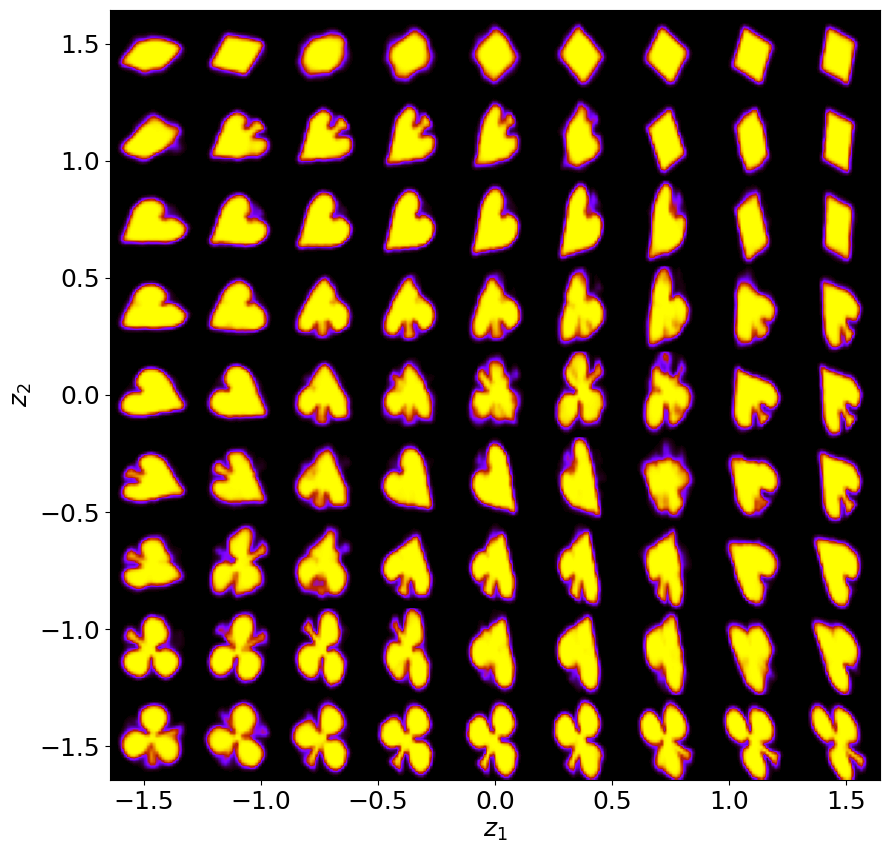

In [11]:
# Latent representation
rvae.manifold2d(d = 9, origin = 'upper');

Text(0, 0.5, 'actual')

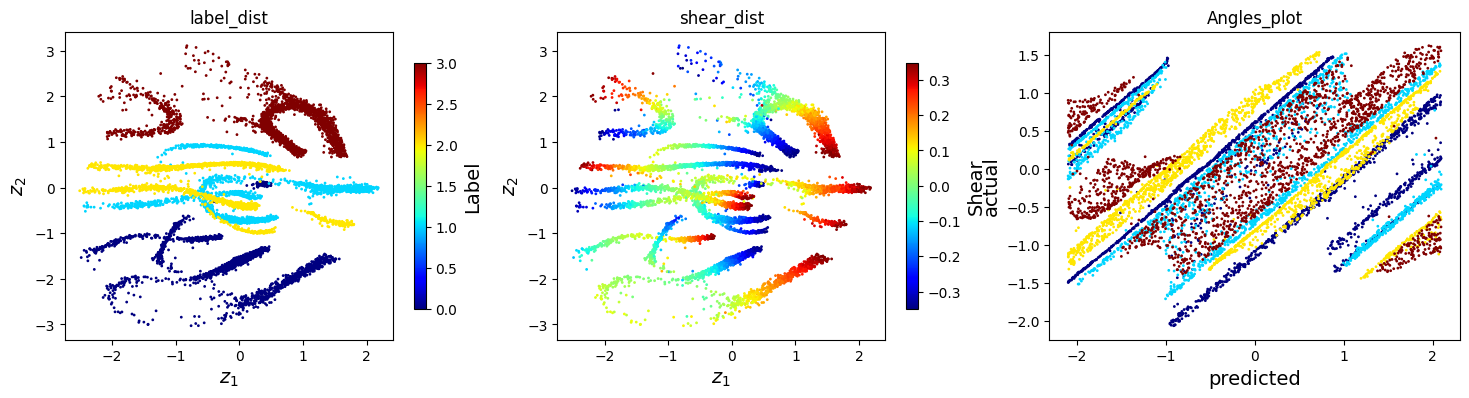

In [12]:
# Latent distributions
z_mean, z_sd = rvae.encode(cards_all)
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (18,4))

im = ax[0].scatter(z_mean[:,-1], z_mean[:,-2], c=labels_all, s=1, cmap='jet')
ax[0].set_title('label_dist')
ax[0].set_xlabel("$z_1$", fontsize=14)
ax[0].set_ylabel("$z_2$", fontsize=14)
cbar = fig.colorbar(im, ax=ax[0], shrink=.8)
cbar.set_label("Label", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1].scatter(z_mean[:,-1], z_mean[:,-2], c=shears_all[:,0], s=1, cmap='jet')
ax[1].set_title('shear_dist')
ax[1].set_xlabel("$z_1$", fontsize=14)
ax[1].set_ylabel("$z_2$", fontsize=14)
cbar = fig.colorbar(im, ax=ax[1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)

ax[2].scatter(torch.deg2rad(angles_all), z_mean[:,0], c = labels_all, s =1, cmap = 'jet')
ax[2].set_title('Angles_plot')
ax[2].set_xlabel("predicted", fontsize=14)
ax[2].set_ylabel("actual", fontsize=14)

In this case, we see well-defined manifolds for different hands, and the shear becomes a parameter that varies along the manifold. It is actually supercool - the VAE basically discovers factors of variability that we used in construction of the original data set (which it of course does not know - it's unsupervised method, and we have not used targets during analysis). This however is not perfect:
 - imaging that colors disappear - will you be able to cluster the data?
 - what about introducing some linear parameter changing across the manifold? Would it be shear?

 rVAE gives us some hints on what are the trends within the data set, but it does not tell us what they are explicitly. Its up to us to discover.

# DKL on cards dataset

Here we explore the DKL as an active learning method to explore the card set. We want to learn the function f(image) -> hand, or f(image) -> (rotation or shear) in th escenario where all images are available, but the function values are becoming available one by one. However, the algorithm can suggest which feature it wants to query (i.e. which experiment it wants to run). This a fairly abstract setting, but it matches a lot of practical process optimization problem (substitute image by the process trajectory, molecular graph, etc).

Again, we are running the DKL as an acrtive learning process - meaning that all the features are available (or equivalently our search space is defined), whereas targets are becoming available sequentially, meaning we are running (expensive) experiments.

We should also define several useful variables, namely, the number of initial samples (for active learning), number of exploration steps, batch size for active learning (should be smaller then number of initial samples, or code will not work), and batch size for reconstructions. Parenthetically, batch size can be variable (so we can increase it when samples are becoming available).

In [13]:
init_num = 20
exp_step = 100
batch_size_learn = 10 #make it 100 if start with 100 seed
batch_size_reconstruct = 250

Note that the number of the initial seeds (20) and exploration steps (100) is very small compared to the full data set (2000). We start with 1% of available data and explore only 5% of available space - and this is for th esystem with storng variability. The reason we are interested in this is because experimental budgets are usually very limited - each experiment costs us time and money.

If interested, you can experiment with the even smaller number of seed and exploration points. The DKL actually behaves remarcably well!

# Single card hand as a function

First, we run the experiment when we try to learn the hands in active manner. Meaning that we care about one specific hand (say clubs), do not care about other three hands, and do not care about the rotations and shear.

## Clubs

In [14]:
X = np.asarray(cards_all).reshape([-1, 900])

First we will run the DKL on the whole dataset. Here, we have (not terribly useful) situation when all features and all targets are available. So this is effectively supervised learning. The reason we are doing it first is to see how do the latent manfolds look like - and compare them to VAE. Rememebr that:
 - VAE build manifolds based on the features only
 - DKL on full data set builds manifolds based on features and targets
 - Active learning DKL build manifolds in such a way as to accelerate discovery process

In [15]:
X0 = np.copy(X)
targets0 = np.zeros(len(labels_all))
targets0[labels_all == 0] = 1

rng_key_0, rng_key_predict_0 = gpax.utils.get_keys()
dkl_0 = gpax.viDKL(900, 2, 'RBF')
dkl_0.fit(rng_key_0, X0, targets0)

100%|██████████| 1000/1000 [02:40<00:00,  6.22it/s, init loss: 69157.1100, avg. loss [951-1000]: 45804.6421]



Inferred GP kernel parameters
k_length         [2.5779 1.9904]
k_scale          0.2194
noise            0.008400000000000001


Now can visualize the DKL Latent space with the ground truth labels. Here, it is very instructive to compare it with the VAE latent space. Unsurprisingly, this latent space is much better separated - because we use both features and (all) known targets. The reason why DKL works for active learning is that this structure can be learned with much fewer examples.

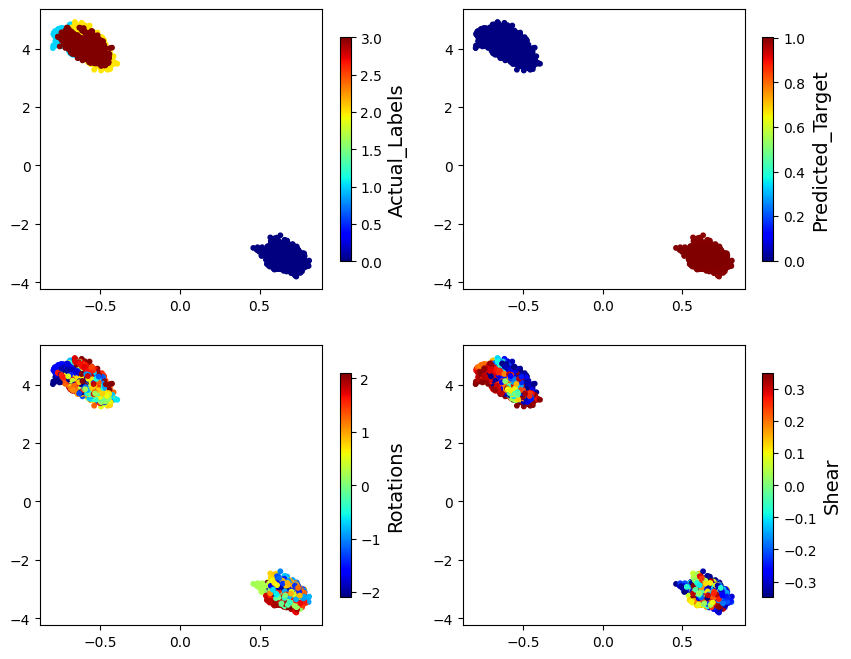

In [16]:
embeded_0 = dkl_0.embed(X0)
pred_mean0, pred_var0 = dkl_0.predict_in_batches(rng_key_predict_0, X0, batch_size=batch_size_reconstruct)
pred_std0 = jnp.sqrt(pred_var0)

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10,8))


im = ax[0,0].scatter(embeded_0[:, 1], embeded_0[:, 0], s=10, c = labels_all, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,0], shrink=.8)
cbar.set_label("Actual_Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,1].scatter(embeded_0[:, 1], embeded_0[:, 0], s=10, c = pred_mean0, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,1], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,0].scatter(embeded_0[:, 1], embeded_0[:, 0], s=10, c = torch.deg2rad(angles_all),
                     cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,0], shrink=.8)
cbar.set_label("Rotations", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,1].scatter(embeded_0[:, 1], embeded_0[:, 0], s=10, c = shears_all[:,0], cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)

For this example, you can see that:
- Latent manifold is effectively 1D (meaning only one factor of variability matters). Compare to VAE, where 2D is not enough
- The clubs form their own group (this is what we wanted to learn), and other hands are all lumped together (so manifold evolved to learn what we wanted to focus on)
- Other factors of variability are not separated very well (if you look at data carefully, there will be some alignment along the manifold)

Overall, we wanted to focus on a particular feature - and we did!

Now, let's run the DKL as an active learning problem. Can we learn this manifold with much fewer examples?
- We will use 20 seed points and 100 exploration points.
- As an aquisition function, we use the upper confidence bound, UCB, function defined as acq_func = mu + 10 * sigma, where mu is predicted value and sigma is uncertainty
- Look for the previous tutorial on Bayesian Optimization for at length discussion of these

In [17]:
np.random.seed(0)
idx0 = np.random.choice(np.arange(len(X0)), size = init_num, replace = False)
X0_train = X0[idx0]
X0_unmeasured = np.delete(X0, idx0, axis=0)

indices_total_0 = np.arange(len(X))
indices_train_0 = indices_total_0[idx0]
y0_train = targets0[idx0]
indices_unmeasured_0 = np.delete(indices_total_0, idx0)

In [18]:
exp_mean0, exp_std0 = [], []
dkl_mean0, dkl_std0 = [], []
embed_traj0 = []
traj_mean0, traj_std0 = [], []

exploration_steps = exp_step


for e in range(exploration_steps):
    print("\nStep {}".format(e+1))
    # Obtain/update DKL posterior
    rng_key10, rng_key_predict10 = gpax.utils.get_keys()
    dkl_BO_0 = gpax.viDKL(900, 2, 'RBF')
    dkl_BO_0.fit(rng_key10, X0_train, y0_train)
    # Compute acqusition function
    y_mean, y_var = dkl_BO_0.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        rng_key_predict10, X0_unmeasured, batch_size=250)
    y_std = jnp.sqrt(y_var)
    obj = y_mean + 10 * y_std  # UCB = mu + 10 * sigma
    # Get the next point to evaluate
    id_next = obj.argmax()

    # let's get the mean and std of the next point predicted by dkl_BO
    exp_mean0.append(y_mean[id_next])
    exp_std0.append(y_std[id_next])

    x_next = X0_unmeasured[id_next]
    ind_next = indices_unmeasured_0[id_next]

    # Getting the mean and std of the next point as predicted by the dkl trained on the full dataset
    dkl_mean0.append(pred_mean0[ind_next])
    dkl_std0.append(pred_std0[ind_next])

    # For now we will only read out the brute force results
    y_measured = targets0[ind_next]

    # Update training arrays
    X0_train = np.append(X0_train, x_next[None], axis=0)
    y0_train = np.append(y0_train, y_measured)
    X0_unmeasured = np.delete(X0_unmeasured, id_next, axis=0)
    indices_unmeasured_0 = np.delete(indices_unmeasured_0, id_next)

    embed_traj = dkl_BO_0.embed(X0_train)
    traj_m, traj_s = dkl_BO_0.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        rng_key_predict10, X0_train, batch_size=batch_size_learn)

    embed_traj0.append(embed_traj)
    traj_mean0.append(traj_m)


Step 1


100%|██████████| 1000/1000 [00:02<00:00, 393.88it/s, init loss: 60101.1336, avg. loss [951-1000]: 56922.7359]



Inferred GP kernel parameters
k_length         [0.3196 0.3678]
k_scale          0.4177
noise            0.013300000000000001

Step 2


100%|██████████| 1000/1000 [00:02<00:00, 386.55it/s, init loss: 60102.6393, avg. loss [951-1000]: 56921.5673]



Inferred GP kernel parameters
k_length         [0.3208 0.3679]
k_scale          0.4166
noise            0.0129

Step 3


100%|██████████| 1000/1000 [00:02<00:00, 390.18it/s, init loss: 60103.8836, avg. loss [951-1000]: 56922.8738]



Inferred GP kernel parameters
k_length         [0.3679 0.3498]
k_scale          0.376
noise            0.0126

Step 4


100%|██████████| 1000/1000 [00:02<00:00, 398.21it/s, init loss: 60105.3808, avg. loss [951-1000]: 56919.2050]



Inferred GP kernel parameters
k_length         [0.3515 0.3346]
k_scale          0.41190000000000004
noise            0.012100000000000001

Step 5


100%|██████████| 1000/1000 [00:02<00:00, 399.04it/s, init loss: 60106.8791, avg. loss [951-1000]: 56921.1543]



Inferred GP kernel parameters
k_length         [0.3679 0.3135]
k_scale          0.5205000000000001
noise            0.0119

Step 6


100%|██████████| 1000/1000 [00:02<00:00, 393.51it/s, init loss: 60108.1220, avg. loss [951-1000]: 56916.1550]



Inferred GP kernel parameters
k_length         [0.3679 0.3303]
k_scale          0.41250000000000003
noise            0.0111

Step 7


100%|██████████| 1000/1000 [00:02<00:00, 385.93it/s, init loss: 60109.5986, avg. loss [951-1000]: 56914.3390]



Inferred GP kernel parameters
k_length         [0.3678 0.3114]
k_scale          0.4194
noise            0.0108

Step 8


100%|██████████| 1000/1000 [00:02<00:00, 388.08it/s, init loss: 60111.1037, avg. loss [951-1000]: 57008.0777]



Inferred GP kernel parameters
k_length         [0.3272 0.1919]
k_scale          0.3793
noise            0.0201

Step 9


100%|██████████| 1000/1000 [00:02<00:00, 383.18it/s, init loss: 60112.3260, avg. loss [951-1000]: 56911.8004]



Inferred GP kernel parameters
k_length         [0.3679 0.3238]
k_scale          0.4157
noise            0.0106

Step 10


100%|██████████| 1000/1000 [00:02<00:00, 382.66it/s, init loss: 60113.8309, avg. loss [951-1000]: 56915.5538]



Inferred GP kernel parameters
k_length         [0.4369 0.4818]
k_scale          0.3608
noise            0.0115

Step 11


100%|██████████| 1000/1000 [00:02<00:00, 376.80it/s, init loss: 60115.2797, avg. loss [951-1000]: 56909.6028]



Inferred GP kernel parameters
k_length         [0.3679 0.3249]
k_scale          0.41190000000000004
noise            0.0105

Step 12


100%|██████████| 1000/1000 [00:02<00:00, 382.77it/s, init loss: 60116.7749, avg. loss [951-1000]: 56907.9704]



Inferred GP kernel parameters
k_length         [0.3344 0.3679]
k_scale          0.4046
noise            0.0099

Step 13


100%|██████████| 1000/1000 [00:02<00:00, 404.07it/s, init loss: 60118.2074, avg. loss [951-1000]: 56921.1963]



Inferred GP kernel parameters
k_length         [0.3679 0.3133]
k_scale          0.442
noise            0.0135

Step 14


100%|██████████| 1000/1000 [00:02<00:00, 418.22it/s, init loss: 60119.6544, avg. loss [951-1000]: 56905.6556]



Inferred GP kernel parameters
k_length         [0.3308 0.3679]
k_scale          0.39980000000000004
noise            0.010100000000000001

Step 15


100%|██████████| 1000/1000 [00:02<00:00, 417.24it/s, init loss: 60121.1535, avg. loss [951-1000]: 56903.7748]



Inferred GP kernel parameters
k_length         [0.3347 0.3679]
k_scale          0.3956
noise            0.0095

Step 16


100%|██████████| 1000/1000 [00:02<00:00, 415.05it/s, init loss: 60122.6586, avg. loss [951-1000]: 56902.9057]



Inferred GP kernel parameters
k_length         [0.3374 0.3679]
k_scale          0.38930000000000003
noise            0.0097

Step 17


100%|██████████| 1000/1000 [00:02<00:00, 416.87it/s, init loss: 60124.1633, avg. loss [951-1000]: 56900.2986]



Inferred GP kernel parameters
k_length         [0.3093 0.3679]
k_scale          0.4157
noise            0.009300000000000001

Step 18


100%|██████████| 1000/1000 [00:02<00:00, 409.93it/s, init loss: 60125.4031, avg. loss [951-1000]: 56899.3354]



Inferred GP kernel parameters
k_length         [0.3221 0.3679]
k_scale          0.39990000000000003
noise            0.0094

Step 19


100%|██████████| 1000/1000 [00:02<00:00, 408.88it/s, init loss: 60126.9043, avg. loss [951-1000]: 56897.7687]



Inferred GP kernel parameters
k_length         [0.3188 0.3658]
k_scale          0.4156
noise            0.009300000000000001

Step 20


100%|██████████| 1000/1000 [00:02<00:00, 400.99it/s, init loss: 60128.1472, avg. loss [951-1000]: 56896.6917]



Inferred GP kernel parameters
k_length         [0.3263 0.3679]
k_scale          0.3966
noise            0.0094

Step 21


100%|██████████| 1000/1000 [00:02<00:00, 417.02it/s, init loss: 60129.6259, avg. loss [951-1000]: 56894.9010]



Inferred GP kernel parameters
k_length         [0.3192 0.3679]
k_scale          0.39640000000000003
noise            0.0091

Step 22


100%|██████████| 1000/1000 [00:02<00:00, 399.99it/s, init loss: 60131.1311, avg. loss [951-1000]: 56894.0511]



Inferred GP kernel parameters
k_length         [0.3228 0.3679]
k_scale          0.3902
noise            0.0092

Step 23


100%|██████████| 1000/1000 [00:02<00:00, 409.97it/s, init loss: 60132.3743, avg. loss [951-1000]: 56896.3906]



Inferred GP kernel parameters
k_length         [0.3814 0.3754]
k_scale          0.3396
noise            0.009300000000000001

Step 24


100%|██████████| 1000/1000 [00:02<00:00, 411.57it/s, init loss: 60133.8794, avg. loss [951-1000]: 56890.7405]



Inferred GP kernel parameters
k_length         [0.305  0.3679]
k_scale          0.4186
noise            0.0091

Step 25


100%|██████████| 1000/1000 [00:02<00:00, 411.04it/s, init loss: 60135.1233, avg. loss [951-1000]: 56890.7396]



Inferred GP kernel parameters
k_length         [0.3575 0.3736]
k_scale          0.38620000000000004
noise            0.0091

Step 26


100%|██████████| 1000/1000 [00:02<00:00, 407.77it/s, init loss: 60136.6073, avg. loss [951-1000]: 56887.4890]



Inferred GP kernel parameters
k_length         [0.3301 0.3679]
k_scale          0.4161
noise            0.0089

Step 27


100%|██████████| 1000/1000 [00:02<00:00, 402.72it/s, init loss: 60138.0511, avg. loss [951-1000]: 56887.0574]



Inferred GP kernel parameters
k_length         [0.3213 0.3679]
k_scale          0.38980000000000004
noise            0.009000000000000001

Step 28


100%|██████████| 1000/1000 [00:02<00:00, 405.48it/s, init loss: 60139.1988, avg. loss [951-1000]: 56887.5211]



Inferred GP kernel parameters
k_length         [0.3481 0.3725]
k_scale          0.3789
noise            0.0092

Step 29


100%|██████████| 1000/1000 [00:02<00:00, 406.49it/s, init loss: 60140.5353, avg. loss [951-1000]: 56885.4159]



Inferred GP kernel parameters
k_length         [0.3302 0.3682]
k_scale          0.4015
noise            0.009000000000000001

Step 30


100%|██████████| 1000/1000 [00:02<00:00, 395.76it/s, init loss: 60141.7744, avg. loss [951-1000]: 56889.6810]



Inferred GP kernel parameters
k_length         [0.3626 0.3687]
k_scale          0.35550000000000004
noise            0.009000000000000001

Step 31


100%|██████████| 1000/1000 [00:02<00:00, 404.40it/s, init loss: 60143.1063, avg. loss [951-1000]: 56888.0302]



Inferred GP kernel parameters
k_length         [0.3408 0.3736]
k_scale          0.4264
noise            0.009300000000000001

Step 32


100%|██████████| 1000/1000 [00:02<00:00, 401.07it/s, init loss: 60144.4825, avg. loss [951-1000]: 56883.2045]



Inferred GP kernel parameters
k_length         [0.4338 0.4594]
k_scale          0.35750000000000004
noise            0.0092

Step 33


100%|██████████| 1000/1000 [00:02<00:00, 403.07it/s, init loss: 60145.6707, avg. loss [951-1000]: 56879.0037]



Inferred GP kernel parameters
k_length         [0.3814 0.3894]
k_scale          0.3829
noise            0.0088

Step 34


100%|██████████| 1000/1000 [00:02<00:00, 388.46it/s, init loss: 60147.1758, avg. loss [951-1000]: 56875.9267]



Inferred GP kernel parameters
k_length         [0.3303 0.3679]
k_scale          0.4168
noise            0.0086

Step 35


100%|██████████| 1000/1000 [00:02<00:00, 412.70it/s, init loss: 60148.6074, avg. loss [951-1000]: 56879.1089]



Inferred GP kernel parameters
k_length         [0.3671 0.3814]
k_scale          0.37
noise            0.0091

Step 36


100%|██████████| 1000/1000 [00:02<00:00, 410.51it/s, init loss: 60149.8408, avg. loss [951-1000]: 56873.9107]



Inferred GP kernel parameters
k_length         [0.34   0.3675]
k_scale          0.4239
noise            0.0089

Step 37


100%|██████████| 1000/1000 [00:02<00:00, 405.02it/s, init loss: 60151.3406, avg. loss [951-1000]: 56891.1648]



Inferred GP kernel parameters
k_length         [0.4348 0.5188]
k_scale          0.2998
noise            0.0092

Step 38


100%|██████████| 1000/1000 [00:02<00:00, 397.46it/s, init loss: 60152.8435, avg. loss [951-1000]: 56872.0967]



Inferred GP kernel parameters
k_length         [0.32   0.3679]
k_scale          0.4171
noise            0.008700000000000001

Step 39


100%|██████████| 1000/1000 [00:02<00:00, 393.36it/s, init loss: 60154.0099, avg. loss [951-1000]: 56871.9234]



Inferred GP kernel parameters
k_length         [0.3533 0.3682]
k_scale          0.3861
noise            0.0086

Step 40


100%|██████████| 1000/1000 [00:02<00:00, 406.78it/s, init loss: 60155.4807, avg. loss [951-1000]: 56869.0942]



Inferred GP kernel parameters
k_length         [0.343  0.3616]
k_scale          0.38630000000000003
noise            0.008700000000000001

Step 41


100%|██████████| 1000/1000 [00:02<00:00, 402.95it/s, init loss: 60156.8153, avg. loss [951-1000]: 56869.3955]



Inferred GP kernel parameters
k_length         [0.3613 0.3823]
k_scale          0.3771
noise            0.0089

Step 42


100%|██████████| 1000/1000 [00:02<00:00, 413.46it/s, init loss: 60158.3081, avg. loss [951-1000]: 56872.0106]



Inferred GP kernel parameters
k_length         [0.3418 0.3701]
k_scale          0.32530000000000003
noise            0.008700000000000001

Step 43


100%|██████████| 1000/1000 [00:02<00:00, 391.93it/s, init loss: 60159.5523, avg. loss [951-1000]: 56871.4793]



Inferred GP kernel parameters
k_length         [0.344  0.3727]
k_scale          0.321
noise            0.008700000000000001

Step 44


100%|██████████| 1000/1000 [00:02<00:00, 383.27it/s, init loss: 60161.0574, avg. loss [951-1000]: 56867.9532]



Inferred GP kernel parameters
k_length         [0.3447 0.3653]
k_scale          0.4944
noise            0.0088

Step 45


100%|██████████| 1000/1000 [00:02<00:00, 396.41it/s, init loss: 60162.5291, avg. loss [951-1000]: 56860.8664]



Inferred GP kernel parameters
k_length         [0.3524 0.3723]
k_scale          0.41390000000000005
noise            0.0086

Step 46


100%|██████████| 1000/1000 [00:02<00:00, 407.92it/s, init loss: 60163.9856, avg. loss [951-1000]: 56868.7239]



Inferred GP kernel parameters
k_length         [0.3283 0.3811]
k_scale          0.3942
noise            0.0088

Step 47


100%|██████████| 1000/1000 [00:02<00:00, 415.03it/s, init loss: 60165.4769, avg. loss [951-1000]: 56864.6632]



Inferred GP kernel parameters
k_length         [0.3546 0.3762]
k_scale          0.3123
noise            0.008700000000000001

Step 48


100%|██████████| 1000/1000 [00:02<00:00, 413.75it/s, init loss: 60166.7212, avg. loss [951-1000]: 56859.2916]



Inferred GP kernel parameters
k_length         [0.3721 0.3606]
k_scale          0.3674
noise            0.008700000000000001

Step 49


100%|██████████| 1000/1000 [00:02<00:00, 412.35it/s, init loss: 60168.1228, avg. loss [951-1000]: 56855.7121]



Inferred GP kernel parameters
k_length         [0.3327 0.3682]
k_scale          0.4102
noise            0.0086

Step 50


100%|██████████| 1000/1000 [00:02<00:00, 410.54it/s, init loss: 60169.5871, avg. loss [951-1000]: 56867.0324]



Inferred GP kernel parameters
k_length         [0.3778 0.3879]
k_scale          0.3154
noise            0.009300000000000001

Step 51


100%|██████████| 1000/1000 [00:02<00:00, 410.95it/s, init loss: 60170.9739, avg. loss [951-1000]: 56853.1258]



Inferred GP kernel parameters
k_length         [0.3693 0.3969]
k_scale          0.375
noise            0.008400000000000001

Step 52


100%|██████████| 1000/1000 [00:02<00:00, 404.45it/s, init loss: 60172.4790, avg. loss [951-1000]: 56852.3124]



Inferred GP kernel parameters
k_length         [0.3811 0.3774]
k_scale          0.4025
noise            0.008700000000000001

Step 53


100%|██████████| 1000/1000 [00:02<00:00, 414.14it/s, init loss: 60173.8344, avg. loss [951-1000]: 56852.2892]



Inferred GP kernel parameters
k_length         [0.4123 0.428 ]
k_scale          0.3739
noise            0.0088

Step 54


100%|██████████| 1000/1000 [00:02<00:00, 401.20it/s, init loss: 60175.0786, avg. loss [951-1000]: 56851.0612]



Inferred GP kernel parameters
k_length         [0.3923 0.4063]
k_scale          0.3902
noise            0.008700000000000001

Step 55


100%|██████████| 1000/1000 [00:02<00:00, 411.95it/s, init loss: 60176.5835, avg. loss [951-1000]: 56853.2322]



Inferred GP kernel parameters
k_length         [0.4269 0.4461]
k_scale          0.38920000000000005
noise            0.009300000000000001

Step 56


100%|██████████| 1000/1000 [00:02<00:00, 408.12it/s, init loss: 60178.0647, avg. loss [951-1000]: 56848.4963]



Inferred GP kernel parameters
k_length         [0.5245 0.5656]
k_scale          0.3275
noise            0.008700000000000001

Step 57


100%|██████████| 1000/1000 [00:02<00:00, 411.68it/s, init loss: 60179.3770, avg. loss [951-1000]: 56878.8482]



Inferred GP kernel parameters
k_length         [0.3673 0.5134]
k_scale          0.3189
noise            0.0088

Step 58


100%|██████████| 1000/1000 [00:02<00:00, 409.93it/s, init loss: 60180.5976, avg. loss [951-1000]: 56857.4253]



Inferred GP kernel parameters
k_length         [0.3254 0.4168]
k_scale          0.3194
noise            0.0088

Step 59


100%|██████████| 1000/1000 [00:02<00:00, 403.99it/s, init loss: 60182.1027, avg. loss [951-1000]: 56840.4575]



Inferred GP kernel parameters
k_length         [0.3336 0.3686]
k_scale          0.3975
noise            0.0081

Step 60


100%|██████████| 1000/1000 [00:02<00:00, 406.16it/s, init loss: 60183.5402, avg. loss [951-1000]: 56838.4608]



Inferred GP kernel parameters
k_length         [0.3554 0.3546]
k_scale          0.42000000000000004
noise            0.0081

Step 61


100%|██████████| 1000/1000 [00:02<00:00, 410.03it/s, init loss: 60184.8551, avg. loss [951-1000]: 56837.0899]



Inferred GP kernel parameters
k_length         [0.3363 0.3687]
k_scale          0.4156
noise            0.0082

Step 62


100%|██████████| 1000/1000 [00:02<00:00, 415.74it/s, init loss: 60186.3602, avg. loss [951-1000]: 56849.1826]



Inferred GP kernel parameters
k_length         [0.4832 0.5834]
k_scale          0.2938
noise            0.0092

Step 63


100%|██████████| 1000/1000 [00:02<00:00, 407.73it/s, init loss: 60187.8565, avg. loss [951-1000]: 56834.4262]



Inferred GP kernel parameters
k_length         [0.3304 0.3689]
k_scale          0.41850000000000004
noise            0.0081

Step 64


100%|██████████| 1000/1000 [00:02<00:00, 409.80it/s, init loss: 60189.3437, avg. loss [951-1000]: 56844.9765]



Inferred GP kernel parameters
k_length         [0.3722 0.3574]
k_scale          0.3103
noise            0.0085

Step 65


100%|██████████| 1000/1000 [00:02<00:00, 404.55it/s, init loss: 60190.5893, avg. loss [951-1000]: 56833.0284]



Inferred GP kernel parameters
k_length         [0.3562 0.3614]
k_scale          0.4108
noise            0.008400000000000001

Step 66


100%|██████████| 1000/1000 [00:02<00:00, 414.96it/s, init loss: 60192.0933, avg. loss [951-1000]: 56834.6262]



Inferred GP kernel parameters
k_length         [0.3916 0.4217]
k_scale          0.34550000000000003
noise            0.0086

Step 67


100%|██████████| 1000/1000 [00:02<00:00, 415.48it/s, init loss: 60193.5958, avg. loss [951-1000]: 56835.7417]



Inferred GP kernel parameters
k_length         [0.4218 0.4196]
k_scale          0.3302
noise            0.008700000000000001

Step 68


100%|██████████| 1000/1000 [00:02<00:00, 407.59it/s, init loss: 60195.0875, avg. loss [951-1000]: 56828.0775]



Inferred GP kernel parameters
k_length         [0.3816 0.365 ]
k_scale          0.4123
noise            0.0082

Step 69


100%|██████████| 1000/1000 [00:02<00:00, 414.98it/s, init loss: 60196.5346, avg. loss [951-1000]: 56826.9452]



Inferred GP kernel parameters
k_length         [0.3838 0.4108]
k_scale          0.3689
noise            0.0083

Step 70


100%|██████████| 1000/1000 [00:02<00:00, 405.89it/s, init loss: 60197.8885, avg. loss [951-1000]: 56839.3367]



Inferred GP kernel parameters
k_length         [0.5681 0.4541]
k_scale          0.2942
noise            0.0086

Step 71


100%|██████████| 1000/1000 [00:02<00:00, 402.15it/s, init loss: 60199.1252, avg. loss [951-1000]: 56831.9321]



Inferred GP kernel parameters
k_length         [0.3962 0.3798]
k_scale          0.30720000000000003
noise            0.0086

Step 72


100%|██████████| 1000/1000 [00:02<00:00, 404.93it/s, init loss: 60200.4568, avg. loss [951-1000]: 56821.9757]



Inferred GP kernel parameters
k_length         [0.3659 0.3456]
k_scale          0.4177
noise            0.0081

Step 73


100%|██████████| 1000/1000 [00:02<00:00, 411.57it/s, init loss: 60201.9625, avg. loss [951-1000]: 56828.8842]



Inferred GP kernel parameters
k_length         [0.3977 0.3953]
k_scale          0.36050000000000004
noise            0.0088

Step 74


100%|██████████| 1000/1000 [00:02<00:00, 408.34it/s, init loss: 60203.4560, avg. loss [951-1000]: 56844.9543]



Inferred GP kernel parameters
k_length         [0.4262 0.3758]
k_scale          0.3357
noise            0.0083

Step 75


100%|██████████| 1000/1000 [00:02<00:00, 409.36it/s, init loss: 60204.8026, avg. loss [951-1000]: 56817.9939]



Inferred GP kernel parameters
k_length         [0.3715 0.3388]
k_scale          0.40640000000000004
noise            0.008

Step 76


100%|██████████| 1000/1000 [00:02<00:00, 410.35it/s, init loss: 60206.1481, avg. loss [951-1000]: 56818.1774]



Inferred GP kernel parameters
k_length         [0.3767 0.3845]
k_scale          0.3607
noise            0.0082

Step 77


100%|██████████| 1000/1000 [00:02<00:00, 405.03it/s, init loss: 60207.5739, avg. loss [951-1000]: 56813.9520]



Inferred GP kernel parameters
k_length         [0.3368 0.3628]
k_scale          0.4122
noise            0.0079

Step 78


100%|██████████| 1000/1000 [00:02<00:00, 401.73it/s, init loss: 60208.9660, avg. loss [951-1000]: 56847.9800]



Inferred GP kernel parameters
k_length         [0.451  0.3773]
k_scale          0.3094
noise            0.0085

Step 79


100%|██████████| 1000/1000 [00:02<00:00, 408.38it/s, init loss: 60210.1987, avg. loss [951-1000]: 56812.1268]



Inferred GP kernel parameters
k_length         [0.4058 0.3936]
k_scale          0.3917
noise            0.0081

Step 80


100%|██████████| 1000/1000 [00:02<00:00, 404.25it/s, init loss: 60211.6326, avg. loss [951-1000]: 56809.8571]



Inferred GP kernel parameters
k_length         [0.3669 0.3739]
k_scale          0.4172
noise            0.008

Step 81


100%|██████████| 1000/1000 [00:02<00:00, 405.88it/s, init loss: 60213.0691, avg. loss [951-1000]: 56808.0056]



Inferred GP kernel parameters
k_length         [0.3339 0.3712]
k_scale          0.4158
noise            0.0077

Step 82


100%|██████████| 1000/1000 [00:02<00:00, 395.38it/s, init loss: 60214.5741, avg. loss [951-1000]: 56825.9760]



Inferred GP kernel parameters
k_length         [0.3741 0.3814]
k_scale          0.3694
noise            0.0082

Step 83


100%|██████████| 1000/1000 [00:02<00:00, 408.41it/s, init loss: 60215.8437, avg. loss [951-1000]: 56850.3564]



Inferred GP kernel parameters
k_length         [0.3807 0.3666]
k_scale          0.3547
noise            0.015000000000000001

Step 84


100%|██████████| 1000/1000 [00:02<00:00, 394.72it/s, init loss: 60216.9941, avg. loss [951-1000]: 56811.6279]



Inferred GP kernel parameters
k_length         [0.5382 0.4403]
k_scale          0.3146
noise            0.0085

Step 85


100%|██████████| 1000/1000 [00:02<00:00, 405.38it/s, init loss: 60218.4992, avg. loss [951-1000]: 56803.7501]



Inferred GP kernel parameters
k_length         [0.3381 0.3744]
k_scale          0.4011
noise            0.008

Step 86


100%|██████████| 1000/1000 [00:02<00:00, 405.93it/s, init loss: 60220.0019, avg. loss [951-1000]: 56803.0126]



Inferred GP kernel parameters
k_length         [0.354  0.3858]
k_scale          0.4157
noise            0.0083

Step 87


100%|██████████| 1000/1000 [00:02<00:00, 397.73it/s, init loss: 60221.3816, avg. loss [951-1000]: 56808.2174]



Inferred GP kernel parameters
k_length         [0.3773 0.3963]
k_scale          0.3044
noise            0.008400000000000001

Step 88


100%|██████████| 1000/1000 [00:02<00:00, 399.61it/s, init loss: 60222.8769, avg. loss [951-1000]: 56807.8991]



Inferred GP kernel parameters
k_length         [0.387  0.4175]
k_scale          0.313
noise            0.008400000000000001

Step 89


100%|██████████| 1000/1000 [00:02<00:00, 401.56it/s, init loss: 60224.3820, avg. loss [951-1000]: 56797.5869]



Inferred GP kernel parameters
k_length         [0.3445 0.3736]
k_scale          0.4217
noise            0.0081

Step 90


100%|██████████| 1000/1000 [00:02<00:00, 411.58it/s, init loss: 60225.8376, avg. loss [951-1000]: 56797.6228]



Inferred GP kernel parameters
k_length         [0.397  0.3705]
k_scale          0.3556
noise            0.0081

Step 91


100%|██████████| 1000/1000 [00:02<00:00, 401.31it/s, init loss: 60227.0818, avg. loss [951-1000]: 56802.6393]



Inferred GP kernel parameters
k_length         [0.5245 0.4487]
k_scale          0.2859
noise            0.0083

Step 92


100%|██████████| 1000/1000 [00:02<00:00, 408.99it/s, init loss: 60228.2732, avg. loss [951-1000]: 56795.6342]



Inferred GP kernel parameters
k_length         [0.3487 0.3774]
k_scale          0.33290000000000003
noise            0.0081

Step 93


100%|██████████| 1000/1000 [00:02<00:00, 400.34it/s, init loss: 60229.7588, avg. loss [951-1000]: 56812.9856]



Inferred GP kernel parameters
k_length         [0.4705 0.4508]
k_scale          0.2938
noise            0.0082

Step 94


100%|██████████| 1000/1000 [00:02<00:00, 392.97it/s, init loss: 60231.0498, avg. loss [951-1000]: 56792.0317]



Inferred GP kernel parameters
k_length         [0.3981 0.3945]
k_scale          0.4091
noise            0.0083

Step 95


100%|██████████| 1000/1000 [00:02<00:00, 404.28it/s, init loss: 60232.3475, avg. loss [951-1000]: 56788.2201]



Inferred GP kernel parameters
k_length         [0.3398 0.3764]
k_scale          0.4141
noise            0.0079

Step 96


100%|██████████| 1000/1000 [00:02<00:00, 408.29it/s, init loss: 60233.6538, avg. loss [951-1000]: 56787.2297]



Inferred GP kernel parameters
k_length         [0.3437 0.3711]
k_scale          0.4174
noise            0.008

Step 97


100%|██████████| 1000/1000 [00:02<00:00, 408.35it/s, init loss: 60235.0671, avg. loss [951-1000]: 56786.7886]



Inferred GP kernel parameters
k_length         [0.3631 0.3771]
k_scale          0.4068
noise            0.0079

Step 98


100%|██████████| 1000/1000 [00:02<00:00, 404.93it/s, init loss: 60236.5720, avg. loss [951-1000]: 56784.3180]



Inferred GP kernel parameters
k_length         [0.3393 0.3763]
k_scale          0.42160000000000003
noise            0.008

Step 99


100%|██████████| 1000/1000 [00:02<00:00, 401.08it/s, init loss: 60238.0074, avg. loss [951-1000]: 56795.8572]



Inferred GP kernel parameters
k_length         [0.7202 0.5033]
k_scale          0.25120000000000003
noise            0.0085

Step 100


100%|██████████| 1000/1000 [00:02<00:00, 395.32it/s, init loss: 60239.2246, avg. loss [951-1000]: 56782.6031]



Inferred GP kernel parameters
k_length         [0.3763 0.4068]
k_scale          0.40990000000000004
noise            0.0081


In [19]:
# Saving the results
clubs_results = {}
clubs_results['X_train'] = X0_train
clubs_results['y_train'] = y0_train
clubs_results['X_unmeasured'] = X0_unmeasured
clubs_results['indices_unmeasured'] = indices_unmeasured_0
clubs_results['dkl_mean'] = dkl_mean0
clubs_results['dkl_std'] = dkl_std0
clubs_results['exp_mean'] = exp_mean0
clubs_results['exp_std'] = exp_std0
clubs_results['traj_mean'] = traj_mean0
clubs_results['traj_std'] = traj_std0
clubs_results['embed_traj'] = embed_traj0

with open('clubs_results.pickle', 'wb') as handle:
    pickle.dump(clubs_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [20]:
# Loading the results
with open('clubs_results.pickle', 'rb') as f:
    clubs_results = pickle.load(f)

X0_train = clubs_results['X_train']
y0_train = clubs_results['y_train']
X0_unmeasured = clubs_results['X_unmeasured']
indices_unmeasured_0 = clubs_results['indices_unmeasured']
dkl_mean0 = clubs_results['dkl_mean']
dkl_std0 = clubs_results['dkl_std']
exp_mean0 = clubs_results['exp_mean']
exp_std0 = clubs_results['exp_std']
traj_mean0 = clubs_results['traj_mean']
traj_std0 = clubs_results['traj_std']
embed_traj0 = clubs_results['embed_traj']

In [21]:
rng_key10, rng_key_predict10 = gpax.utils.get_keys()
dkl_BO_0 = gpax.viDKL(900, 2, 'RBF')
dkl_BO_0.fit(rng_key10, X0_train, y0_train)

predmean_train0, predstd_train0 = dkl_BO_0.predict_in_batches(rng_key_predict10, X0_train, batch_size = batch_size_learn)
predmean_unmeas0, predstd_unmeas0 = dkl_BO_0.predict_in_batches(rng_key_predict10, X0_unmeasured, batch_size = batch_size_reconstruct)
predmean10, predstd10 = dkl_BO_0.predict_in_batches(rng_key_predict10, X0, batch_size = batch_size_reconstruct)

100%|██████████| 1000/1000 [00:02<00:00, 403.02it/s, init loss: 60240.7248, avg. loss [951-1000]: 56801.7828]



Inferred GP kernel parameters
k_length         [0.3555 0.3807]
k_scale          0.4116
noise            0.0082


The first row corresponds to explored, unexplored, and all datapoints colored using the predicted target property  
Second row is the latent space distributions colored with various ground truths

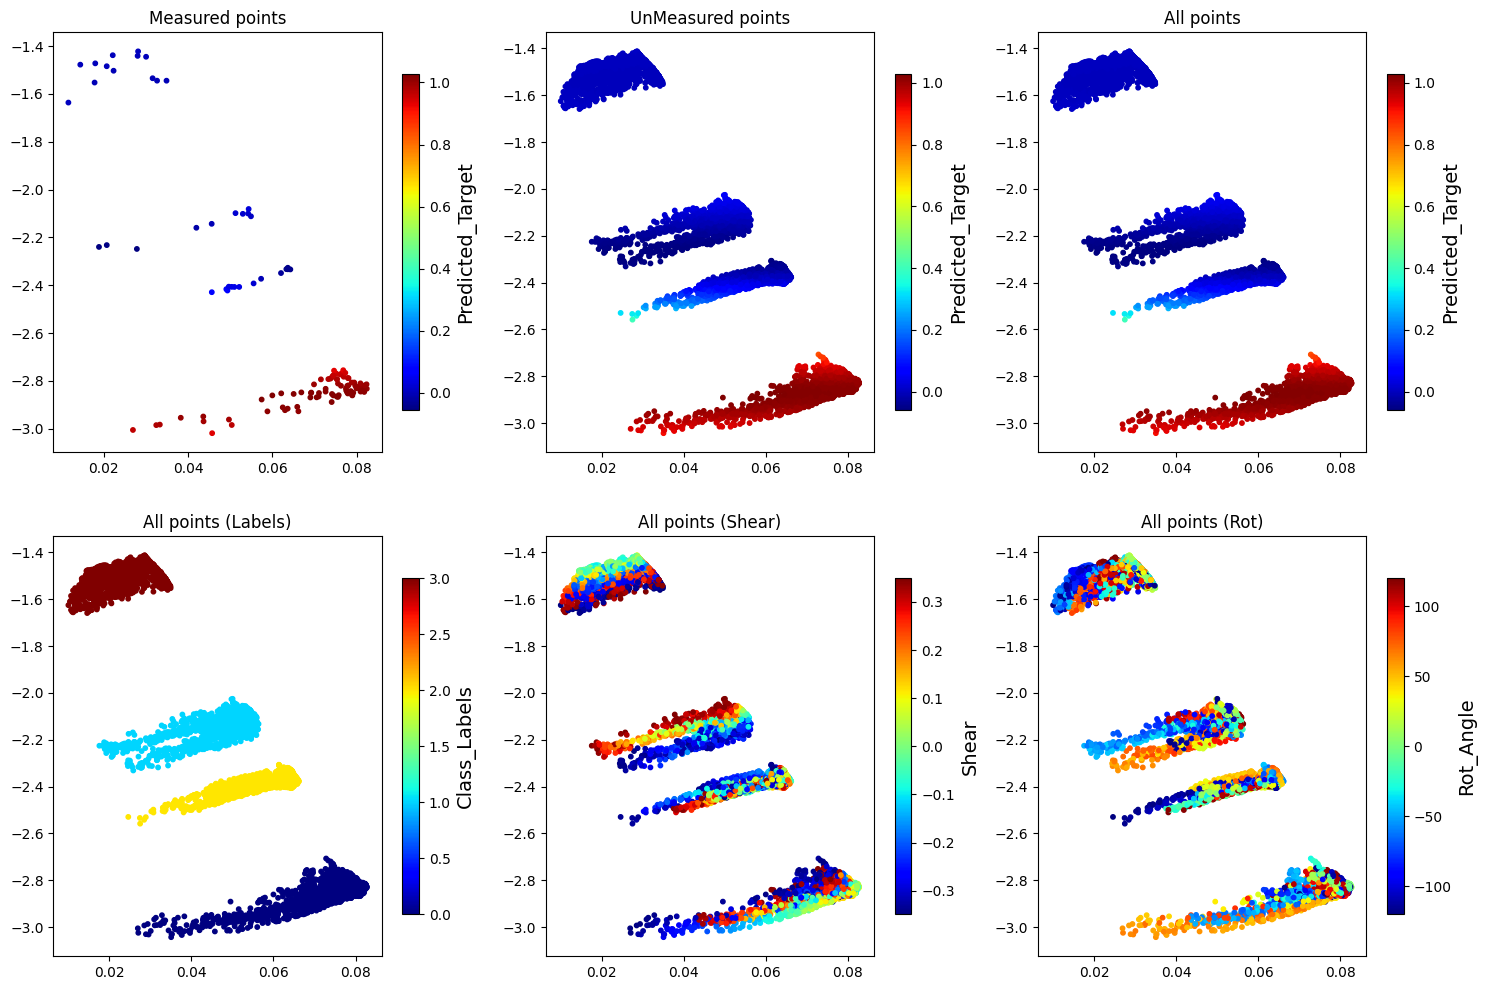

In [22]:
embeded_train0 = dkl_BO_0.embed(X0_train)  # Measured points
embeded_unmeasured0 = dkl_BO_0.embed(X0_unmeasured)  # Unmeasured points
embeded10 = dkl_BO_0.embed(X0)   # All points

fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (18,12))

im = ax[0,0].scatter(embeded_train0[:, 1], embeded_train0[:, 0], s=10, c = predmean_train0, cmap = 'jet')
ax[0,0].set_title('Measured points')
cbar = fig.colorbar(im, ax=ax[0,0], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,1].scatter(embeded_unmeasured0[:, 1], embeded_unmeasured0[:, 0], s=10,
                c = predmean_unmeas0, cmap = 'jet')
ax[0,1].set_title('UnMeasured points')
cbar = fig.colorbar(im, ax=ax[0,1], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,2].scatter(embeded10[:, 1], embeded10[:, 0], s=10, c = predmean10, cmap = 'jet')
ax[0,2].set_title('All points')
cbar = fig.colorbar(im, ax=ax[0,2], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,0].scatter(embeded10[:, 1], embeded10[:, 0], s=10, c = labels_all, cmap = 'jet')
ax[1,0].set_title('All points (Labels)')
cbar = fig.colorbar(im, ax=ax[1,0], shrink=.8)
cbar.set_label("Class_Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,1].scatter(embeded10[:, 1], embeded10[:, 0], s=10, c = shears_all[:,0], cmap = 'jet')
ax[1,1].set_title('All points (Shear)')
cbar = fig.colorbar(im, ax=ax[1,1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,2].scatter(embeded10[:, 1], embeded10[:, 0], s=10, c = angles_all, cmap = 'jet')
ax[1,2].set_title('All points (Rot)')
cbar = fig.colorbar(im, ax=ax[1,2], shrink=.8)
cbar.set_label("Rot_Angle", fontsize=14)
cbar.ax.tick_params(labelsize=10)

Note that we discovered the right manifold with much smaller number of points. Now the "hand" is a continuous function (again, we use cards as a model for more complex processes, so we assume that it is an ordinal variable)

## Spades

Now, let's try the same analysis for spades.

In [23]:
X1 = np.copy(X)
targets1 = np.zeros(len(labels_all))
targets1[labels_all == 1] = 1

rng_key_1, rng_key_predict_1 = gpax.utils.get_keys()
dkl_1 = gpax.viDKL(900, 2, 'RBF')
dkl_1.fit(rng_key_1, X1, targets1)

100%|██████████| 1000/1000 [02:40<00:00,  6.23it/s, init loss: 69196.0108, avg. loss [951-1000]: 45879.9144]



Inferred GP kernel parameters
k_length         [2.5001 1.5144]
k_scale          0.1932
noise            0.008400000000000001


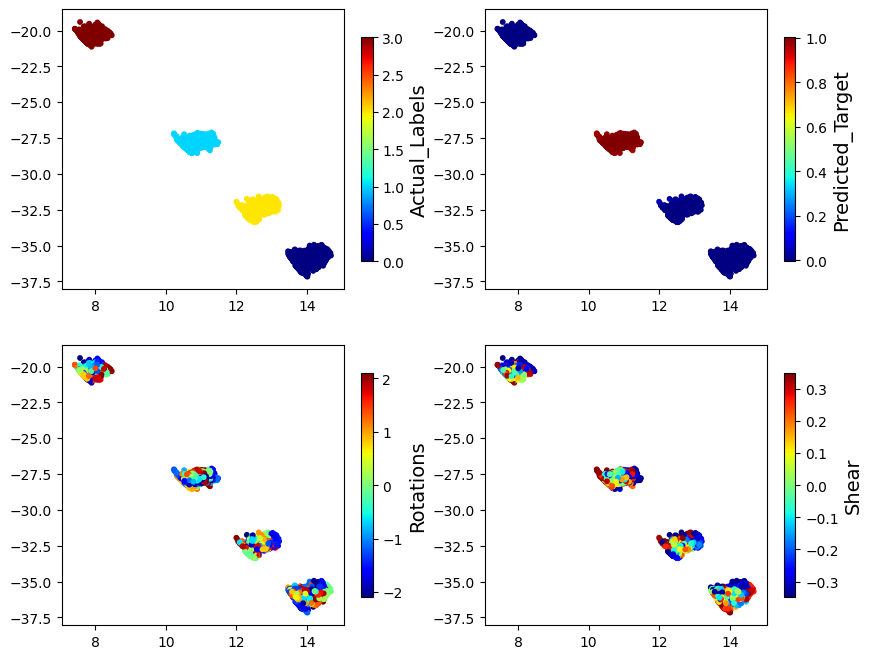

In [24]:
embeded_1 = dkl_1.embed(X1)
pred_mean1, pred_var1 = dkl_1.predict_in_batches(rng_key_predict_1, X1, batch_size=batch_size_reconstruct)
pred_std1 = jnp.sqrt(pred_var1)

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10,8))

im = ax[0,0].scatter(embeded_1[:, 1], embeded_1[:, 0], s=10, c = labels_all, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,0], shrink=.8)
cbar.set_label("Actual_Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,1].scatter(embeded_1[:, 1], embeded_1[:, 0], s=10, c = pred_mean1, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,1], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,0].scatter(embeded_1[:, 1], embeded_1[:, 0], s=10, c = torch.deg2rad(angles_all),
                     cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,0], shrink=.8)
cbar.set_label("Rotations", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,1].scatter(embeded_1[:, 1], embeded_1[:, 0], s=10, c = shears_all[:,0], cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)

Note that here our target is in the center of the DKL manifold. It will have interesting effect on the DKL active learning. Also interetsingly, you can see that rotations got disentangled within the DKL manifolds (and to some extent even shears). We would not see it if we did not have access to the full target set, but nice to know that DKL can also disentangle representations of the data!

In [25]:
np.random.seed(0)
idx1 = np.random.choice(np.arange(len(X1)), size = init_num, replace = False)
X1_train = X1[idx1]
X1_unmeasured = np.delete(X1, idx1, axis=0)

indices_total_1 = np.arange(len(X))
indices_train_1 = indices_total_1[idx1]
y1_train = targets1[idx1]
indices_unmeasured_1 = np.delete(indices_total_1, idx1)

In [26]:
exp_mean1, exp_std1 = [], []
dkl_mean1, dkl_std1 = [], []
embed_traj1 = []
traj_mean1, traj_std1 = [], []

exploration_steps = exploration_steps


for e in range(exploration_steps):
    print("\nStep {}".format(e+1))
    # Obtain/update DKL posterior
    rng_key11, rng_key_predict11 = gpax.utils.get_keys()
    dkl_BO_1 = gpax.viDKL(900, 2, 'RBF')
    dkl_BO_1.fit(rng_key11, X1_train, y1_train)
    # Compute acqusition function
    y_mean, y_var = dkl_BO_1.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        rng_key_predict11, X1_unmeasured, batch_size=250)
    y_std = jnp.sqrt(y_var)
    obj = y_mean + 10 * y_std  # UCB = mu + 10 * sigma
    # Get the next point to evaluate
    id_next = obj.argmax()

    # let's get the mean and std of the next point predicted by dkl_BO
    exp_mean1.append(y_mean[id_next])
    exp_std1.append(y_std[id_next])

    x_next = X1_unmeasured[id_next]
    ind_next = indices_unmeasured_1[id_next]

    # Getting the mean and std of the next point as predicted by the dkl trained on the full dataset
    dkl_mean1.append(pred_mean1[ind_next])
    dkl_std1.append(pred_std1[ind_next])

    # Perform evaluation
#     y_measured = eval_ferrosim(x_next)
    # For now we will only read out the brute force results
    y_measured = targets1[ind_next]

    # Update training arrays
    X1_train = np.append(X1_train, x_next[None], axis=0)
    y1_train = np.append(y1_train, y_measured)
    X1_unmeasured = np.delete(X1_unmeasured, id_next, axis=0)
    indices_unmeasured_1 = np.delete(indices_unmeasured_1, id_next)

    embed_traj = dkl_BO_1.embed(X1_train)
    traj_m, traj_s = dkl_BO_1.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        rng_key_predict11, X1_train, batch_size=10)

    embed_traj1.append(embed_traj)
    traj_mean1.append(traj_m)


Step 1


100%|██████████| 1000/1000 [00:02<00:00, 395.94it/s, init loss: 60100.8548, avg. loss [951-1000]: 56925.6836]



Inferred GP kernel parameters
k_length         [0.3699 0.3437]
k_scale          0.3375
noise            0.014700000000000001

Step 2


100%|██████████| 1000/1000 [00:02<00:00, 385.70it/s, init loss: 60102.0991, avg. loss [951-1000]: 56922.5230]



Inferred GP kernel parameters
k_length         [0.3679 0.3273]
k_scale          0.4111
noise            0.013000000000000001

Step 3


100%|██████████| 1000/1000 [00:02<00:00, 379.63it/s, init loss: 60103.3434, avg. loss [951-1000]: 56925.1517]



Inferred GP kernel parameters
k_length         [0.3728 0.3519]
k_scale          0.4803
noise            0.013900000000000001

Step 4


100%|██████████| 1000/1000 [00:02<00:00, 396.38it/s, init loss: 60104.5876, avg. loss [951-1000]: 56944.5884]



Inferred GP kernel parameters
k_length         [0.4187 0.2992]
k_scale          0.3418
noise            0.0142

Step 5


100%|██████████| 1000/1000 [00:02<00:00, 393.37it/s, init loss: 60105.7916, avg. loss [951-1000]: 56921.0710]



Inferred GP kernel parameters
k_length         [0.3679 0.3012]
k_scale          0.31370000000000003
noise            0.0129

Step 6


100%|██████████| 1000/1000 [00:02<00:00, 388.17it/s, init loss: 60107.2967, avg. loss [951-1000]: 56920.3776]



Inferred GP kernel parameters
k_length         [0.3679 0.3362]
k_scale          0.4007
noise            0.012

Step 7


100%|██████████| 1000/1000 [00:02<00:00, 389.29it/s, init loss: 60108.5409, avg. loss [951-1000]: 56938.3081]



Inferred GP kernel parameters
k_length         [0.3361 0.3689]
k_scale          0.3816
noise            0.0233

Step 8


100%|██████████| 1000/1000 [00:02<00:00, 392.78it/s, init loss: 60109.7720, avg. loss [951-1000]: 56916.2555]



Inferred GP kernel parameters
k_length         [0.3183 0.3608]
k_scale          0.401
noise            0.014

Step 9


100%|██████████| 1000/1000 [00:02<00:00, 373.56it/s, init loss: 60111.0162, avg. loss [951-1000]: 56930.7336]



Inferred GP kernel parameters
k_length         [0.3574 0.3229]
k_scale          0.36610000000000004
noise            0.0188

Step 10


100%|██████████| 1000/1000 [00:02<00:00, 376.08it/s, init loss: 60112.2600, avg. loss [951-1000]: 56920.8733]



Inferred GP kernel parameters
k_length         [0.3847 0.3499]
k_scale          0.4479
noise            0.012400000000000001

Step 11


100%|██████████| 1000/1000 [00:02<00:00, 373.40it/s, init loss: 60113.4483, avg. loss [951-1000]: 56934.1537]



Inferred GP kernel parameters
k_length         [0.3465 0.4109]
k_scale          0.3544
noise            0.0128

Step 12


100%|██████████| 1000/1000 [00:02<00:00, 365.50it/s, init loss: 60114.9532, avg. loss [951-1000]: 56913.3034]



Inferred GP kernel parameters
k_length         [0.3679 0.3335]
k_scale          0.5074000000000001
noise            0.0115

Step 13


100%|██████████| 1000/1000 [00:02<00:00, 396.43it/s, init loss: 60116.4263, avg. loss [951-1000]: 56924.5888]



Inferred GP kernel parameters
k_length         [0.3352 0.2999]
k_scale          0.39690000000000003
noise            0.0119

Step 14


100%|██████████| 1000/1000 [00:02<00:00, 414.10it/s, init loss: 60117.6571, avg. loss [951-1000]: 56909.6569]



Inferred GP kernel parameters
k_length         [0.3683 0.3295]
k_scale          0.5164
noise            0.011000000000000001

Step 15


100%|██████████| 1000/1000 [00:02<00:00, 400.86it/s, init loss: 60118.8713, avg. loss [951-1000]: 56929.8843]



Inferred GP kernel parameters
k_length         [0.324  0.3845]
k_scale          0.3589
noise            0.016800000000000002

Step 16


100%|██████████| 1000/1000 [00:02<00:00, 405.80it/s, init loss: 60120.3636, avg. loss [951-1000]: 56914.8152]



Inferred GP kernel parameters
k_length         [0.3835 0.4465]
k_scale          0.4665
noise            0.012400000000000001

Step 17


100%|██████████| 1000/1000 [00:02<00:00, 395.75it/s, init loss: 60121.7409, avg. loss [951-1000]: 56916.1734]



Inferred GP kernel parameters
k_length         [0.3146 0.3705]
k_scale          0.4335
noise            0.0125

Step 18


100%|██████████| 1000/1000 [00:02<00:00, 409.04it/s, init loss: 60123.2475, avg. loss [951-1000]: 56921.2418]



Inferred GP kernel parameters
k_length         [0.424  0.3664]
k_scale          0.3678
noise            0.0146

Step 19


100%|██████████| 1000/1000 [00:02<00:00, 397.22it/s, init loss: 60124.4820, avg. loss [951-1000]: 56922.6559]



Inferred GP kernel parameters
k_length         [0.4005 0.3622]
k_scale          0.3728
noise            0.0129

Step 20


100%|██████████| 1000/1000 [00:02<00:00, 408.63it/s, init loss: 60125.7207, avg. loss [951-1000]: 56906.8462]



Inferred GP kernel parameters
k_length         [0.2918 0.3679]
k_scale          0.3921
noise            0.0112

Step 21


100%|██████████| 1000/1000 [00:02<00:00, 401.64it/s, init loss: 60126.9481, avg. loss [951-1000]: 56906.9784]



Inferred GP kernel parameters
k_length         [0.4072 0.4635]
k_scale          0.38770000000000004
noise            0.011600000000000001

Step 22


100%|██████████| 1000/1000 [00:02<00:00, 404.57it/s, init loss: 60128.1924, avg. loss [951-1000]: 56912.5483]



Inferred GP kernel parameters
k_length         [0.4616 0.3269]
k_scale          0.47140000000000004
noise            0.0145

Step 23


100%|██████████| 1000/1000 [00:02<00:00, 399.67it/s, init loss: 60129.3320, avg. loss [951-1000]: 56903.7406]



Inferred GP kernel parameters
k_length         [0.3774 0.3911]
k_scale          0.45940000000000003
noise            0.0112

Step 24


100%|██████████| 1000/1000 [00:02<00:00, 401.32it/s, init loss: 60130.7232, avg. loss [951-1000]: 56928.9675]



Inferred GP kernel parameters
k_length         [0.3404 0.3608]
k_scale          0.4111
noise            0.012700000000000001

Step 25


100%|██████████| 1000/1000 [00:02<00:00, 393.96it/s, init loss: 60131.9329, avg. loss [951-1000]: 56922.0482]



Inferred GP kernel parameters
k_length         [0.3438 0.3924]
k_scale          0.3909
noise            0.016900000000000002

Step 26


100%|██████████| 1000/1000 [00:02<00:00, 405.60it/s, init loss: 60133.1634, avg. loss [951-1000]: 56933.5592]



Inferred GP kernel parameters
k_length         [0.5651 0.6811]
k_scale          0.2298
noise            0.0142

Step 27


100%|██████████| 1000/1000 [00:02<00:00, 404.08it/s, init loss: 60134.6685, avg. loss [951-1000]: 56943.6309]



Inferred GP kernel parameters
k_length         [0.4736 0.3892]
k_scale          0.3302
noise            0.0152

Step 28


100%|██████████| 1000/1000 [00:02<00:00, 396.72it/s, init loss: 60136.1635, avg. loss [951-1000]: 56894.6958]



Inferred GP kernel parameters
k_length         [0.3642 0.3689]
k_scale          0.4308
noise            0.0106

Step 29


100%|██████████| 1000/1000 [00:02<00:00, 407.50it/s, init loss: 60137.4078, avg. loss [951-1000]: 56902.2665]



Inferred GP kernel parameters
k_length         [0.4013 0.4003]
k_scale          0.4587
noise            0.0123

Step 30


100%|██████████| 1000/1000 [00:02<00:00, 397.25it/s, init loss: 60138.6521, avg. loss [951-1000]: 56955.7523]



Inferred GP kernel parameters
k_length         [0.3864 0.3315]
k_scale          0.2247
noise            0.023700000000000002

Step 31


100%|██████████| 1000/1000 [00:02<00:00, 389.80it/s, init loss: 60139.8941, avg. loss [951-1000]: 56942.7389]



Inferred GP kernel parameters
k_length         [0.4274 0.362 ]
k_scale          0.2862
noise            0.0126

Step 32


100%|██████████| 1000/1000 [00:02<00:00, 402.74it/s, init loss: 60141.3979, avg. loss [951-1000]: 56889.8660]



Inferred GP kernel parameters
k_length         [0.3824 0.3969]
k_scale          0.45630000000000004
noise            0.0102

Step 33


100%|██████████| 1000/1000 [00:02<00:00, 404.66it/s, init loss: 60142.6422, avg. loss [951-1000]: 56984.3250]



Inferred GP kernel parameters
k_length         [0.3453 0.3276]
k_scale          0.2411
noise            0.0196

Step 34


100%|██████████| 1000/1000 [00:02<00:00, 393.27it/s, init loss: 60143.8555, avg. loss [951-1000]: 56895.9584]



Inferred GP kernel parameters
k_length         [0.3631 0.3559]
k_scale          0.48260000000000003
noise            0.0117

Step 35


100%|██████████| 1000/1000 [00:02<00:00, 395.78it/s, init loss: 60145.0335, avg. loss [951-1000]: 56883.3306]



Inferred GP kernel parameters
k_length         [0.3318 0.3673]
k_scale          0.5008
noise            0.0102

Step 36


100%|██████████| 1000/1000 [00:02<00:00, 399.80it/s, init loss: 60146.2622, avg. loss [951-1000]: 56901.3245]



Inferred GP kernel parameters
k_length         [0.4799 0.4302]
k_scale          0.3682
noise            0.012400000000000001

Step 37


100%|██████████| 1000/1000 [00:02<00:00, 396.31it/s, init loss: 60147.7673, avg. loss [951-1000]: 56926.8010]



Inferred GP kernel parameters
k_length         [0.4317 0.5147]
k_scale          0.2364
noise            0.0151

Step 38


100%|██████████| 1000/1000 [00:02<00:00, 395.37it/s, init loss: 60149.2136, avg. loss [951-1000]: 56987.7220]



Inferred GP kernel parameters
k_length         [0.2652 0.4019]
k_scale          0.2278
noise            0.0172

Step 39


100%|██████████| 1000/1000 [00:02<00:00, 398.68it/s, init loss: 60150.4579, avg. loss [951-1000]: 56872.5797]



Inferred GP kernel parameters
k_length         [0.3462 0.3921]
k_scale          0.36970000000000003
noise            0.0092

Step 40


100%|██████████| 1000/1000 [00:02<00:00, 405.31it/s, init loss: 60151.6931, avg. loss [951-1000]: 56988.4639]



Inferred GP kernel parameters
k_length         [0.469  0.5118]
k_scale          0.2006
noise            0.016800000000000002

Step 41


100%|██████████| 1000/1000 [00:02<00:00, 396.12it/s, init loss: 60152.8563, avg. loss [951-1000]: 56880.0162]



Inferred GP kernel parameters
k_length         [0.3508 0.3754]
k_scale          0.42110000000000003
noise            0.0109

Step 42


100%|██████████| 1000/1000 [00:02<00:00, 401.96it/s, init loss: 60154.1006, avg. loss [951-1000]: 56995.4925]



Inferred GP kernel parameters
k_length         [0.3926 0.4914]
k_scale          0.2063
noise            0.015000000000000001

Step 43


100%|██████████| 1000/1000 [00:03<00:00, 261.16it/s, init loss: 60155.4665, avg. loss [951-1000]: 56893.1078]



Inferred GP kernel parameters
k_length         [0.5575 0.4333]
k_scale          0.3654
noise            0.0114

Step 44


100%|██████████| 1000/1000 [00:02<00:00, 381.60it/s, init loss: 60156.6800, avg. loss [951-1000]: 56960.5387]



Inferred GP kernel parameters
k_length         [0.3107 0.3473]
k_scale          0.2641
noise            0.0122

Step 45


100%|██████████| 1000/1000 [00:02<00:00, 383.25it/s, init loss: 60158.1780, avg. loss [951-1000]: 56872.4125]



Inferred GP kernel parameters
k_length         [0.4166 0.3856]
k_scale          0.4252
noise            0.0099

Step 46


100%|██████████| 1000/1000 [00:02<00:00, 405.94it/s, init loss: 60159.4223, avg. loss [951-1000]: 56900.3388]



Inferred GP kernel parameters
k_length         [0.4371 0.7116]
k_scale          0.3043
noise            0.0128

Step 47


100%|██████████| 1000/1000 [00:02<00:00, 407.05it/s, init loss: 60160.8345, avg. loss [951-1000]: 56872.5685]



Inferred GP kernel parameters
k_length         [0.417  0.3491]
k_scale          0.41910000000000003
noise            0.010400000000000001

Step 48


100%|██████████| 1000/1000 [00:02<00:00, 411.17it/s, init loss: 60162.0734, avg. loss [951-1000]: 56866.0818]



Inferred GP kernel parameters
k_length         [0.3896 0.3929]
k_scale          0.4867
noise            0.009300000000000001

Step 49


100%|██████████| 1000/1000 [00:02<00:00, 402.86it/s, init loss: 60163.5840, avg. loss [951-1000]: 56959.6014]



Inferred GP kernel parameters
k_length         [0.4077 0.3607]
k_scale          0.2288
noise            0.0167

Step 50


100%|██████████| 1000/1000 [00:02<00:00, 399.51it/s, init loss: 60164.8185, avg. loss [951-1000]: 56890.7977]



Inferred GP kernel parameters
k_length         [0.5636 0.4959]
k_scale          0.37560000000000004
noise            0.0119

Step 51


100%|██████████| 1000/1000 [00:02<00:00, 408.28it/s, init loss: 60166.2843, avg. loss [951-1000]: 56957.6066]



Inferred GP kernel parameters
k_length         [0.5866 0.5582]
k_scale          0.1912
noise            0.0158

Step 52


100%|██████████| 1000/1000 [00:02<00:00, 405.84it/s, init loss: 60167.4634, avg. loss [951-1000]: 56941.2139]



Inferred GP kernel parameters
k_length         [0.3513 0.3491]
k_scale          0.2904
noise            0.0126

Step 53


100%|██████████| 1000/1000 [00:02<00:00, 404.24it/s, init loss: 60168.6741, avg. loss [951-1000]: 56853.8905]



Inferred GP kernel parameters
k_length         [0.3492 0.3392]
k_scale          0.37560000000000004
noise            0.0091

Step 54


100%|██████████| 1000/1000 [00:02<00:00, 405.13it/s, init loss: 60169.9079, avg. loss [951-1000]: 56877.9533]



Inferred GP kernel parameters
k_length         [0.3967 0.4401]
k_scale          0.42250000000000004
noise            0.011000000000000001

Step 55


100%|██████████| 1000/1000 [00:02<00:00, 410.20it/s, init loss: 60171.3619, avg. loss [951-1000]: 56980.6781]



Inferred GP kernel parameters
k_length         [0.2807 0.3534]
k_scale          0.3
noise            0.0142

Step 56


100%|██████████| 1000/1000 [00:02<00:00, 398.61it/s, init loss: 60172.6062, avg. loss [951-1000]: 56932.6247]



Inferred GP kernel parameters
k_length         [0.5689 0.6205]
k_scale          0.2505
noise            0.0122

Step 57


100%|██████████| 1000/1000 [00:02<00:00, 405.69it/s, init loss: 60173.8504, avg. loss [951-1000]: 56932.2645]



Inferred GP kernel parameters
k_length         [0.3712 0.4037]
k_scale          0.2485
noise            0.012400000000000001

Step 58


100%|██████████| 1000/1000 [00:02<00:00, 411.72it/s, init loss: 60175.0315, avg. loss [951-1000]: 56880.3292]



Inferred GP kernel parameters
k_length         [0.4315 0.4586]
k_scale          0.28300000000000003
noise            0.013000000000000001

Step 59


100%|██████████| 1000/1000 [00:02<00:00, 405.02it/s, init loss: 60176.2609, avg. loss [951-1000]: 56870.6507]



Inferred GP kernel parameters
k_length         [0.3978 0.4841]
k_scale          0.44970000000000004
noise            0.011300000000000001

Step 60


100%|██████████| 1000/1000 [00:02<00:00, 398.39it/s, init loss: 60177.7657, avg. loss [951-1000]: 56848.3239]



Inferred GP kernel parameters
k_length         [0.4861 0.5385]
k_scale          0.3378
noise            0.009600000000000001

Step 61


100%|██████████| 1000/1000 [00:02<00:00, 403.85it/s, init loss: 60179.0001, avg. loss [951-1000]: 56853.1427]



Inferred GP kernel parameters
k_length         [0.3314 0.3849]
k_scale          0.43570000000000003
noise            0.01

Step 62


100%|██████████| 1000/1000 [00:03<00:00, 258.03it/s, init loss: 60180.2442, avg. loss [951-1000]: 56848.6219]



Inferred GP kernel parameters
k_length         [0.3895 0.4379]
k_scale          0.4711
noise            0.0095

Step 63


100%|██████████| 1000/1000 [00:02<00:00, 397.44it/s, init loss: 60181.4288, avg. loss [951-1000]: 56846.5468]



Inferred GP kernel parameters
k_length         [0.3181 0.3657]
k_scale          0.432
noise            0.009000000000000001

Step 64


100%|██████████| 1000/1000 [00:02<00:00, 402.41it/s, init loss: 60182.6365, avg. loss [951-1000]: 56885.0357]



Inferred GP kernel parameters
k_length         [0.7174 0.5078]
k_scale          0.29400000000000004
noise            0.0146

Step 65


100%|██████████| 1000/1000 [00:02<00:00, 406.43it/s, init loss: 60184.1340, avg. loss [951-1000]: 56861.5274]



Inferred GP kernel parameters
k_length         [0.7016 0.7936]
k_scale          0.3126
noise            0.0106

Step 66


100%|██████████| 1000/1000 [00:02<00:00, 393.09it/s, init loss: 60185.3640, avg. loss [951-1000]: 56846.8353]



Inferred GP kernel parameters
k_length         [0.5244 0.5245]
k_scale          0.42860000000000004
noise            0.0098

Step 67


100%|██████████| 1000/1000 [00:02<00:00, 408.51it/s, init loss: 60186.5732, avg. loss [951-1000]: 56903.1422]



Inferred GP kernel parameters
k_length         [0.3995 0.5017]
k_scale          0.30260000000000004
noise            0.0129

Step 68


100%|██████████| 1000/1000 [00:02<00:00, 403.22it/s, init loss: 60187.7479, avg. loss [951-1000]: 56890.9663]



Inferred GP kernel parameters
k_length         [0.4671 0.2712]
k_scale          0.2851
noise            0.015300000000000001

Step 69


100%|██████████| 1000/1000 [00:02<00:00, 403.50it/s, init loss: 60188.9884, avg. loss [951-1000]: 56892.4942]



Inferred GP kernel parameters
k_length         [0.4829 0.5569]
k_scale          0.318
noise            0.0105

Step 70


100%|██████████| 1000/1000 [00:02<00:00, 395.62it/s, init loss: 60190.1032, avg. loss [951-1000]: 56930.5908]



Inferred GP kernel parameters
k_length         [0.398  0.5195]
k_scale          0.2577
noise            0.0114

Step 71


100%|██████████| 1000/1000 [00:02<00:00, 404.40it/s, init loss: 60191.2828, avg. loss [951-1000]: 56848.7022]



Inferred GP kernel parameters
k_length         [0.406  0.3923]
k_scale          0.3456
noise            0.0105

Step 72


100%|██████████| 1000/1000 [00:02<00:00, 395.17it/s, init loss: 60192.5206, avg. loss [951-1000]: 56908.7226]



Inferred GP kernel parameters
k_length         [0.4909 0.5324]
k_scale          0.2863
noise            0.012400000000000001

Step 73


100%|██████████| 1000/1000 [00:02<00:00, 409.35it/s, init loss: 60193.7300, avg. loss [951-1000]: 56875.5037]



Inferred GP kernel parameters
k_length         [0.5229 0.4405]
k_scale          0.2665
noise            0.011300000000000001

Step 74


100%|██████████| 1000/1000 [00:02<00:00, 402.44it/s, init loss: 60195.1408, avg. loss [951-1000]: 56892.7710]



Inferred GP kernel parameters
k_length         [0.5087 0.5617]
k_scale          0.2812
noise            0.013000000000000001

Step 75


100%|██████████| 1000/1000 [00:02<00:00, 401.02it/s, init loss: 60196.6130, avg. loss [951-1000]: 56834.7174]



Inferred GP kernel parameters
k_length         [0.4509 0.5256]
k_scale          0.2975
noise            0.0098

Step 76


100%|██████████| 1000/1000 [00:02<00:00, 399.27it/s, init loss: 60197.8663, avg. loss [951-1000]: 56864.6065]



Inferred GP kernel parameters
k_length         [0.5209 0.4752]
k_scale          0.3126
noise            0.0105

Step 77


100%|██████████| 1000/1000 [00:02<00:00, 403.76it/s, init loss: 60199.1104, avg. loss [951-1000]: 56830.9031]



Inferred GP kernel parameters
k_length         [0.4203 0.4863]
k_scale          0.3005
noise            0.0099

Step 78


100%|██████████| 1000/1000 [00:02<00:00, 397.41it/s, init loss: 60200.2950, avg. loss [951-1000]: 56856.0034]



Inferred GP kernel parameters
k_length         [0.448  0.5514]
k_scale          0.34700000000000003
noise            0.0117

Step 79


100%|██████████| 1000/1000 [00:02<00:00, 397.71it/s, init loss: 60201.7519, avg. loss [951-1000]: 56851.4575]



Inferred GP kernel parameters
k_length         [0.4437 0.4378]
k_scale          0.2837
noise            0.0114

Step 80


100%|██████████| 1000/1000 [00:02<00:00, 399.20it/s, init loss: 60202.9233, avg. loss [951-1000]: 56829.4339]



Inferred GP kernel parameters
k_length         [0.403  0.4157]
k_scale          0.4489
noise            0.0097

Step 81


100%|██████████| 1000/1000 [00:03<00:00, 251.90it/s, init loss: 60204.1676, avg. loss [951-1000]: 56842.8595]



Inferred GP kernel parameters
k_length         [0.5148 0.6692]
k_scale          0.2748
noise            0.0114

Step 82


100%|██████████| 1000/1000 [00:02<00:00, 399.80it/s, init loss: 60205.3925, avg. loss [951-1000]: 56883.9902]



Inferred GP kernel parameters
k_length         [0.5817 0.8708]
k_scale          0.2521
noise            0.0129

Step 83


100%|██████████| 1000/1000 [00:02<00:00, 397.73it/s, init loss: 60206.8600, avg. loss [951-1000]: 56876.2337]



Inferred GP kernel parameters
k_length         [0.5223 0.5256]
k_scale          0.3791
noise            0.0126

Step 84


100%|██████████| 1000/1000 [00:02<00:00, 391.35it/s, init loss: 60208.0988, avg. loss [951-1000]: 56889.9835]



Inferred GP kernel parameters
k_length         [0.7301 0.791 ]
k_scale          0.24200000000000002
noise            0.015600000000000001

Step 85


100%|██████████| 1000/1000 [00:02<00:00, 402.11it/s, init loss: 60209.5140, avg. loss [951-1000]: 56885.5518]



Inferred GP kernel parameters
k_length         [0.6211 0.5562]
k_scale          0.25830000000000003
noise            0.0114

Step 86


100%|██████████| 1000/1000 [00:02<00:00, 404.90it/s, init loss: 60210.7162, avg. loss [951-1000]: 56888.6171]



Inferred GP kernel parameters
k_length         [0.6111 0.4785]
k_scale          0.3039
noise            0.0119

Step 87


100%|██████████| 1000/1000 [00:02<00:00, 397.90it/s, init loss: 60211.8749, avg. loss [951-1000]: 56809.4498]



Inferred GP kernel parameters
k_length         [0.3353 0.4374]
k_scale          0.31770000000000004
noise            0.0088

Step 88


100%|██████████| 1000/1000 [00:02<00:00, 396.19it/s, init loss: 60213.1177, avg. loss [951-1000]: 56816.9680]



Inferred GP kernel parameters
k_length         [0.5085 0.4463]
k_scale          0.4248
noise            0.009300000000000001

Step 89


100%|██████████| 1000/1000 [00:02<00:00, 400.41it/s, init loss: 60214.3605, avg. loss [951-1000]: 56824.3030]



Inferred GP kernel parameters
k_length         [0.3877 0.4516]
k_scale          0.3151
noise            0.01

Step 90


100%|██████████| 1000/1000 [00:02<00:00, 401.68it/s, init loss: 60215.5948, avg. loss [951-1000]: 56847.1292]



Inferred GP kernel parameters
k_length         [0.4358 0.5183]
k_scale          0.2954
noise            0.0108

Step 91


100%|██████████| 1000/1000 [00:02<00:00, 388.51it/s, init loss: 60216.7850, avg. loss [951-1000]: 56880.9145]



Inferred GP kernel parameters
k_length         [0.7391 0.4022]
k_scale          0.29600000000000004
noise            0.0122

Step 92


100%|██████████| 1000/1000 [00:02<00:00, 395.39it/s, init loss: 60217.9670, avg. loss [951-1000]: 56817.7266]



Inferred GP kernel parameters
k_length         [0.5503 0.6197]
k_scale          0.3805
noise            0.0099

Step 93


100%|██████████| 1000/1000 [00:02<00:00, 393.81it/s, init loss: 60219.2092, avg. loss [951-1000]: 56944.6842]



Inferred GP kernel parameters
k_length         [0.4162 0.4469]
k_scale          0.1933
noise            0.0132

Step 94


100%|██████████| 1000/1000 [00:02<00:00, 387.80it/s, init loss: 60220.4445, avg. loss [951-1000]: 56831.7035]



Inferred GP kernel parameters
k_length         [0.4181 0.3778]
k_scale          0.4058
noise            0.0097

Step 95


100%|██████████| 1000/1000 [00:02<00:00, 381.10it/s, init loss: 60221.6522, avg. loss [951-1000]: 56890.0054]



Inferred GP kernel parameters
k_length         [0.3968 0.4711]
k_scale          0.2763
noise            0.0125

Step 96


100%|██████████| 1000/1000 [00:02<00:00, 387.62it/s, init loss: 60222.8652, avg. loss [951-1000]: 56925.9750]



Inferred GP kernel parameters
k_length         [0.4982 0.3713]
k_scale          0.2024
noise            0.0137

Step 97


100%|██████████| 1000/1000 [00:02<00:00, 390.03it/s, init loss: 60224.0993, avg. loss [951-1000]: 56809.9836]



Inferred GP kernel parameters
k_length         [0.534  0.5195]
k_scale          0.34850000000000003
noise            0.0097

Step 98


100%|██████████| 1000/1000 [00:02<00:00, 395.09it/s, init loss: 60225.3750, avg. loss [951-1000]: 56857.2513]



Inferred GP kernel parameters
k_length         [0.5164 0.565 ]
k_scale          0.3019
noise            0.011300000000000001

Step 99


100%|██████████| 1000/1000 [00:02<00:00, 394.36it/s, init loss: 60226.7087, avg. loss [951-1000]: 56887.0885]



Inferred GP kernel parameters
k_length         [0.4096 0.4138]
k_scale          0.1998
noise            0.012100000000000001

Step 100


100%|██████████| 1000/1000 [00:02<00:00, 399.33it/s, init loss: 60227.9527, avg. loss [951-1000]: 56821.7811]



Inferred GP kernel parameters
k_length         [0.6578 0.703 ]
k_scale          0.2753
noise            0.0111


In [27]:
spades_results = {}
spades_results['X_train'] = X1_train
spades_results['y_train'] = y1_train
spades_results['X_unmeasured'] = X1_unmeasured
spades_results['indices_unmeasured'] = indices_unmeasured_1
spades_results['dkl_mean'] = dkl_mean1
spades_results['dkl_std'] = dkl_std1
spades_results['exp_mean'] = exp_mean1
spades_results['exp_std'] = exp_std1
spades_results['traj_mean'] = traj_mean1
spades_results['traj_std'] = traj_std1
spades_results['embed_traj'] = embed_traj1

with open('spades_results.pickle', 'wb') as handle:
    pickle.dump(spades_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [28]:
with open('spades_results.pickle', 'rb') as f:
    spades_results = pickle.load(f)

X1_train = spades_results['X_train']
y1_train = spades_results['y_train']
X1_unmeasured = spades_results['X_unmeasured']
indices_unmeasured_1 = spades_results['indices_unmeasured']
dkl_mean1 = spades_results['dkl_mean']
dkl_std1 = spades_results['dkl_std']
exp_mean1 = spades_results['exp_mean']
exp_std1 = spades_results['exp_std']
traj_mean1 = spades_results['traj_mean']
traj_std1 = spades_results['traj_std']
embed_traj1 = spades_results['embed_traj']

In [29]:
rng_key11, rng_key_predict11 = gpax.utils.get_keys()
dkl_BO_1 = gpax.viDKL(900, 2, 'RBF')
dkl_BO_1.fit(rng_key11, X1_train, y1_train)

predmean_train1, predstd_train1 = dkl_BO_1.predict_in_batches(rng_key_predict11, X1_train, batch_size=batch_size_learn)
predmean_unmeas1, predstd_unmeas1 = dkl_BO_1.predict_in_batches(rng_key_predict11, X1_unmeasured, batch_size=batch_size_reconstruct)
predmean11, predstd11 = dkl_BO_1.predict_in_batches(rng_key_predict11, X1, batch_size=batch_size_reconstruct)

100%|██████████| 1000/1000 [00:04<00:00, 249.17it/s, init loss: 60229.3378, avg. loss [951-1000]: 56797.9563]



Inferred GP kernel parameters
k_length         [0.5631 0.4524]
k_scale          0.2821
noise            0.0095


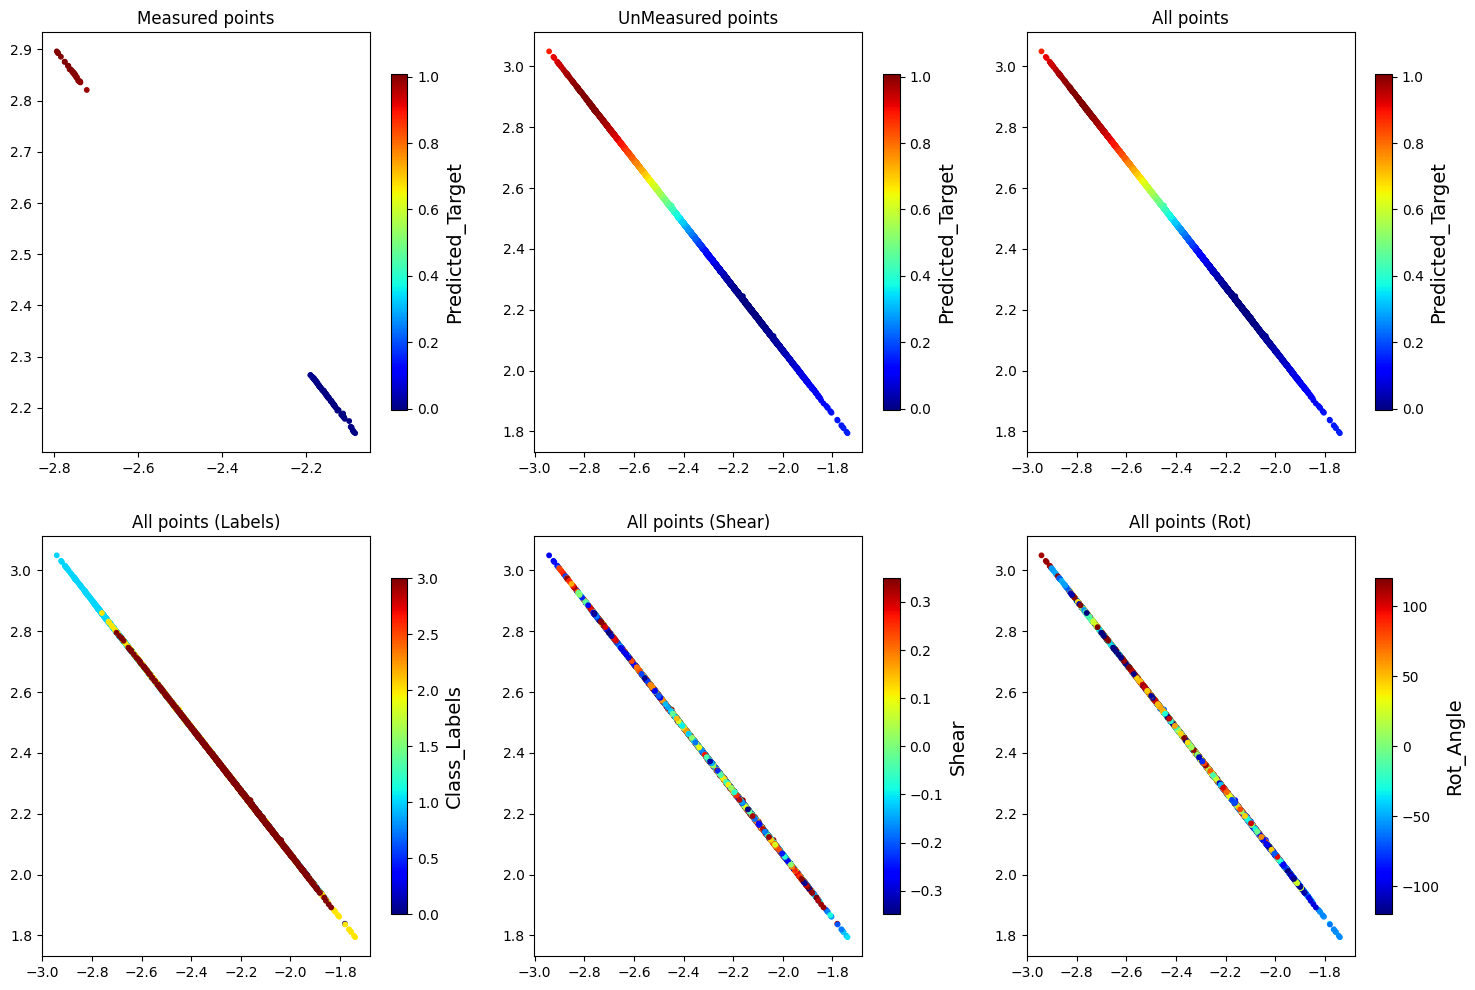

In [30]:
embeded_train1 = dkl_BO_1.embed(X1_train)  # Measured points
embeded_unmeasured1 = dkl_BO_1.embed(X1_unmeasured)  # Unmeasured points
embeded11 = dkl_BO_1.embed(X1)   # All points

fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (18,12))

im = ax[0,0].scatter(embeded_train1[:, 1], embeded_train1[:, 0], s=10, c = predmean_train1, cmap = 'jet')
ax[0,0].set_title('Measured points')
cbar = fig.colorbar(im, ax=ax[0,0], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,1].scatter(embeded_unmeasured1[:, 1], embeded_unmeasured1[:, 0], s=10,
                c = predmean_unmeas1, cmap = 'jet')
ax[0,1].set_title('UnMeasured points')
cbar = fig.colorbar(im, ax=ax[0,1], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,2].scatter(embeded11[:, 1], embeded11[:, 0], s=10, c = predmean11, cmap = 'jet')
ax[0,2].set_title('All points')
cbar = fig.colorbar(im, ax=ax[0,2], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,0].scatter(embeded11[:, 1], embeded11[:, 0], s=10, c = labels_all, cmap = 'jet')
ax[1,0].set_title('All points (Labels)')
cbar = fig.colorbar(im, ax=ax[1,0], shrink=.8)
cbar.set_label("Class_Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,1].scatter(embeded11[:, 1], embeded11[:, 0], s=10, c = shears_all[:,0], cmap = 'jet')
ax[1,1].set_title('All points (Shear)')
cbar = fig.colorbar(im, ax=ax[1,1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,2].scatter(embeded11[:, 1], embeded11[:, 0], s=10, c = angles_all, cmap = 'jet')
ax[1,2].set_title('All points (Rot)')
cbar = fig.colorbar(im, ax=ax[1,2], shrink=.8)
cbar.set_label("Rot_Angle", fontsize=14)
cbar.ax.tick_params(labelsize=10)

Here, we observe a very interetsing effect where due to initial misalignment between the points the target function ended up being in different parts of the latent space. the DKL still managed to construct a much smoother manifold then the VAE - but now we have 4 maxima for "spadedness". No surprise - they look very similar to hearts.

Generally, giving more seed points will avoid this problem.

## Hearts

And now hearts

In [31]:
X2 = np.copy(X)
targets2 = np.zeros(len(labels_all))
targets2[labels_all == 2] = 1

rng_key_2, rng_key_predict_2 = gpax.utils.get_keys()
dkl_2 = gpax.viDKL(900, 2, 'RBF')
dkl_2.fit(rng_key_2, X2, targets2)

100%|██████████| 1000/1000 [02:40<00:00,  6.22it/s, init loss: 69208.7161, avg. loss [951-1000]: 45708.0703]



Inferred GP kernel parameters
k_length         [3.4949 2.6884]
k_scale          0.16540000000000002
noise            0.0082


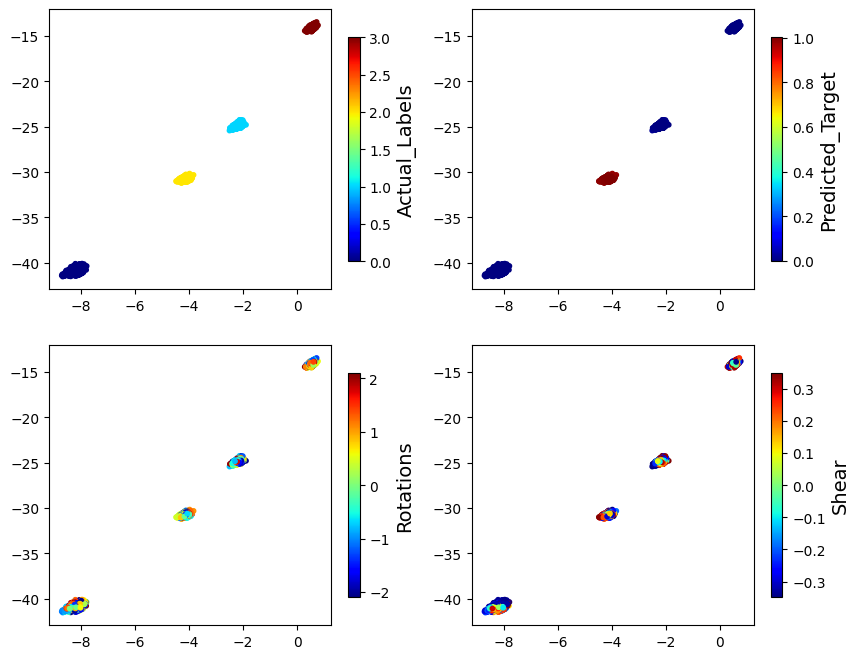

In [32]:
embeded_2 = dkl_2.embed(X2)
pred_mean2, pred_var2 = dkl_2.predict_in_batches(rng_key_predict_2, X2, batch_size=batch_size_reconstruct)
pred_std2 = jnp.sqrt(pred_var2)

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10,8))

im = ax[0,0].scatter(embeded_2[:, 1], embeded_2[:, 0], s=10, c = labels_all, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,0], shrink=.8)
cbar.set_label("Actual_Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,1].scatter(embeded_2[:, 1], embeded_2[:, 0], s=10, c = pred_mean2, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,1], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,0].scatter(embeded_2[:, 1], embeded_2[:, 0], s=10, c = torch.deg2rad(angles_all),
                     cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,0], shrink=.8)
cbar.set_label("Rotations", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,1].scatter(embeded_2[:, 1], embeded_2[:, 0], s=10, c = shears_all[:,0], cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)

For hearts, the system behavior is even more interesting. Here the target manifold is fairly complex - and resembles the VAE. Still much simpler then vanilla VAE. Again, note the disentanglement of rotations - which is now global. Generally, by now you have noticed is the better the discovery of the target functionality, the worse is the disentanglement of remaining variables.

In [33]:
np.random.seed(0)
idx2 = np.random.choice(np.arange(len(X2)), size = init_num, replace = False)
X2_train = X2[idx2]
X2_unmeasured = np.delete(X2, idx2, axis=0)

indices_total_2 = np.arange(len(X))
indices_train_2 = indices_total_2[idx2]
y2_train = targets2[idx2]
indices_unmeasured_2 = np.delete(indices_total_2, idx2)

In [34]:
exp_mean2, exp_std2 = [], []
dkl_mean2, dkl_std2 = [], []
embed_traj2 = []
traj_mean2, traj_std2 = [], []

exploration_steps = exploration_steps


for e in range(exploration_steps):
    print("\nStep {}".format(e+1))
    # Obtain/update DKL posterior
    rng_key12, rng_key_predict12 = gpax.utils.get_keys(seed = 15)
    dkl_BO_2 = gpax.viDKL(900, 2, 'RBF')
    dkl_BO_2.fit(rng_key12, X2_train, y2_train)
    # Compute acqusition function
    y_mean, y_var = dkl_BO_2.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        rng_key_predict12, X2_unmeasured, batch_size=250)
    y_std = jnp.sqrt(y_var)
    obj = y_mean + 10 * y_std  # UCB = mu + 10 * sigma
    # Get the next point to evaluate
    id_next = obj.argmax()

    # let's get the mean and std of the next point predicted by dkl_BO
    exp_mean2.append(y_mean[id_next])
    exp_std2.append(y_std[id_next])

    x_next = X2_unmeasured[id_next]
    ind_next = indices_unmeasured_2[id_next]

    # Getting the mean and std of the next point as predicted by the dkl trained on the full dataset
    dkl_mean2.append(pred_mean2[ind_next])
    dkl_std2.append(pred_std2[ind_next])

    # Perform evaluation
#     y_measured = eval_ferrosim(x_next)
    # For now we will only read out the brute force results
    y_measured = targets2[ind_next]

    # Update training arrays
    X2_train = np.append(X2_train, x_next[None], axis=0)
    y2_train = np.append(y2_train, y_measured)
    X2_unmeasured = np.delete(X2_unmeasured, id_next, axis=0)
    indices_unmeasured_2 = np.delete(indices_unmeasured_2, id_next)

    embed_traj = dkl_BO_2.embed(X2_train)
    traj_m, traj_s = dkl_BO_2.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        rng_key_predict12, X2_train, batch_size=batch_size_learn)

    embed_traj2.append(embed_traj)
    traj_mean2.append(traj_m)


Step 1


100%|██████████| 1000/1000 [00:02<00:00, 393.25it/s, init loss: 60126.3327, avg. loss [951-1000]: 56924.3688]



Inferred GP kernel parameters
k_length         [0.3679 0.3166]
k_scale          0.5185000000000001
noise            0.009000000000000001

Step 2


100%|██████████| 1000/1000 [00:02<00:00, 392.64it/s, init loss: 60127.8659, avg. loss [951-1000]: 56925.2382]



Inferred GP kernel parameters
k_length         [0.3679 0.3099]
k_scale          0.4435
noise            0.0095

Step 3


100%|██████████| 1000/1000 [00:02<00:00, 389.63it/s, init loss: 60129.1611, avg. loss [951-1000]: 56918.0138]



Inferred GP kernel parameters
k_length         [0.3679 0.3394]
k_scale          0.4132
noise            0.0078000000000000005

Step 4


100%|██████████| 1000/1000 [00:02<00:00, 399.45it/s, init loss: 60130.4563, avg. loss [951-1000]: 56919.7540]



Inferred GP kernel parameters
k_length         [0.368  0.3371]
k_scale          0.5176000000000001
noise            0.0078000000000000005

Step 5


100%|██████████| 1000/1000 [00:02<00:00, 394.75it/s, init loss: 60131.7434, avg. loss [951-1000]: 56918.0694]



Inferred GP kernel parameters
k_length         [0.3281 0.3609]
k_scale          0.3199
noise            0.0082

Step 6


100%|██████████| 1000/1000 [00:02<00:00, 396.03it/s, init loss: 60132.9600, avg. loss [951-1000]: 56913.9749]



Inferred GP kernel parameters
k_length         [0.3699 0.3413]
k_scale          0.39430000000000004
noise            0.007200000000000001

Step 7


100%|██████████| 1000/1000 [00:02<00:00, 380.56it/s, init loss: 60134.2552, avg. loss [951-1000]: 56912.3645]



Inferred GP kernel parameters
k_length         [0.3637 0.3321]
k_scale          0.3957
noise            0.0073

Step 8


100%|██████████| 1000/1000 [00:02<00:00, 385.17it/s, init loss: 60135.5045, avg. loss [951-1000]: 56926.1390]



Inferred GP kernel parameters
k_length         [0.6112 0.4433]
k_scale          0.23390000000000002
noise            0.0152

Step 9


100%|██████████| 1000/1000 [00:02<00:00, 385.95it/s, init loss: 60136.7995, avg. loss [951-1000]: 56908.7353]



Inferred GP kernel parameters
k_length         [0.3654 0.334 ]
k_scale          0.39590000000000003
noise            0.007

Step 10


100%|██████████| 1000/1000 [00:02<00:00, 365.71it/s, init loss: 60138.0947, avg. loss [951-1000]: 56908.8249]



Inferred GP kernel parameters
k_length         [0.3721 0.3436]
k_scale          0.39890000000000003
noise            0.0066

Step 11


100%|██████████| 1000/1000 [00:02<00:00, 374.34it/s, init loss: 60139.5646, avg. loss [951-1000]: 56909.2562]



Inferred GP kernel parameters
k_length         [0.381  0.3705]
k_scale          0.5167
noise            0.007

Step 12


100%|██████████| 1000/1000 [00:02<00:00, 380.32it/s, init loss: 60141.0815, avg. loss [951-1000]: 56904.4567]



Inferred GP kernel parameters
k_length         [0.3673 0.3459]
k_scale          0.39030000000000004
noise            0.006500000000000001

Step 13


100%|██████████| 1000/1000 [00:02<00:00, 405.33it/s, init loss: 60142.6123, avg. loss [951-1000]: 56904.9131]



Inferred GP kernel parameters
k_length         [0.357  0.3715]
k_scale          0.3798
noise            0.007

Step 14


100%|██████████| 1000/1000 [00:02<00:00, 398.09it/s, init loss: 60144.1121, avg. loss [951-1000]: 56938.8577]



Inferred GP kernel parameters
k_length         [0.5479 0.4838]
k_scale          0.3552
noise            0.0128

Step 15


100%|██████████| 1000/1000 [00:02<00:00, 404.80it/s, init loss: 60145.3686, avg. loss [951-1000]: 56916.1378]



Inferred GP kernel parameters
k_length         [0.3646 0.5623]
k_scale          0.4399
noise            0.0083

Step 16


100%|██████████| 1000/1000 [00:02<00:00, 401.22it/s, init loss: 60146.6498, avg. loss [951-1000]: 56912.3679]



Inferred GP kernel parameters
k_length         [0.4109 0.381 ]
k_scale          0.3894
noise            0.009000000000000001

Step 17


100%|██████████| 1000/1000 [00:02<00:00, 403.82it/s, init loss: 60148.0713, avg. loss [951-1000]: 56906.5474]



Inferred GP kernel parameters
k_length         [0.4147 0.4156]
k_scale          0.3854
noise            0.0081

Step 18


100%|██████████| 1000/1000 [00:02<00:00, 399.23it/s, init loss: 60149.6021, avg. loss [951-1000]: 56977.6780]



Inferred GP kernel parameters
k_length         [0.3167 0.3884]
k_scale          0.35650000000000004
noise            0.011300000000000001

Step 19


100%|██████████| 1000/1000 [00:02<00:00, 407.33it/s, init loss: 60150.8530, avg. loss [951-1000]: 56910.6197]



Inferred GP kernel parameters
k_length         [0.3639 0.4393]
k_scale          0.36660000000000004
noise            0.0091

Step 20


100%|██████████| 1000/1000 [00:02<00:00, 396.98it/s, init loss: 60152.1482, avg. loss [951-1000]: 56898.5666]



Inferred GP kernel parameters
k_length         [0.3648 0.3552]
k_scale          0.43220000000000003
noise            0.0067

Step 21


100%|██████████| 1000/1000 [00:02<00:00, 402.91it/s, init loss: 60153.4499, avg. loss [951-1000]: 56928.5517]



Inferred GP kernel parameters
k_length         [0.4486 0.5481]
k_scale          0.34540000000000004
noise            0.0134

Step 22


100%|██████████| 1000/1000 [00:02<00:00, 402.96it/s, init loss: 60154.9696, avg. loss [951-1000]: 56914.4373]



Inferred GP kernel parameters
k_length         [0.3878 0.4342]
k_scale          0.3845
noise            0.010700000000000001

Step 23


100%|██████████| 1000/1000 [00:02<00:00, 399.62it/s, init loss: 60156.2648, avg. loss [951-1000]: 56909.0804]



Inferred GP kernel parameters
k_length         [0.4312 0.4734]
k_scale          0.3169
noise            0.0071

Step 24


100%|██████████| 1000/1000 [00:02<00:00, 392.06it/s, init loss: 60157.4569, avg. loss [951-1000]: 56902.4883]



Inferred GP kernel parameters
k_length         [0.4223 0.4593]
k_scale          0.3299
noise            0.008400000000000001

Step 25


100%|██████████| 1000/1000 [00:02<00:00, 401.45it/s, init loss: 60158.7486, avg. loss [951-1000]: 56934.9348]



Inferred GP kernel parameters
k_length         [0.4864 0.6667]
k_scale          0.24630000000000002
noise            0.0126

Step 26


100%|██████████| 1000/1000 [00:02<00:00, 394.67it/s, init loss: 60160.0437, avg. loss [951-1000]: 56888.5349]



Inferred GP kernel parameters
k_length         [0.3929 0.4277]
k_scale          0.49610000000000004
noise            0.007

Step 27


100%|██████████| 1000/1000 [00:02<00:00, 394.02it/s, init loss: 60161.5745, avg. loss [951-1000]: 56987.1932]



Inferred GP kernel parameters
k_length         [0.329  0.3018]
k_scale          0.3292
noise            0.013300000000000001

Step 28


100%|██████████| 1000/1000 [00:02<00:00, 387.15it/s, init loss: 60162.7810, avg. loss [951-1000]: 56893.1611]



Inferred GP kernel parameters
k_length         [0.4424 0.4296]
k_scale          0.4393
noise            0.0076

Step 29


100%|██████████| 1000/1000 [00:02<00:00, 397.02it/s, init loss: 60164.0855, avg. loss [951-1000]: 56878.3365]



Inferred GP kernel parameters
k_length         [0.3482 0.3721]
k_scale          0.4
noise            0.006

Step 30


100%|██████████| 1000/1000 [00:02<00:00, 386.97it/s, init loss: 60165.2913, avg. loss [951-1000]: 56889.7689]



Inferred GP kernel parameters
k_length         [0.3579 0.3642]
k_scale          0.3618
noise            0.0063

Step 31


100%|██████████| 1000/1000 [00:02<00:00, 398.36it/s, init loss: 60166.7725, avg. loss [951-1000]: 56884.1284]



Inferred GP kernel parameters
k_length         [0.3768 0.3914]
k_scale          0.3572
noise            0.0068000000000000005

Step 32


100%|██████████| 1000/1000 [00:02<00:00, 389.88it/s, init loss: 60168.3033, avg. loss [951-1000]: 56873.2691]



Inferred GP kernel parameters
k_length         [0.4014 0.3328]
k_scale          0.376
noise            0.0059

Step 33


100%|██████████| 1000/1000 [00:02<00:00, 402.08it/s, init loss: 60169.5690, avg. loss [951-1000]: 56907.2609]



Inferred GP kernel parameters
k_length         [0.6645 0.5861]
k_scale          0.2338
noise            0.0103

Step 34


100%|██████████| 1000/1000 [00:02<00:00, 400.53it/s, init loss: 60170.8642, avg. loss [951-1000]: 56895.9022]



Inferred GP kernel parameters
k_length         [0.4262 0.3773]
k_scale          0.325
noise            0.0068000000000000005

Step 35


100%|██████████| 1000/1000 [00:02<00:00, 397.12it/s, init loss: 60171.9651, avg. loss [951-1000]: 56906.0429]



Inferred GP kernel parameters
k_length         [0.5295 0.4289]
k_scale          0.39430000000000004
noise            0.009300000000000001

Step 36


100%|██████████| 1000/1000 [00:02<00:00, 398.56it/s, init loss: 60173.2394, avg. loss [951-1000]: 56891.6743]



Inferred GP kernel parameters
k_length         [0.4393 0.609 ]
k_scale          0.312
noise            0.0109

Step 37


100%|██████████| 1000/1000 [00:02<00:00, 398.63it/s, init loss: 60174.5346, avg. loss [951-1000]: 56876.5991]



Inferred GP kernel parameters
k_length         [0.4133 0.3723]
k_scale          0.30310000000000004
noise            0.0073

Step 38


100%|██████████| 1000/1000 [00:02<00:00, 388.97it/s, init loss: 60175.9965, avg. loss [951-1000]: 56864.4561]



Inferred GP kernel parameters
k_length         [0.3637 0.3451]
k_scale          0.37210000000000004
noise            0.006

Step 39


100%|██████████| 1000/1000 [00:02<00:00, 398.96it/s, init loss: 60177.1978, avg. loss [951-1000]: 56926.5737]



Inferred GP kernel parameters
k_length         [0.6203 0.6548]
k_scale          0.26830000000000004
noise            0.0119

Step 40


100%|██████████| 1000/1000 [00:02<00:00, 389.29it/s, init loss: 60178.4020, avg. loss [951-1000]: 56861.4711]



Inferred GP kernel parameters
k_length         [0.4423 0.4576]
k_scale          0.35960000000000003
noise            0.0059

Step 41


100%|██████████| 1000/1000 [00:02<00:00, 398.60it/s, init loss: 60179.6972, avg. loss [951-1000]: 56862.4841]



Inferred GP kernel parameters
k_length         [0.3557 0.3362]
k_scale          0.35500000000000004
noise            0.0057

Step 42


100%|██████████| 1000/1000 [00:02<00:00, 395.32it/s, init loss: 60180.8103, avg. loss [951-1000]: 56861.4384]



Inferred GP kernel parameters
k_length         [0.3919 0.4686]
k_scale          0.48150000000000004
noise            0.006

Step 43


100%|██████████| 1000/1000 [00:02<00:00, 395.53it/s, init loss: 60182.2864, avg. loss [951-1000]: 56869.2857]



Inferred GP kernel parameters
k_length         [0.3913 0.4198]
k_scale          0.3497
noise            0.007

Step 44


100%|██████████| 1000/1000 [00:02<00:00, 377.49it/s, init loss: 60183.5902, avg. loss [951-1000]: 56862.6873]



Inferred GP kernel parameters
k_length         [0.405  0.4093]
k_scale          0.3448
noise            0.0066

Step 45


100%|██████████| 1000/1000 [00:02<00:00, 383.23it/s, init loss: 60184.8659, avg. loss [951-1000]: 56852.9194]



Inferred GP kernel parameters
k_length         [0.3982 0.3985]
k_scale          0.3685
noise            0.0058000000000000005

Step 46


100%|██████████| 1000/1000 [00:02<00:00, 401.48it/s, init loss: 60186.3361, avg. loss [951-1000]: 56881.7623]



Inferred GP kernel parameters
k_length         [0.5926 0.4745]
k_scale          0.32370000000000004
noise            0.0077

Step 47


100%|██████████| 1000/1000 [00:02<00:00, 409.11it/s, init loss: 60187.6218, avg. loss [951-1000]: 56865.5957]



Inferred GP kernel parameters
k_length         [0.4789 0.397 ]
k_scale          0.3476
noise            0.0061

Step 48


100%|██████████| 1000/1000 [00:02<00:00, 401.91it/s, init loss: 60188.7014, avg. loss [951-1000]: 56893.6125]



Inferred GP kernel parameters
k_length         [0.8319 0.575 ]
k_scale          0.22240000000000001
noise            0.0088

Step 49


100%|██████████| 1000/1000 [00:02<00:00, 402.05it/s, init loss: 60189.9936, avg. loss [951-1000]: 56910.6310]



Inferred GP kernel parameters
k_length         [0.4639 0.519 ]
k_scale          0.2773
noise            0.008

Step 50


100%|██████████| 1000/1000 [00:02<00:00, 399.81it/s, init loss: 60191.0645, avg. loss [951-1000]: 56860.3696]



Inferred GP kernel parameters
k_length         [0.5601 0.5147]
k_scale          0.37070000000000003
noise            0.0073

Step 51


100%|██████████| 1000/1000 [00:02<00:00, 400.93it/s, init loss: 60192.3455, avg. loss [951-1000]: 56860.8131]



Inferred GP kernel parameters
k_length         [0.4966 0.4898]
k_scale          0.45680000000000004
noise            0.0067

Step 52


100%|██████████| 1000/1000 [00:02<00:00, 398.31it/s, init loss: 60193.8198, avg. loss [951-1000]: 56865.7927]



Inferred GP kernel parameters
k_length         [0.6186 0.6301]
k_scale          0.3219
noise            0.007

Step 53


100%|██████████| 1000/1000 [00:02<00:00, 401.88it/s, init loss: 60194.9686, avg. loss [951-1000]: 56853.5169]



Inferred GP kernel parameters
k_length         [0.4573 0.5122]
k_scale          0.4005
noise            0.0068000000000000005

Step 54


100%|██████████| 1000/1000 [00:02<00:00, 403.18it/s, init loss: 60196.2639, avg. loss [951-1000]: 56940.5347]



Inferred GP kernel parameters
k_length         [0.7701 0.5706]
k_scale          0.2364
noise            0.011300000000000001

Step 55


100%|██████████| 1000/1000 [00:02<00:00, 398.45it/s, init loss: 60197.3742, avg. loss [951-1000]: 56924.0328]



Inferred GP kernel parameters
k_length         [0.4088 0.4374]
k_scale          0.3166
noise            0.009000000000000001

Step 56


100%|██████████| 1000/1000 [00:03<00:00, 256.65it/s, init loss: 60198.8216, avg. loss [951-1000]: 56860.0467]



Inferred GP kernel parameters
k_length         [0.5196 0.4833]
k_scale          0.33840000000000003
noise            0.006200000000000001

Step 57


100%|██████████| 1000/1000 [00:02<00:00, 400.34it/s, init loss: 60199.9173, avg. loss [951-1000]: 56839.0882]



Inferred GP kernel parameters
k_length         [0.469  0.5342]
k_scale          0.3361
noise            0.0064

Step 58


100%|██████████| 1000/1000 [00:02<00:00, 409.57it/s, init loss: 60201.1918, avg. loss [951-1000]: 56931.7505]



Inferred GP kernel parameters
k_length         [0.6149 0.6352]
k_scale          0.333
noise            0.0086

Step 59


100%|██████████| 1000/1000 [00:02<00:00, 403.52it/s, init loss: 60202.3839, avg. loss [951-1000]: 56852.0212]



Inferred GP kernel parameters
k_length         [0.735  0.4686]
k_scale          0.3642
noise            0.007

Step 60


100%|██████████| 1000/1000 [00:02<00:00, 400.11it/s, init loss: 60203.6772, avg. loss [951-1000]: 56900.2867]



Inferred GP kernel parameters
k_length         [0.9013 1.0622]
k_scale          0.2733
noise            0.0068000000000000005

Step 61


100%|██████████| 1000/1000 [00:02<00:00, 401.50it/s, init loss: 60205.0331, avg. loss [951-1000]: 57003.6927]



Inferred GP kernel parameters
k_length         [0.8127 0.8304]
k_scale          0.2434
noise            0.011600000000000001

Step 62


100%|██████████| 1000/1000 [00:02<00:00, 404.63it/s, init loss: 60206.3284, avg. loss [951-1000]: 56836.2842]



Inferred GP kernel parameters
k_length         [0.5147 0.5465]
k_scale          0.34990000000000004
noise            0.006500000000000001

Step 63


100%|██████████| 1000/1000 [00:02<00:00, 395.02it/s, init loss: 60207.7808, avg. loss [951-1000]: 56872.8160]



Inferred GP kernel parameters
k_length         [0.5903 0.8118]
k_scale          0.2909
noise            0.0076

Step 64


100%|██████████| 1000/1000 [00:02<00:00, 408.08it/s, init loss: 60209.0760, avg. loss [951-1000]: 56849.4025]



Inferred GP kernel parameters
k_length         [0.6015 1.0522]
k_scale          0.2858
noise            0.0073

Step 65


100%|██████████| 1000/1000 [00:02<00:00, 399.41it/s, init loss: 60210.3713, avg. loss [951-1000]: 56830.4300]



Inferred GP kernel parameters
k_length         [0.6185 0.6924]
k_scale          0.31880000000000003
noise            0.0063

Step 66


100%|██████████| 1000/1000 [00:02<00:00, 404.05it/s, init loss: 60211.6311, avg. loss [951-1000]: 56831.2543]



Inferred GP kernel parameters
k_length         [0.4737 0.4703]
k_scale          0.3355
noise            0.006500000000000001

Step 67


100%|██████████| 1000/1000 [00:02<00:00, 401.88it/s, init loss: 60212.7752, avg. loss [951-1000]: 56826.7280]



Inferred GP kernel parameters
k_length         [0.4216 0.4145]
k_scale          0.3608
noise            0.0056

Step 68


100%|██████████| 1000/1000 [00:02<00:00, 400.38it/s, init loss: 60213.9349, avg. loss [951-1000]: 56839.3262]



Inferred GP kernel parameters
k_length         [0.8211 0.7082]
k_scale          0.2706
noise            0.0066

Step 69


100%|██████████| 1000/1000 [00:02<00:00, 403.19it/s, init loss: 60215.4526, avg. loss [951-1000]: 56949.9193]



Inferred GP kernel parameters
k_length         [1.0795 0.738 ]
k_scale          0.2692
noise            0.0081

Step 70


100%|██████████| 1000/1000 [00:02<00:00, 401.33it/s, init loss: 60216.9879, avg. loss [951-1000]: 56831.2790]



Inferred GP kernel parameters
k_length         [0.5545 0.5769]
k_scale          0.3297
noise            0.0067

Step 71


100%|██████████| 1000/1000 [00:02<00:00, 397.40it/s, init loss: 60218.5082, avg. loss [951-1000]: 56812.1376]



Inferred GP kernel parameters
k_length         [0.5729 0.445 ]
k_scale          0.36510000000000004
noise            0.0056

Step 72


100%|██████████| 1000/1000 [00:02<00:00, 400.31it/s, init loss: 60220.0071, avg. loss [951-1000]: 56826.7144]



Inferred GP kernel parameters
k_length         [0.6018 0.6052]
k_scale          0.3247
noise            0.006

Step 73


100%|██████████| 1000/1000 [00:02<00:00, 404.62it/s, init loss: 60221.2704, avg. loss [951-1000]: 56819.2875]



Inferred GP kernel parameters
k_length         [0.5926 0.5587]
k_scale          0.3299
noise            0.0063

Step 74


100%|██████████| 1000/1000 [00:02<00:00, 389.45it/s, init loss: 60222.3323, avg. loss [951-1000]: 56995.3470]



Inferred GP kernel parameters
k_length         [0.6638 0.6376]
k_scale          0.2692
noise            0.0091

Step 75


100%|██████████| 1000/1000 [00:02<00:00, 404.62it/s, init loss: 60223.6271, avg. loss [951-1000]: 56806.2763]



Inferred GP kernel parameters
k_length         [0.4456 0.4042]
k_scale          0.37460000000000004
noise            0.0057

Step 76


100%|██████████| 1000/1000 [00:02<00:00, 400.76it/s, init loss: 60224.9119, avg. loss [951-1000]: 56838.1685]



Inferred GP kernel parameters
k_length         [0.7718 1.0781]
k_scale          0.2844
noise            0.0063

Step 77


100%|██████████| 1000/1000 [00:02<00:00, 392.73it/s, init loss: 60226.3265, avg. loss [951-1000]: 56841.2277]



Inferred GP kernel parameters
k_length         [0.4256 0.4845]
k_scale          0.34400000000000003
noise            0.006500000000000001

Step 78


100%|██████████| 1000/1000 [00:02<00:00, 394.70it/s, init loss: 60227.7384, avg. loss [951-1000]: 56836.5137]



Inferred GP kernel parameters
k_length         [0.7246 0.7847]
k_scale          0.2528
noise            0.009300000000000001

Step 79


100%|██████████| 1000/1000 [00:02<00:00, 394.57it/s, init loss: 60229.2586, avg. loss [951-1000]: 56818.9884]



Inferred GP kernel parameters
k_length         [0.6589 0.7158]
k_scale          0.276
noise            0.006500000000000001

Step 80


100%|██████████| 1000/1000 [00:02<00:00, 385.11it/s, init loss: 60230.4224, avg. loss [951-1000]: 56797.1286]



Inferred GP kernel parameters
k_length         [0.5121 0.4426]
k_scale          0.36760000000000004
noise            0.0055000000000000005

Step 81


100%|██████████| 1000/1000 [00:02<00:00, 393.15it/s, init loss: 60231.7108, avg. loss [951-1000]: 56796.3219]



Inferred GP kernel parameters
k_length         [0.5758 0.5466]
k_scale          0.3534
noise            0.0055000000000000005

Step 82


100%|██████████| 1000/1000 [00:02<00:00, 391.81it/s, init loss: 60232.7336, avg. loss [951-1000]: 56799.3145]



Inferred GP kernel parameters
k_length         [0.6687 0.712 ]
k_scale          0.3463
noise            0.0059

Step 83


100%|██████████| 1000/1000 [00:02<00:00, 395.89it/s, init loss: 60233.7908, avg. loss [951-1000]: 56854.2785]



Inferred GP kernel parameters
k_length         [1.2262 1.0516]
k_scale          0.22820000000000001
noise            0.0082

Step 84


100%|██████████| 1000/1000 [00:02<00:00, 392.98it/s, init loss: 60235.1524, avg. loss [951-1000]: 56814.2126]



Inferred GP kernel parameters
k_length         [0.7421 0.9506]
k_scale          0.2783
noise            0.0066

Step 85


100%|██████████| 1000/1000 [00:02<00:00, 395.00it/s, init loss: 60236.4472, avg. loss [951-1000]: 56797.2620]



Inferred GP kernel parameters
k_length         [0.7667 0.5716]
k_scale          0.33240000000000003
noise            0.006

Step 86


100%|██████████| 1000/1000 [00:02<00:00, 395.45it/s, init loss: 60237.8827, avg. loss [951-1000]: 56807.1893]



Inferred GP kernel parameters
k_length         [0.8482 0.9049]
k_scale          0.2722
noise            0.006500000000000001

Step 87


100%|██████████| 1000/1000 [00:02<00:00, 391.59it/s, init loss: 60238.9732, avg. loss [951-1000]: 56791.0866]



Inferred GP kernel parameters
k_length         [0.4402 0.7641]
k_scale          0.3689
noise            0.0059

Step 88


100%|██████████| 1000/1000 [00:02<00:00, 392.31it/s, init loss: 60240.2290, avg. loss [951-1000]: 56812.3188]



Inferred GP kernel parameters
k_length         [0.8787 0.8073]
k_scale          0.2892
noise            0.0067

Step 89


100%|██████████| 1000/1000 [00:02<00:00, 398.85it/s, init loss: 60241.5865, avg. loss [951-1000]: 56813.8949]



Inferred GP kernel parameters
k_length         [0.8345 0.9535]
k_scale          0.35800000000000004
noise            0.0073

Step 90


100%|██████████| 1000/1000 [00:02<00:00, 390.55it/s, init loss: 60243.0539, avg. loss [951-1000]: 56794.4003]



Inferred GP kernel parameters
k_length         [0.5829 0.4977]
k_scale          0.4701
noise            0.006200000000000001

Step 91


100%|██████████| 1000/1000 [00:02<00:00, 388.38it/s, init loss: 60244.0540, avg. loss [951-1000]: 56807.5204]



Inferred GP kernel parameters
k_length         [1.7039 1.1231]
k_scale          0.2681
noise            0.0066

Step 92


100%|██████████| 1000/1000 [00:02<00:00, 394.25it/s, init loss: 60245.5486, avg. loss [951-1000]: 56948.5336]



Inferred GP kernel parameters
k_length         [0.3402 0.3387]
k_scale          0.4465
noise            0.0068000000000000005

Step 93


100%|██████████| 1000/1000 [00:02<00:00, 397.99it/s, init loss: 60246.7632, avg. loss [951-1000]: 56809.3099]



Inferred GP kernel parameters
k_length         [0.6455 0.6596]
k_scale          0.3042
noise            0.0067

Step 94


100%|██████████| 1000/1000 [00:02<00:00, 384.72it/s, init loss: 60248.0388, avg. loss [951-1000]: 56797.4070]



Inferred GP kernel parameters
k_length         [0.8879 1.0313]
k_scale          0.268
noise            0.0068000000000000005

Step 95


100%|██████████| 1000/1000 [00:02<00:00, 393.99it/s, init loss: 60249.5696, avg. loss [951-1000]: 56786.0198]



Inferred GP kernel parameters
k_length         [0.9542 1.0626]
k_scale          0.31320000000000003
noise            0.0063

Step 96


100%|██████████| 1000/1000 [00:02<00:00, 389.35it/s, init loss: 60250.8167, avg. loss [951-1000]: 56797.4820]



Inferred GP kernel parameters
k_length         [0.6238 0.6056]
k_scale          0.38120000000000004
noise            0.0064

Step 97


100%|██████████| 1000/1000 [00:04<00:00, 247.99it/s, init loss: 60252.0730, avg. loss [951-1000]: 56848.7120]



Inferred GP kernel parameters
k_length         [1.0068 0.6626]
k_scale          0.2369
noise            0.0095

Step 98


100%|██████████| 1000/1000 [00:02<00:00, 396.72it/s, init loss: 60253.3012, avg. loss [951-1000]: 56857.8135]



Inferred GP kernel parameters
k_length         [0.9461 0.8589]
k_scale          0.3335
noise            0.008400000000000001

Step 99


100%|██████████| 1000/1000 [00:02<00:00, 388.11it/s, init loss: 60254.4118, avg. loss [951-1000]: 56779.7505]



Inferred GP kernel parameters
k_length         [0.5852 0.6391]
k_scale          0.319
noise            0.0059

Step 100


100%|██████████| 1000/1000 [00:02<00:00, 394.78it/s, init loss: 60255.6694, avg. loss [951-1000]: 56861.9866]



Inferred GP kernel parameters
k_length         [1.1518 1.0525]
k_scale          0.25170000000000003
noise            0.0079


In [35]:
hearts_results = {}
hearts_results['X_train'] = X2_train
hearts_results['y_train'] = y2_train
hearts_results['X_unmeasured'] = X2_unmeasured
hearts_results['indices_unmeasured'] = indices_unmeasured_2
hearts_results['dkl_mean'] = dkl_mean2
hearts_results['dkl_std'] = dkl_std2
hearts_results['exp_mean'] = exp_mean2
hearts_results['exp_std'] = exp_std2
hearts_results['traj_mean'] = traj_mean2
hearts_results['traj_std'] = traj_std2
hearts_results['embed_traj'] = embed_traj2

with open('hearts_results.pickle', 'wb') as handle:
    pickle.dump(hearts_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [36]:
with open('hearts_results.pickle', 'rb') as f:
    hearts_results = pickle.load(f)

X2_train = hearts_results['X_train']
y2_train = hearts_results['y_train']
X2_unmeasured = hearts_results['X_unmeasured']
indices_unmeasured_2 = hearts_results['indices_unmeasured']
dkl_mean2 = hearts_results['dkl_mean']
dkl_std2 = hearts_results['dkl_std']
exp_mean2 = hearts_results['exp_mean']
exp_std2 = hearts_results['exp_std']
traj_mean2 = hearts_results['traj_mean']
traj_std2 = hearts_results['traj_std']
embed_traj2 = hearts_results['embed_traj']

In [37]:
rng_key12, rng_key_predict12 = gpax.utils.get_keys()
dkl_BO_2 = gpax.viDKL(900, 2, 'RBF')
dkl_BO_2.fit(rng_key12, X2_train, y2_train)

predmean_train2, predstd_train2 = dkl_BO_2.predict_in_batches(rng_key_predict12, X2_train, batch_size=batch_size_learn)
predmean_unmeas2, predstd_unmeas2 = dkl_BO_2.predict_in_batches(rng_key_predict12, X2_unmeasured, batch_size=batch_size_reconstruct)
predmean12, predstd12 = dkl_BO_2.predict_in_batches(rng_key_predict12, X2, batch_size=batch_size_reconstruct)

100%|██████████| 1000/1000 [00:02<00:00, 392.87it/s, init loss: 60233.5272, avg. loss [951-1000]: 56810.1619]



Inferred GP kernel parameters
k_length         [0.4233 0.4307]
k_scale          0.3109
noise            0.0099


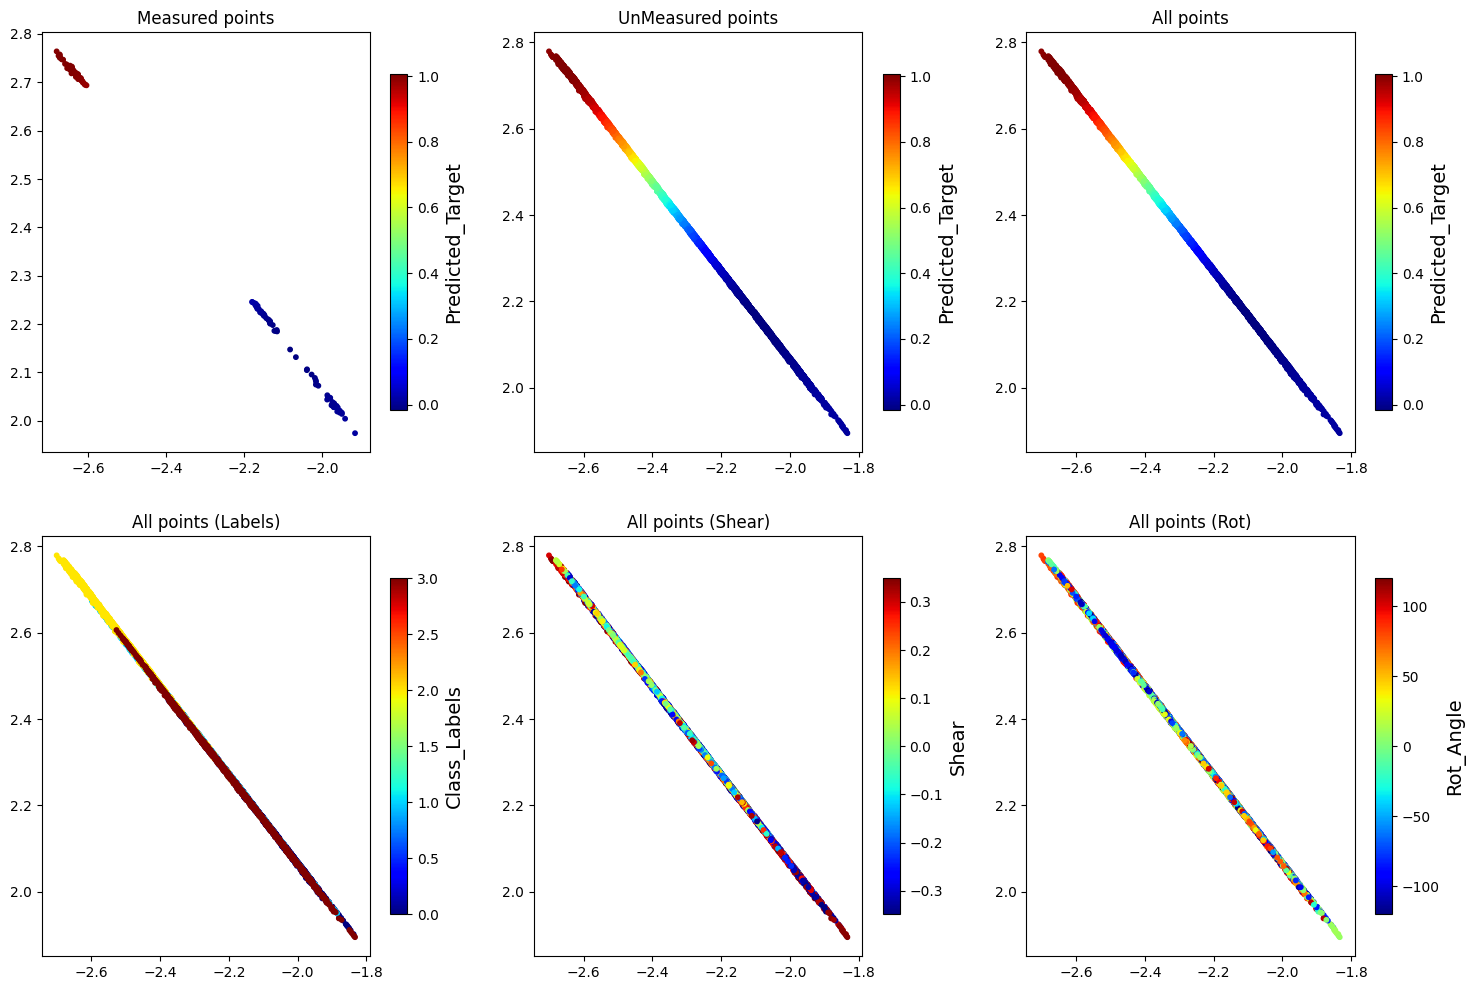

In [38]:
embeded_train2 = dkl_BO_2.embed(X2_train)  # Measured points
embeded_unmeasured2 = dkl_BO_2.embed(X2_unmeasured)  # Unmeasured points
embeded12 = dkl_BO_2.embed(X2)   # All points

fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (18,12))

im = ax[0,0].scatter(embeded_train2[:, 1], embeded_train2[:, 0], s=10, c = predmean_train2, cmap = 'jet')
ax[0,0].set_title('Measured points')
cbar = fig.colorbar(im, ax=ax[0,0], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,1].scatter(embeded_unmeasured2[:, 1], embeded_unmeasured2[:, 0], s=10,
                c = predmean_unmeas2, cmap = 'jet')
ax[0,1].set_title('UnMeasured points')
cbar = fig.colorbar(im, ax=ax[0,1], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,2].scatter(embeded12[:, 1], embeded12[:, 0], s=10, c = predmean12, cmap = 'jet')
ax[0,2].set_title('All points')
cbar = fig.colorbar(im, ax=ax[0,2], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,0].scatter(embeded12[:, 1], embeded12[:, 0], s=10, c = labels_all, cmap = 'jet')
ax[1,0].set_title('All points (Labels)')
cbar = fig.colorbar(im, ax=ax[1,0], shrink=.8)
cbar.set_label("Class_Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,1].scatter(embeded12[:, 1], embeded12[:, 0], s=10, c = shears_all[:,0], cmap = 'jet')
ax[1,1].set_title('All points (Shear)')
cbar = fig.colorbar(im, ax=ax[1,1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,2].scatter(embeded12[:, 1], embeded12[:, 0], s=10, c = angles_all, cmap = 'jet')
ax[1,2].set_title('All points (Rot)')
cbar = fig.colorbar(im, ax=ax[1,2], shrink=.8)
cbar.set_label("Rot_Angle", fontsize=14)
cbar.ax.tick_params(labelsize=10)

Here, active learning produced much better manifolds. Instead of competing for the sam ereal estate in the latent space, active learning focussed attention on the attribute we are interested in (i.e. how close is the image to being a heart)

## Diamonds

And for completeness, diamonds.

In [39]:
X3 = np.copy(X)
targets3 = np.zeros(len(labels_all))
targets3[labels_all == 3] = 1

rng_key_3, rng_key_predict_3 = gpax.utils.get_keys()
dkl_3 = gpax.viDKL(900, 2, 'RBF')
dkl_3.fit(rng_key_3, X3, targets3)

100%|██████████| 1000/1000 [02:40<00:00,  6.21it/s, init loss: 69173.1072, avg. loss [951-1000]: 45604.3596]



Inferred GP kernel parameters
k_length         [1.6476 1.2194]
k_scale          0.3405
noise            0.0081


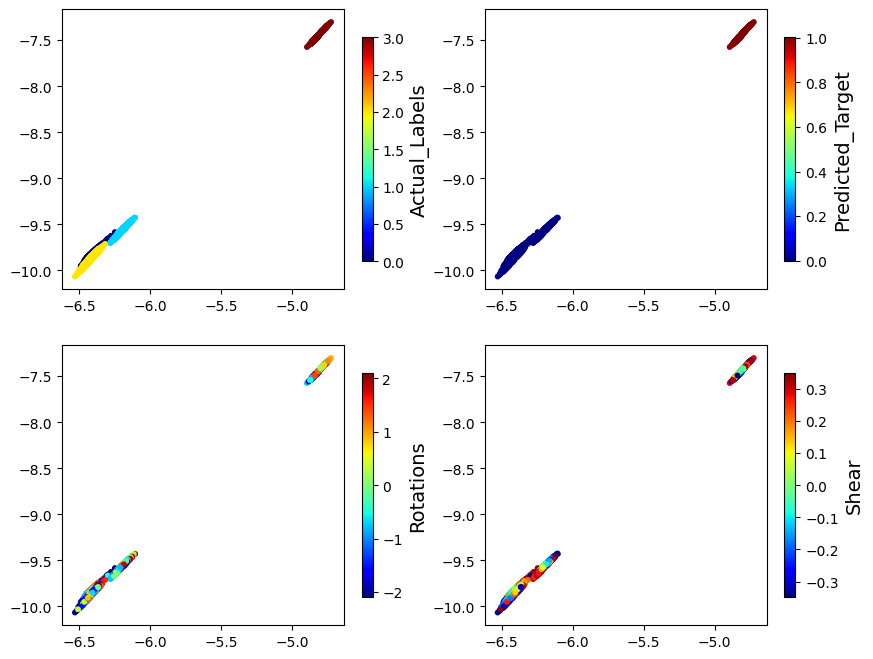

In [40]:
embeded_3 = dkl_3.embed(X3)
pred_mean3, pred_var3 = dkl_3.predict_in_batches(rng_key_predict_3, X3, batch_size=batch_size_reconstruct)
pred_std3 = jnp.sqrt(pred_var3)

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10,8))

im = ax[0,0].scatter(embeded_3[:, 1], embeded_3[:, 0], s=10, c = labels_all, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,0], shrink=.8)
cbar.set_label("Actual_Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,1].scatter(embeded_3[:, 1], embeded_3[:, 0], s=10, c = pred_mean3, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,1], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,0].scatter(embeded_3[:, 1], embeded_3[:, 0], s=10, c = torch.deg2rad(angles_all),
                     cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,0], shrink=.8)
cbar.set_label("Rotations", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,1].scatter(embeded_3[:, 1], embeded_3[:, 0], s=10, c = shears_all[:,0], cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)

Here again we see relatively simple latent distribution. Diamonds are well separated form other three hands in the latent space. As before, good separation based on one attribute means poor disentanglement on other fatcors of variability.

In [41]:
np.random.seed(0)
idx3 = np.random.choice(np.arange(len(X3)), size = init_num, replace = False)
X3_train = X3[idx3]
X3_unmeasured = np.delete(X3, idx3, axis=0)

indices_total_3 = np.arange(len(X))
indices_train_3 = indices_total_3[idx3]
y3_train = targets3[idx3]
indices_unmeasured_3 = np.delete(indices_total_3, idx3)

In [42]:
exp_mean3, exp_std3 = [], []
dkl_mean3, dkl_std3 = [], []
embed_traj3 = []
traj_mean3, traj_std3 = [], []

exploration_steps = 70


for e in range(exploration_steps):
    print("\nStep {}".format(e+1))
    # Obtain/update DKL posterior
    rng_key13, rng_key_predict13 = gpax.utils.get_keys()
    dkl_BO_3 = gpax.viDKL(900, 2, 'RBF')
    dkl_BO_3.fit(rng_key13, X3_train, y3_train)
    # Compute acqusition function
    y_mean, y_var = dkl_BO_3.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        rng_key_predict13, X3_unmeasured, batch_size=250)
    y_std = jnp.sqrt(y_var)
    obj = y_mean + 10 * y_std  # UCB = mu + 10 * sigma
    # Get the next point to evaluate
    id_next = obj.argmax()

    # let's get the mean and std of the next point predicted by dkl_BO
    exp_mean3.append(y_mean[id_next])
    exp_std3.append(y_std[id_next])

    x_next = X3_unmeasured[id_next]
    ind_next = indices_unmeasured_3[id_next]

    # Getting the mean and std of the next point as predicted by the dkl trained on the full dataset
    dkl_mean3.append(pred_mean3[ind_next])
    dkl_std3.append(pred_std3[ind_next])

    # Perform evaluation
#     y_measured = eval_ferrosim(x_next)
    # For now we will only read out the brute force results
    y_measured = targets3[ind_next]

    # Update training arrays
    X3_train = np.append(X3_train, x_next[None], axis=0)
    y3_train = np.append(y3_train, y_measured)
    X3_unmeasured = np.delete(X3_unmeasured, id_next, axis=0)
    indices_unmeasured_3 = np.delete(indices_unmeasured_3, id_next)

    embed_traj = dkl_BO_3.embed(X3_train)
    traj_m, traj_s = dkl_BO_3.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        rng_key_predict13, X3_train, batch_size=batch_size_learn)

    embed_traj3.append(embed_traj)
    traj_mean3.append(traj_m)


Step 1


100%|██████████| 1000/1000 [00:02<00:00, 377.45it/s, init loss: 60100.8959, avg. loss [951-1000]: 56926.1339]



Inferred GP kernel parameters
k_length         [0.3679 0.3004]
k_scale          0.5269
noise            0.014400000000000001

Step 2


100%|██████████| 1000/1000 [00:02<00:00, 388.67it/s, init loss: 60102.1402, avg. loss [951-1000]: 56921.4002]



Inferred GP kernel parameters
k_length         [0.3679 0.3205]
k_scale          0.4117
noise            0.013000000000000001

Step 3


100%|██████████| 1000/1000 [00:02<00:00, 369.25it/s, init loss: 60103.3845, avg. loss [951-1000]: 56928.6515]



Inferred GP kernel parameters
k_length         [0.3935 0.3521]
k_scale          0.371
noise            0.0125

Step 4


100%|██████████| 1000/1000 [00:02<00:00, 385.76it/s, init loss: 60104.8896, avg. loss [951-1000]: 56928.5311]



Inferred GP kernel parameters
k_length         [0.3679 0.2875]
k_scale          0.35850000000000004
noise            0.0165

Step 5


100%|██████████| 1000/1000 [00:02<00:00, 391.75it/s, init loss: 60106.1159, avg. loss [951-1000]: 56917.8462]



Inferred GP kernel parameters
k_length         [0.3678 0.3225]
k_scale          0.4053
noise            0.0122

Step 6


100%|██████████| 1000/1000 [00:02<00:00, 383.96it/s, init loss: 60107.3560, avg. loss [951-1000]: 56915.5491]



Inferred GP kernel parameters
k_length         [0.3679 0.3013]
k_scale          0.436
noise            0.011600000000000001

Step 7


100%|██████████| 1000/1000 [00:02<00:00, 385.18it/s, init loss: 60108.5332, avg. loss [951-1000]: 56914.1736]



Inferred GP kernel parameters
k_length         [0.3678 0.2927]
k_scale          0.44010000000000005
noise            0.011300000000000001

Step 8


100%|██████████| 1000/1000 [00:02<00:00, 386.74it/s, init loss: 60109.7679, avg. loss [951-1000]: 56913.5907]



Inferred GP kernel parameters
k_length         [0.3669 0.3207]
k_scale          0.4062
noise            0.011300000000000001

Step 9


100%|██████████| 1000/1000 [00:02<00:00, 376.28it/s, init loss: 60111.2720, avg. loss [951-1000]: 56912.0212]



Inferred GP kernel parameters
k_length         [0.3678 0.3232]
k_scale          0.40540000000000004
noise            0.0108

Step 10


100%|██████████| 1000/1000 [00:02<00:00, 375.83it/s, init loss: 60112.5152, avg. loss [951-1000]: 56911.7636]



Inferred GP kernel parameters
k_length         [0.3683 0.3433]
k_scale          0.3972
noise            0.0111

Step 11


100%|██████████| 1000/1000 [00:02<00:00, 376.43it/s, init loss: 60113.9921, avg. loss [951-1000]: 56908.8200]



Inferred GP kernel parameters
k_length         [0.2945 0.3679]
k_scale          0.437
noise            0.0106

Step 12


100%|██████████| 1000/1000 [00:02<00:00, 362.91it/s, init loss: 60115.4186, avg. loss [951-1000]: 56908.6736]



Inferred GP kernel parameters
k_length         [0.3627 0.3426]
k_scale          0.39730000000000004
noise            0.010700000000000001

Step 13


100%|██████████| 1000/1000 [00:02<00:00, 403.75it/s, init loss: 60116.8772, avg. loss [951-1000]: 56907.1507]



Inferred GP kernel parameters
k_length         [0.3192 0.3677]
k_scale          0.3985
noise            0.010400000000000001

Step 14


100%|██████████| 1000/1000 [00:02<00:00, 401.90it/s, init loss: 60118.1023, avg. loss [951-1000]: 56908.7709]



Inferred GP kernel parameters
k_length         [0.3638 0.3413]
k_scale          0.3874
noise            0.0106

Step 15


100%|██████████| 1000/1000 [00:02<00:00, 394.59it/s, init loss: 60119.3466, avg. loss [951-1000]: 56911.4898]



Inferred GP kernel parameters
k_length         [0.3679 0.2939]
k_scale          0.41290000000000004
noise            0.0115

Step 16


100%|██████████| 1000/1000 [00:02<00:00, 393.10it/s, init loss: 60120.5745, avg. loss [951-1000]: 56916.5300]



Inferred GP kernel parameters
k_length         [0.3791 0.342 ]
k_scale          0.3587
noise            0.012700000000000001

Step 17


100%|██████████| 1000/1000 [00:02<00:00, 395.64it/s, init loss: 60121.8188, avg. loss [951-1000]: 56900.5574]



Inferred GP kernel parameters
k_length         [0.3679 0.3031]
k_scale          0.4345
noise            0.0097

Step 18


100%|██████████| 1000/1000 [00:02<00:00, 392.99it/s, init loss: 60123.2877, avg. loss [951-1000]: 56986.0954]



Inferred GP kernel parameters
k_length         [0.2749 0.4702]
k_scale          0.2419
noise            0.0176

Step 19


100%|██████████| 1000/1000 [00:02<00:00, 397.35it/s, init loss: 60124.5131, avg. loss [951-1000]: 56899.2664]



Inferred GP kernel parameters
k_length         [0.3619 0.3598]
k_scale          0.3865
noise            0.0099

Step 20


100%|██████████| 1000/1000 [00:02<00:00, 400.92it/s, init loss: 60126.0183, avg. loss [951-1000]: 56897.3303]



Inferred GP kernel parameters
k_length         [0.3676 0.3092]
k_scale          0.3916
noise            0.009600000000000001

Step 21


100%|██████████| 1000/1000 [00:02<00:00, 396.00it/s, init loss: 60127.1921, avg. loss [951-1000]: 56904.3619]



Inferred GP kernel parameters
k_length         [0.3675 0.2744]
k_scale          0.393
noise            0.010700000000000001

Step 22


100%|██████████| 1000/1000 [00:02<00:00, 401.70it/s, init loss: 60128.4338, avg. loss [951-1000]: 56896.4888]



Inferred GP kernel parameters
k_length         [0.3994 0.4163]
k_scale          0.3648
noise            0.0098

Step 23


100%|██████████| 1000/1000 [00:02<00:00, 404.32it/s, init loss: 60129.9397, avg. loss [951-1000]: 56892.5810]



Inferred GP kernel parameters
k_length         [0.3254 0.3619]
k_scale          0.4181
noise            0.0094

Step 24


100%|██████████| 1000/1000 [00:02<00:00, 397.06it/s, init loss: 60131.2590, avg. loss [951-1000]: 56894.2404]



Inferred GP kernel parameters
k_length         [0.4356 0.4847]
k_scale          0.3468
noise            0.010100000000000001

Step 25


100%|██████████| 1000/1000 [00:02<00:00, 395.83it/s, init loss: 60132.5029, avg. loss [951-1000]: 56891.3414]



Inferred GP kernel parameters
k_length         [0.3679 0.3285]
k_scale          0.3599
noise            0.0095

Step 26


100%|██████████| 1000/1000 [00:02<00:00, 399.59it/s, init loss: 60133.7313, avg. loss [951-1000]: 56887.9804]



Inferred GP kernel parameters
k_length         [0.313  0.3645]
k_scale          0.43010000000000004
noise            0.0092

Step 27


100%|██████████| 1000/1000 [00:02<00:00, 392.20it/s, init loss: 60135.2365, avg. loss [951-1000]: 56894.4184]



Inferred GP kernel parameters
k_length         [0.3847 0.3791]
k_scale          0.3468
noise            0.0108

Step 28


100%|██████████| 1000/1000 [00:02<00:00, 397.54it/s, init loss: 60136.4805, avg. loss [951-1000]: 56891.1852]



Inferred GP kernel parameters
k_length         [0.37   0.3306]
k_scale          0.38330000000000003
noise            0.0097

Step 29


100%|██████████| 1000/1000 [00:02<00:00, 388.59it/s, init loss: 60137.9740, avg. loss [951-1000]: 56885.3537]



Inferred GP kernel parameters
k_length         [0.3296 0.3675]
k_scale          0.3834
noise            0.009300000000000001

Step 30


100%|██████████| 1000/1000 [00:02<00:00, 387.33it/s, init loss: 60139.3803, avg. loss [951-1000]: 56886.1705]



Inferred GP kernel parameters
k_length         [0.4778 0.3964]
k_scale          0.35750000000000004
noise            0.0098

Step 31


100%|██████████| 1000/1000 [00:02<00:00, 388.33it/s, init loss: 60140.8662, avg. loss [951-1000]: 56880.6921]



Inferred GP kernel parameters
k_length         [0.3339 0.3344]
k_scale          0.43720000000000003
noise            0.009000000000000001

Step 32


100%|██████████| 1000/1000 [00:03<00:00, 252.50it/s, init loss: 60142.3103, avg. loss [951-1000]: 56900.6404]



Inferred GP kernel parameters
k_length         [0.3286 0.3067]
k_scale          0.4017
noise            0.010100000000000001

Step 33


100%|██████████| 1000/1000 [00:02<00:00, 385.76it/s, init loss: 60143.7230, avg. loss [951-1000]: 56880.4105]



Inferred GP kernel parameters
k_length         [0.3803 0.3631]
k_scale          0.3649
noise            0.0092

Step 34


100%|██████████| 1000/1000 [00:02<00:00, 393.08it/s, init loss: 60144.9672, avg. loss [951-1000]: 56881.2352]



Inferred GP kernel parameters
k_length         [0.4043 0.3913]
k_scale          0.35950000000000004
noise            0.0095

Step 35


100%|██████████| 1000/1000 [00:02<00:00, 391.07it/s, init loss: 60146.4711, avg. loss [951-1000]: 56924.6737]



Inferred GP kernel parameters
k_length         [0.5296 0.4971]
k_scale          0.28340000000000004
noise            0.0103

Step 36


100%|██████████| 1000/1000 [00:02<00:00, 393.90it/s, init loss: 60147.7133, avg. loss [951-1000]: 56879.5334]



Inferred GP kernel parameters
k_length         [0.3782 0.3592]
k_scale          0.35900000000000004
noise            0.0091

Step 37


100%|██████████| 1000/1000 [00:02<00:00, 396.40it/s, init loss: 60149.1364, avg. loss [951-1000]: 56875.0212]



Inferred GP kernel parameters
k_length         [0.4385 0.3908]
k_scale          0.3633
noise            0.0091

Step 38


100%|██████████| 1000/1000 [00:02<00:00, 390.32it/s, init loss: 60150.4517, avg. loss [951-1000]: 56874.1639]



Inferred GP kernel parameters
k_length         [0.3887 0.3623]
k_scale          0.3653
noise            0.0092

Step 39


100%|██████████| 1000/1000 [00:02<00:00, 390.96it/s, init loss: 60151.9504, avg. loss [951-1000]: 56883.3290]



Inferred GP kernel parameters
k_length         [0.3815 0.3001]
k_scale          0.3582
noise            0.011000000000000001

Step 40


100%|██████████| 1000/1000 [00:02<00:00, 395.47it/s, init loss: 60153.1954, avg. loss [951-1000]: 56870.3062]



Inferred GP kernel parameters
k_length         [0.3538 0.3898]
k_scale          0.3718
noise            0.009000000000000001

Step 41


100%|██████████| 1000/1000 [00:02<00:00, 404.18it/s, init loss: 60154.4216, avg. loss [951-1000]: 56888.3182]



Inferred GP kernel parameters
k_length         [0.5415 0.4167]
k_scale          0.2659
noise            0.0114

Step 42


100%|██████████| 1000/1000 [00:02<00:00, 397.52it/s, init loss: 60155.6527, avg. loss [951-1000]: 56871.1177]



Inferred GP kernel parameters
k_length         [0.2922 0.3679]
k_scale          0.3174
noise            0.0094

Step 43


100%|██████████| 1000/1000 [00:02<00:00, 393.69it/s, init loss: 60156.8966, avg. loss [951-1000]: 56864.2848]



Inferred GP kernel parameters
k_length         [0.3679 0.3034]
k_scale          0.4142
noise            0.0088

Step 44


100%|██████████| 1000/1000 [00:02<00:00, 379.72it/s, init loss: 60158.2996, avg. loss [951-1000]: 56865.7748]



Inferred GP kernel parameters
k_length         [0.3966 0.3904]
k_scale          0.368
noise            0.0092

Step 45


100%|██████████| 1000/1000 [00:02<00:00, 378.09it/s, init loss: 60159.8014, avg. loss [951-1000]: 56887.0818]



Inferred GP kernel parameters
k_length         [0.3951 0.4085]
k_scale          0.3592
noise            0.0099

Step 46


100%|██████████| 1000/1000 [00:02<00:00, 399.80it/s, init loss: 60161.2595, avg. loss [951-1000]: 56867.6614]



Inferred GP kernel parameters
k_length         [0.4304 0.3534]
k_scale          0.3285
noise            0.0089

Step 47


100%|██████████| 1000/1000 [00:02<00:00, 406.85it/s, init loss: 60162.7657, avg. loss [951-1000]: 56868.1820]



Inferred GP kernel parameters
k_length         [0.4378 0.443 ]
k_scale          0.319
noise            0.0094

Step 48


100%|██████████| 1000/1000 [00:02<00:00, 396.26it/s, init loss: 60164.2708, avg. loss [951-1000]: 56868.6249]



Inferred GP kernel parameters
k_length         [0.4062 0.4147]
k_scale          0.3336
noise            0.0092

Step 49


100%|██████████| 1000/1000 [00:02<00:00, 403.22it/s, init loss: 60165.5714, avg. loss [951-1000]: 56865.0869]



Inferred GP kernel parameters
k_length         [0.4411 0.4323]
k_scale          0.3178
noise            0.0094

Step 50


100%|██████████| 1000/1000 [00:02<00:00, 397.73it/s, init loss: 60167.0719, avg. loss [951-1000]: 57011.3854]



Inferred GP kernel parameters
k_length         [0.5004 0.3824]
k_scale          0.24880000000000002
noise            0.0129

Step 51


100%|██████████| 1000/1000 [00:02<00:00, 396.36it/s, init loss: 60168.5661, avg. loss [951-1000]: 56855.2223]



Inferred GP kernel parameters
k_length         [0.3368 0.3684]
k_scale          0.36210000000000003
noise            0.008700000000000001

Step 52


100%|██████████| 1000/1000 [00:02<00:00, 396.63it/s, init loss: 60169.7415, avg. loss [951-1000]: 56855.5163]



Inferred GP kernel parameters
k_length         [0.3705 0.3265]
k_scale          0.4073
noise            0.0092

Step 53


100%|██████████| 1000/1000 [00:02<00:00, 398.35it/s, init loss: 60170.9682, avg. loss [951-1000]: 56852.7944]



Inferred GP kernel parameters
k_length         [0.3408 0.3695]
k_scale          0.3607
noise            0.0089

Step 54


100%|██████████| 1000/1000 [00:02<00:00, 397.20it/s, init loss: 60172.2238, avg. loss [951-1000]: 56861.5949]



Inferred GP kernel parameters
k_length         [0.56   0.4924]
k_scale          0.30010000000000003
noise            0.009300000000000001

Step 55


100%|██████████| 1000/1000 [00:02<00:00, 397.27it/s, init loss: 60173.7287, avg. loss [951-1000]: 56850.3592]



Inferred GP kernel parameters
k_length         [0.3517 0.3769]
k_scale          0.36060000000000003
noise            0.0089

Step 56


100%|██████████| 1000/1000 [00:02<00:00, 396.44it/s, init loss: 60175.2339, avg. loss [951-1000]: 56848.7363]



Inferred GP kernel parameters
k_length         [0.3762 0.3666]
k_scale          0.35760000000000003
noise            0.0089

Step 57


100%|██████████| 1000/1000 [00:02<00:00, 391.15it/s, init loss: 60176.4735, avg. loss [951-1000]: 56844.4451]



Inferred GP kernel parameters
k_length         [0.3173 0.3293]
k_scale          0.4315
noise            0.008400000000000001

Step 58


100%|██████████| 1000/1000 [00:02<00:00, 399.79it/s, init loss: 60177.9252, avg. loss [951-1000]: 56851.1133]



Inferred GP kernel parameters
k_length         [0.4124 0.4427]
k_scale          0.32220000000000004
noise            0.0092

Step 59


100%|██████████| 1000/1000 [00:02<00:00, 403.64it/s, init loss: 60179.1617, avg. loss [951-1000]: 56886.5519]



Inferred GP kernel parameters
k_length         [0.5139 0.4589]
k_scale          0.23320000000000002
noise            0.0132

Step 60


100%|██████████| 1000/1000 [00:02<00:00, 404.74it/s, init loss: 60180.5423, avg. loss [951-1000]: 56842.8591]



Inferred GP kernel parameters
k_length         [0.395 0.371]
k_scale          0.3582
noise            0.008700000000000001

Step 61


100%|██████████| 1000/1000 [00:02<00:00, 400.85it/s, init loss: 60181.8094, avg. loss [951-1000]: 57044.9263]



Inferred GP kernel parameters
k_length         [0.4118 0.2789]
k_scale          0.3899
noise            0.0166

Step 62


100%|██████████| 1000/1000 [00:02<00:00, 399.11it/s, init loss: 60183.0243, avg. loss [951-1000]: 56847.3982]



Inferred GP kernel parameters
k_length         [0.4008 0.3853]
k_scale          0.3135
noise            0.009000000000000001

Step 63


100%|██████████| 1000/1000 [00:02<00:00, 396.56it/s, init loss: 60184.1857, avg. loss [951-1000]: 56837.0119]



Inferred GP kernel parameters
k_length         [0.3365 0.3937]
k_scale          0.3931
noise            0.0085

Step 64


100%|██████████| 1000/1000 [00:02<00:00, 398.08it/s, init loss: 60185.5060, avg. loss [951-1000]: 56839.2343]



Inferred GP kernel parameters
k_length         [0.3825 0.3842]
k_scale          0.34800000000000003
noise            0.009000000000000001

Step 65


100%|██████████| 1000/1000 [00:02<00:00, 392.25it/s, init loss: 60186.7200, avg. loss [951-1000]: 56855.2524]



Inferred GP kernel parameters
k_length         [0.3863 0.4627]
k_scale          0.3019
noise            0.0097

Step 66


100%|██████████| 1000/1000 [00:02<00:00, 404.58it/s, init loss: 60187.9643, avg. loss [951-1000]: 56839.1059]



Inferred GP kernel parameters
k_length         [0.3359 0.3685]
k_scale          0.33140000000000003
noise            0.009000000000000001

Step 67


100%|██████████| 1000/1000 [00:02<00:00, 395.68it/s, init loss: 60189.3332, avg. loss [951-1000]: 56843.1510]



Inferred GP kernel parameters
k_length         [0.4796 0.4126]
k_scale          0.3128
noise            0.0102

Step 68


100%|██████████| 1000/1000 [00:02<00:00, 404.22it/s, init loss: 60190.5775, avg. loss [951-1000]: 56838.3750]



Inferred GP kernel parameters
k_length         [0.3606 0.4037]
k_scale          0.3519
noise            0.0099

Step 69


100%|██████████| 1000/1000 [00:02<00:00, 404.84it/s, init loss: 60191.8381, avg. loss [951-1000]: 56828.3698]



Inferred GP kernel parameters
k_length         [0.3459 0.3761]
k_scale          0.4242
noise            0.008700000000000001

Step 70


100%|██████████| 1000/1000 [00:02<00:00, 392.61it/s, init loss: 60193.2184, avg. loss [951-1000]: 56833.1924]



Inferred GP kernel parameters
k_length         [0.3538 0.3924]
k_scale          0.4166
noise            0.008700000000000001


In [43]:
diams_results = {}
diams_results['X_train'] = X3_train
diams_results['y_train'] = y3_train
diams_results['X_unmeasured'] = X3_unmeasured
diams_results['indices_unmeasured'] = indices_unmeasured_3
diams_results['dkl_mean'] = dkl_mean3
diams_results['dkl_std'] = dkl_std3
diams_results['exp_mean'] = exp_mean3
diams_results['exp_std'] = exp_std3
diams_results['traj_mean'] = traj_mean3
diams_results['traj_std'] = traj_std3
diams_results['embed_traj'] = embed_traj3

with open('diams_results.pickle', 'wb') as handle:
    pickle.dump(diams_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [44]:
with open('diams_results.pickle', 'rb') as f:
    diams_results = pickle.load(f)

X3_train = diams_results['X_train']
y3_train = diams_results['y_train']
X3_unmeasured = diams_results['X_unmeasured']
indices_unmeasured_3 = diams_results['indices_unmeasured']
dkl_mean3 = diams_results['dkl_mean']
dkl_std3 = diams_results['dkl_std']
exp_mean3 = diams_results['exp_mean']
exp_std3 = diams_results['exp_std']
traj_mean3 = diams_results['traj_mean']
traj_std3 = diams_results['traj_std']
embed_traj3 = diams_results['embed_traj']

In [45]:
rng_key13, rng_key_predict13 = gpax.utils.get_keys()
dkl_BO_3 = gpax.viDKL(900, 2, 'RBF')
dkl_BO_3.fit(rng_key13, X3_train, y3_train)

predmean_train3, predstd_train3 = dkl_BO_3.predict_in_batches(rng_key_predict13, X3_train, batch_size=batch_size_learn)
predmean_unmeas3, predstd_unmeas3 = dkl_BO_3.predict_in_batches(rng_key_predict13, X3_unmeasured, batch_size=batch_size_reconstruct)
predmean13, predstd13 = dkl_BO_3.predict_in_batches(rng_key_predict13, X3, batch_size=batch_size_reconstruct)

100%|██████████| 1000/1000 [00:02<00:00, 395.92it/s, init loss: 60194.6410, avg. loss [951-1000]: 56832.1198]



Inferred GP kernel parameters
k_length         [0.3816 0.3848]
k_scale          0.33630000000000004
noise            0.0085


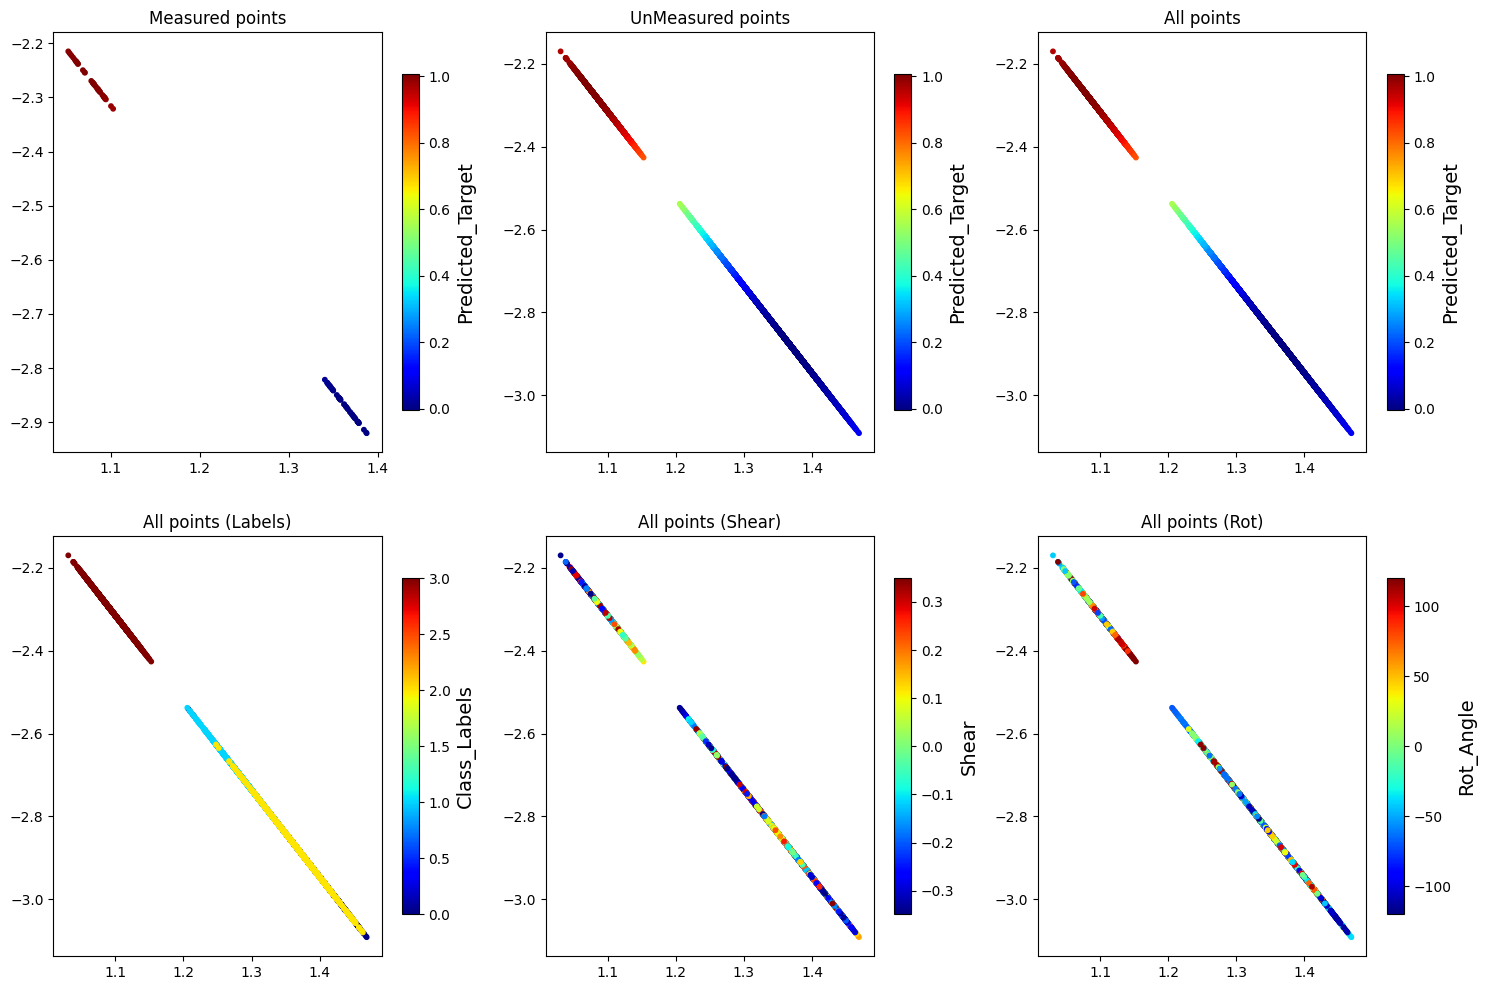

In [46]:
embeded_train3 = dkl_BO_3.embed(X3_train)  # Measured points
embeded_unmeasured3 = dkl_BO_3.embed(X3_unmeasured)  # Unmeasured points
embeded13 = dkl_BO_3.embed(X3)   # All points

fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (18,12))

im = ax[0,0].scatter(embeded_train3[:, 1], embeded_train3[:, 0], s=10, c = predmean_train3, cmap = 'jet')
ax[0,0].set_title('Measured points')
cbar = fig.colorbar(im, ax=ax[0,0], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,1].scatter(embeded_unmeasured3[:, 1], embeded_unmeasured3[:, 0], s=10,
                c = predmean_unmeas3, cmap = 'jet')
ax[0,1].set_title('UnMeasured points')
cbar = fig.colorbar(im, ax=ax[0,1], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,2].scatter(embeded13[:, 1], embeded13[:, 0], s=10, c = predmean13, cmap = 'jet')
ax[0,2].set_title('All points')
cbar = fig.colorbar(im, ax=ax[0,2], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,0].scatter(embeded13[:, 1], embeded13[:, 0], s=10, c = labels_all, cmap = 'jet')
ax[1,0].set_title('All points (Labels)')
cbar = fig.colorbar(im, ax=ax[1,0], shrink=.8)
cbar.set_label("Class_Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,1].scatter(embeded13[:, 1], embeded13[:, 0], s=10, c = shears_all[:,0], cmap = 'jet')
ax[1,1].set_title('All points (Shear)')
cbar = fig.colorbar(im, ax=ax[1,1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,2].scatter(embeded13[:, 1], embeded13[:, 0], s=10, c = angles_all, cmap = 'jet')
ax[1,2].set_title('All points (Rot)')
cbar = fig.colorbar(im, ax=ax[1,2], shrink=.8)
cbar.set_label("Rot_Angle", fontsize=14)
cbar.ax.tick_params(labelsize=10)

# All hands as a function

Now, let's make the problem slightly more interesting. We define the function that puts a number to the hand (meaning hearts are 1, diamonds are 2, etc). This is not a very good way of doing it - since these are cathegorical variables. But as mentioned before, we consider card images as a toy model for more complex scenarios (molecules, process trajectories, etc). So, let's experiment!

In [47]:
X4 = np.copy(X)
targets4 = np.copy((labels_all))

rng_key_4, rng_key_predict_4 = gpax.utils.get_keys()
dkl_4 = gpax.viDKL(900, 2, 'RBF')
dkl_4.fit(rng_key_4, X, targets4)

100%|██████████| 1000/1000 [02:40<00:00,  6.23it/s, init loss: 71939.6664, avg. loss [951-1000]: 45872.7810]



Inferred GP kernel parameters
k_length         [3.1713 2.4948]
k_scale          0.8769
noise            0.0082


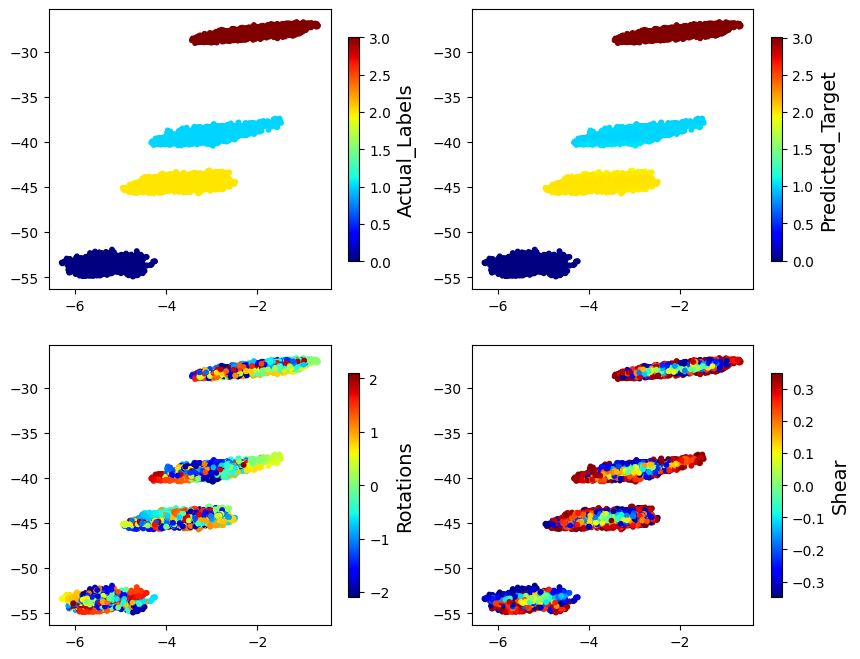

In [48]:
embeded_4 = dkl_4.embed(X)
pred_mean4, pred_var4 = dkl_4.predict_in_batches(rng_key_predict_4, X, batch_size=batch_size_reconstruct)
pred_std4 = jnp.sqrt(pred_var4)

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10,8))

im = ax[0,0].scatter(embeded_4[:, 1], embeded_4[:, 0], s=10, c = labels_all, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,0], shrink=.8)
cbar.set_label("Actual_Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,1].scatter(embeded_4[:, 1], embeded_4[:, 0], s=10, c = pred_mean4, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,1], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,0].scatter(embeded_4[:, 1], embeded_4[:, 0], s=10, c = torch.deg2rad(angles_all),
                     cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,0], shrink=.8)
cbar.set_label("Rotations", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,1].scatter(embeded_4[:, 1], embeded_4[:, 0], s=10, c = shears_all[:,0], cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)

As you can see, our "card function" is well separated in the latent space. Interestingly, we can see the disentanglement of representations for rotations and shear within each cluster.

In [49]:
np.random.seed(0)
idx4 = np.random.choice(np.arange(len(X4)), size = init_num, replace = False)
X4_train = X4[idx4]
X4_unmeasured = np.delete(X4, idx4, axis=0)

indices_total_4 = np.arange(len(X))
indices_train_4 = indices_total_4[idx4]
y4_train = targets4[idx4]
indices_unmeasured_4 = np.delete(indices_total_4, idx4)

In [50]:
exp_mean4, exp_std4 = [], []
dkl_mean4, dkl_std4 = [], []
embed_traj4 = []
traj_mean4, traj_std4 = [], []

exploration_steps = exp_step


for e in range(exploration_steps):
    print("\nStep {}".format(e+1))
    # Obtain/update DKL posterior
    rng_key14, rng_key_predict14 = gpax.utils.get_keys()
    dkl_BO_4 = gpax.viDKL(900, 2, 'RBF')
    dkl_BO_4.fit(rng_key14, X4_train, y4_train)
    # Compute acqusition function
    y_mean, y_var = dkl_BO_4.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        rng_key_predict14, X4_unmeasured, batch_size=250)
    y_std = jnp.sqrt(y_var)
    obj = y_mean + 10 * y_std  # UCB = mu + 10 * sigma
    # Get the next point to evaluate
    id_next = obj.argmax()

    # let's get the mean and std of the next point predicted by dkl_BO
    exp_mean4.append(y_mean[id_next])
    exp_std4.append(y_std[id_next])

    x_next = X4_unmeasured[id_next]
    ind_next = indices_unmeasured_4[id_next]

    # Getting the mean and std of the next point as predicted by the dkl trained on the full dataset
    dkl_mean4.append(pred_mean4[ind_next])
    dkl_std4.append(pred_std4[ind_next])

    # Perform evaluation
#     y_measured = eval_ferrosim(x_next)
    # For now we will only read out the brute force results
    y_measured = targets4[ind_next]

    # Update training arrays
    X4_train = np.append(X4_train, x_next[None], axis=0)
    y4_train = np.append(y4_train, y_measured)
    X4_unmeasured = np.delete(X4_unmeasured, id_next, axis=0)
    indices_unmeasured_4 = np.delete(indices_unmeasured_4, id_next)

    embed_traj = dkl_BO_4.embed(X4_train)
    traj_m, traj_s = dkl_BO_4.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        rng_key_predict14, X4_train, batch_size=batch_size_learn)

    embed_traj4.append(embed_traj)
    traj_mean4.append(traj_m)


Step 1


100%|██████████| 1000/1000 [00:02<00:00, 391.19it/s, init loss: 60115.7527, avg. loss [951-1000]: 56932.9308]



Inferred GP kernel parameters
k_length         [0.3976 0.3619]
k_scale          1.8702
noise            0.016

Step 2


100%|██████████| 1000/1000 [00:02<00:00, 396.62it/s, init loss: 60117.8283, avg. loss [951-1000]: 56937.9799]



Inferred GP kernel parameters
k_length         [0.3773 0.4951]
k_scale          1.4184
noise            0.0183

Step 3


100%|██████████| 1000/1000 [00:02<00:00, 389.66it/s, init loss: 60119.0725, avg. loss [951-1000]: 56943.8594]



Inferred GP kernel parameters
k_length         [0.3743 0.383 ]
k_scale          1.5258
noise            0.0234

Step 4


100%|██████████| 1000/1000 [00:02<00:00, 397.22it/s, init loss: 60121.3578, avg. loss [951-1000]: 56931.0859]



Inferred GP kernel parameters
k_length         [0.4995 0.4747]
k_scale          1.7564000000000002
noise            0.013600000000000001

Step 5


100%|██████████| 1000/1000 [00:02<00:00, 383.29it/s, init loss: 60124.6561, avg. loss [951-1000]: 56926.9186]



Inferred GP kernel parameters
k_length         [0.3973 0.3686]
k_scale          1.8832
noise            0.0137

Step 6


100%|██████████| 1000/1000 [00:02<00:00, 396.11it/s, init loss: 60127.6585, avg. loss [951-1000]: 56927.9205]



Inferred GP kernel parameters
k_length         [0.5332 0.4911]
k_scale          1.7126000000000001
noise            0.014700000000000001

Step 7


100%|██████████| 1000/1000 [00:02<00:00, 382.66it/s, init loss: 60130.6131, avg. loss [951-1000]: 56927.9733]



Inferred GP kernel parameters
k_length         [0.6204 0.5308]
k_scale          1.7510000000000001
noise            0.0155

Step 8


100%|██████████| 1000/1000 [00:02<00:00, 382.98it/s, init loss: 60133.5646, avg. loss [951-1000]: 56924.2214]



Inferred GP kernel parameters
k_length         [0.4255 0.3774]
k_scale          1.8723
noise            0.014100000000000001

Step 9


100%|██████████| 1000/1000 [00:02<00:00, 377.45it/s, init loss: 60137.1536, avg. loss [951-1000]: 56943.8639]



Inferred GP kernel parameters
k_length         [0.5411 0.5093]
k_scale          1.6242
noise            0.015600000000000001

Step 10


100%|██████████| 1000/1000 [00:02<00:00, 373.39it/s, init loss: 60138.6587, avg. loss [951-1000]: 56923.0777]



Inferred GP kernel parameters
k_length         [0.9538 0.6199]
k_scale          1.6441000000000001
noise            0.0142

Step 11


100%|██████████| 1000/1000 [00:02<00:00, 370.86it/s, init loss: 60140.9597, avg. loss [951-1000]: 56920.9925]



Inferred GP kernel parameters
k_length         [0.515  0.7053]
k_scale          1.7839
noise            0.012700000000000001

Step 12


100%|██████████| 1000/1000 [00:02<00:00, 368.28it/s, init loss: 60143.8323, avg. loss [951-1000]: 56947.7993]



Inferred GP kernel parameters
k_length         [0.8003 0.8938]
k_scale          1.4654
noise            0.0175

Step 13


100%|██████████| 1000/1000 [00:02<00:00, 392.71it/s, init loss: 60145.0766, avg. loss [951-1000]: 56923.1664]



Inferred GP kernel parameters
k_length         [0.5642 0.4254]
k_scale          1.6997
noise            0.0122

Step 14


100%|██████████| 1000/1000 [00:02<00:00, 400.70it/s, init loss: 60146.3209, avg. loss [951-1000]: 56920.3217]



Inferred GP kernel parameters
k_length         [0.9774 0.7861]
k_scale          1.5503
noise            0.0143

Step 15


100%|██████████| 1000/1000 [00:02<00:00, 403.33it/s, init loss: 60148.9101, avg. loss [951-1000]: 56914.9862]



Inferred GP kernel parameters
k_length         [0.4351 0.4189]
k_scale          1.8231000000000002
noise            0.011000000000000001

Step 16


100%|██████████| 1000/1000 [00:02<00:00, 398.54it/s, init loss: 60152.1208, avg. loss [951-1000]: 56948.0229]



Inferred GP kernel parameters
k_length         [0.5465 0.6766]
k_scale          1.4463000000000001
noise            0.0145

Step 17


100%|██████████| 1000/1000 [00:02<00:00, 405.34it/s, init loss: 60153.3893, avg. loss [951-1000]: 56916.3006]



Inferred GP kernel parameters
k_length         [0.6342 0.5664]
k_scale          1.6134000000000002
noise            0.0117

Step 18


100%|██████████| 1000/1000 [00:02<00:00, 402.58it/s, init loss: 60156.6834, avg. loss [951-1000]: 56912.7062]



Inferred GP kernel parameters
k_length         [0.5452 0.5722]
k_scale          1.6253
noise            0.009600000000000001

Step 19


100%|██████████| 1000/1000 [00:02<00:00, 403.71it/s, init loss: 60160.1764, avg. loss [951-1000]: 56910.2204]



Inferred GP kernel parameters
k_length         [0.6729 0.6413]
k_scale          1.6768
noise            0.0105

Step 20


100%|██████████| 1000/1000 [00:02<00:00, 397.13it/s, init loss: 60164.0284, avg. loss [951-1000]: 56910.8065]



Inferred GP kernel parameters
k_length         [0.5413 0.5793]
k_scale          1.6097000000000001
noise            0.0109

Step 21


100%|██████████| 1000/1000 [00:02<00:00, 402.41it/s, init loss: 60167.0807, avg. loss [951-1000]: 56918.2755]



Inferred GP kernel parameters
k_length         [0.7226 0.8477]
k_scale          1.6108
noise            0.012100000000000001

Step 22


100%|██████████| 1000/1000 [00:02<00:00, 404.41it/s, init loss: 60169.2959, avg. loss [951-1000]: 56904.2243]



Inferred GP kernel parameters
k_length         [0.5147 0.4482]
k_scale          1.7790000000000001
noise            0.0094

Step 23


100%|██████████| 1000/1000 [00:02<00:00, 399.47it/s, init loss: 60172.8957, avg. loss [951-1000]: 56912.4075]



Inferred GP kernel parameters
k_length         [0.6528 0.6305]
k_scale          1.5621
noise            0.0109

Step 24


100%|██████████| 1000/1000 [00:02<00:00, 401.30it/s, init loss: 60176.5698, avg. loss [951-1000]: 56912.7256]



Inferred GP kernel parameters
k_length         [0.8439 0.7031]
k_scale          1.5192
noise            0.0117

Step 25


100%|██████████| 1000/1000 [00:02<00:00, 403.55it/s, init loss: 60179.2996, avg. loss [951-1000]: 56931.8922]



Inferred GP kernel parameters
k_length         [0.8819 0.8276]
k_scale          1.4221000000000001
noise            0.0123

Step 26


100%|██████████| 1000/1000 [00:02<00:00, 398.55it/s, init loss: 60180.6081, avg. loss [951-1000]: 56904.8671]



Inferred GP kernel parameters
k_length         [0.6242 0.5744]
k_scale          1.6547
noise            0.0097

Step 27


100%|██████████| 1000/1000 [00:02<00:00, 396.52it/s, init loss: 60183.1812, avg. loss [951-1000]: 56910.2335]



Inferred GP kernel parameters
k_length         [0.7835 0.7272]
k_scale          1.4563000000000001
noise            0.0108

Step 28


100%|██████████| 1000/1000 [00:02<00:00, 396.12it/s, init loss: 60186.7564, avg. loss [951-1000]: 56903.6296]



Inferred GP kernel parameters
k_length         [0.6393 0.6823]
k_scale          1.6216000000000002
noise            0.0109

Step 29


100%|██████████| 1000/1000 [00:02<00:00, 398.81it/s, init loss: 60189.0626, avg. loss [951-1000]: 56905.9493]



Inferred GP kernel parameters
k_length         [0.5828 0.4822]
k_scale          1.5639
noise            0.0106

Step 30


100%|██████████| 1000/1000 [00:02<00:00, 393.93it/s, init loss: 60192.4816, avg. loss [951-1000]: 56896.1110]



Inferred GP kernel parameters
k_length         [0.6053 0.554 ]
k_scale          1.7444000000000002
noise            0.0099

Step 31


100%|██████████| 1000/1000 [00:02<00:00, 396.67it/s, init loss: 60195.4186, avg. loss [951-1000]: 56905.0333]



Inferred GP kernel parameters
k_length         [0.574  0.5485]
k_scale          1.6276000000000002
noise            0.0119

Step 32


100%|██████████| 1000/1000 [00:02<00:00, 402.04it/s, init loss: 60198.0600, avg. loss [951-1000]: 56894.9386]



Inferred GP kernel parameters
k_length         [0.8866 0.8148]
k_scale          1.5445
noise            0.0106

Step 33


100%|██████████| 1000/1000 [00:02<00:00, 389.90it/s, init loss: 60201.6533, avg. loss [951-1000]: 56908.1212]



Inferred GP kernel parameters
k_length         [0.9364 0.8869]
k_scale          1.3477000000000001
noise            0.0112

Step 34


100%|██████████| 1000/1000 [00:02<00:00, 394.38it/s, init loss: 60202.8975, avg. loss [951-1000]: 56893.9206]



Inferred GP kernel parameters
k_length         [0.7268 0.6403]
k_scale          1.5069000000000001
noise            0.0112

Step 35


100%|██████████| 1000/1000 [00:02<00:00, 399.79it/s, init loss: 60206.5207, avg. loss [951-1000]: 56897.0849]



Inferred GP kernel parameters
k_length         [0.6237 0.7321]
k_scale          1.6501000000000001
noise            0.010400000000000001

Step 36


100%|██████████| 1000/1000 [00:02<00:00, 394.24it/s, init loss: 60209.6459, avg. loss [951-1000]: 56902.2326]



Inferred GP kernel parameters
k_length         [0.764 0.627]
k_scale          1.2836
noise            0.0099

Step 37


100%|██████████| 1000/1000 [00:02<00:00, 395.79it/s, init loss: 60210.8972, avg. loss [951-1000]: 56938.8495]



Inferred GP kernel parameters
k_length         [0.8768 0.8705]
k_scale          1.5781
noise            0.012700000000000001

Step 38


100%|██████████| 1000/1000 [00:03<00:00, 251.70it/s, init loss: 60213.3154, avg. loss [951-1000]: 56898.6474]



Inferred GP kernel parameters
k_length         [0.7892 0.7478]
k_scale          1.4519
noise            0.010400000000000001

Step 39


100%|██████████| 1000/1000 [00:02<00:00, 387.30it/s, init loss: 60216.8986, avg. loss [951-1000]: 56903.2784]



Inferred GP kernel parameters
k_length         [0.9054 0.9536]
k_scale          1.4567
noise            0.0112

Step 40


100%|██████████| 1000/1000 [00:02<00:00, 396.65it/s, init loss: 60219.3655, avg. loss [951-1000]: 56900.3777]



Inferred GP kernel parameters
k_length         [0.9862 0.6636]
k_scale          1.487
noise            0.0112

Step 41


100%|██████████| 1000/1000 [00:02<00:00, 393.83it/s, init loss: 60222.7531, avg. loss [951-1000]: 56879.2153]



Inferred GP kernel parameters
k_length         [0.5734 0.5156]
k_scale          1.6972
noise            0.009000000000000001

Step 42


100%|██████████| 1000/1000 [00:02<00:00, 384.55it/s, init loss: 60225.4382, avg. loss [951-1000]: 56883.4995]



Inferred GP kernel parameters
k_length         [0.7261 0.7771]
k_scale          1.5692000000000002
noise            0.0098

Step 43


100%|██████████| 1000/1000 [00:02<00:00, 402.74it/s, init loss: 60228.0020, avg. loss [951-1000]: 56889.9061]



Inferred GP kernel parameters
k_length         [0.6533 0.5742]
k_scale          1.5337
noise            0.0103

Step 44


100%|██████████| 1000/1000 [00:02<00:00, 377.36it/s, init loss: 60231.5038, avg. loss [951-1000]: 57028.4311]



Inferred GP kernel parameters
k_length         [0.9315 0.8981]
k_scale          1.806
noise            0.0161

Step 45


100%|██████████| 1000/1000 [00:02<00:00, 375.81it/s, init loss: 60233.7670, avg. loss [951-1000]: 56879.7653]



Inferred GP kernel parameters
k_length         [0.6677 0.6199]
k_scale          1.5632000000000001
noise            0.009000000000000001

Step 46


100%|██████████| 1000/1000 [00:02<00:00, 399.65it/s, init loss: 60236.6078, avg. loss [951-1000]: 56890.8404]



Inferred GP kernel parameters
k_length         [0.8626 0.7371]
k_scale          1.5121
noise            0.0105

Step 47


100%|██████████| 1000/1000 [00:02<00:00, 398.22it/s, init loss: 60238.8954, avg. loss [951-1000]: 56891.5767]



Inferred GP kernel parameters
k_length         [1.0912 1.0791]
k_scale          1.5016
noise            0.0106

Step 48


100%|██████████| 1000/1000 [00:02<00:00, 396.76it/s, init loss: 60242.5024, avg. loss [951-1000]: 56880.1016]



Inferred GP kernel parameters
k_length         [0.8258 0.7455]
k_scale          1.4746000000000001
noise            0.0097

Step 49


100%|██████████| 1000/1000 [00:02<00:00, 394.37it/s, init loss: 60244.1188, avg. loss [951-1000]: 56883.1378]



Inferred GP kernel parameters
k_length         [0.7458 0.7308]
k_scale          1.4454
noise            0.0102

Step 50


100%|██████████| 1000/1000 [00:02<00:00, 405.04it/s, init loss: 60246.4144, avg. loss [951-1000]: 56890.8883]



Inferred GP kernel parameters
k_length         [1.0908 1.0916]
k_scale          1.4063
noise            0.0102

Step 51


100%|██████████| 1000/1000 [00:02<00:00, 397.49it/s, init loss: 60249.2544, avg. loss [951-1000]: 56873.4146]



Inferred GP kernel parameters
k_length         [0.7003 0.6034]
k_scale          1.5914000000000001
noise            0.009600000000000001

Step 52


100%|██████████| 1000/1000 [00:02<00:00, 404.17it/s, init loss: 60251.7535, avg. loss [951-1000]: 56874.6839]



Inferred GP kernel parameters
k_length         [0.5131 0.5634]
k_scale          1.6609
noise            0.0095

Step 53


100%|██████████| 1000/1000 [00:02<00:00, 395.96it/s, init loss: 60253.2600, avg. loss [951-1000]: 56869.1827]



Inferred GP kernel parameters
k_length         [0.8924 0.7798]
k_scale          1.4708
noise            0.0094

Step 54


100%|██████████| 1000/1000 [00:02<00:00, 405.53it/s, init loss: 60256.7324, avg. loss [951-1000]: 56874.9872]



Inferred GP kernel parameters
k_length         [1.4229 1.051 ]
k_scale          1.3424
noise            0.010700000000000001

Step 55


100%|██████████| 1000/1000 [00:02<00:00, 400.95it/s, init loss: 60259.4931, avg. loss [951-1000]: 56873.5950]



Inferred GP kernel parameters
k_length         [0.6462 0.676 ]
k_scale          1.5399
noise            0.0097

Step 56


100%|██████████| 1000/1000 [00:02<00:00, 404.10it/s, init loss: 60260.8804, avg. loss [951-1000]: 56860.6686]



Inferred GP kernel parameters
k_length         [0.7837 0.7005]
k_scale          1.4922
noise            0.009000000000000001

Step 57


100%|██████████| 1000/1000 [00:02<00:00, 402.75it/s, init loss: 60263.6488, avg. loss [951-1000]: 56889.0911]



Inferred GP kernel parameters
k_length         [0.7304 0.6865]
k_scale          1.5177
noise            0.009300000000000001

Step 58


100%|██████████| 1000/1000 [00:02<00:00, 400.01it/s, init loss: 60265.0592, avg. loss [951-1000]: 56912.5118]



Inferred GP kernel parameters
k_length         [0.957  0.8166]
k_scale          1.5427000000000002
noise            0.0098

Step 59


100%|██████████| 1000/1000 [00:02<00:00, 403.34it/s, init loss: 60266.4488, avg. loss [951-1000]: 56905.8306]



Inferred GP kernel parameters
k_length         [0.9541 0.8231]
k_scale          1.5135
noise            0.010100000000000001

Step 60


100%|██████████| 1000/1000 [00:02<00:00, 401.70it/s, init loss: 60268.7364, avg. loss [951-1000]: 56869.2941]



Inferred GP kernel parameters
k_length         [1.2551 1.1055]
k_scale          1.4393
noise            0.010400000000000001

Step 61


100%|██████████| 1000/1000 [00:02<00:00, 392.87it/s, init loss: 60272.2874, avg. loss [951-1000]: 56857.3874]



Inferred GP kernel parameters
k_length         [0.8139 0.7233]
k_scale          1.4926000000000001
noise            0.0091

Step 62


100%|██████████| 1000/1000 [00:02<00:00, 398.17it/s, init loss: 60275.2577, avg. loss [951-1000]: 56856.8559]



Inferred GP kernel parameters
k_length         [0.6542 0.5915]
k_scale          1.6518000000000002
noise            0.008700000000000001

Step 63


100%|██████████| 1000/1000 [00:02<00:00, 404.39it/s, init loss: 60277.4002, avg. loss [951-1000]: 56875.4826]



Inferred GP kernel parameters
k_length         [1.0509 0.9517]
k_scale          1.329
noise            0.010100000000000001

Step 64


100%|██████████| 1000/1000 [00:02<00:00, 401.56it/s, init loss: 60280.9991, avg. loss [951-1000]: 56860.8896]



Inferred GP kernel parameters
k_length         [0.8366 0.8316]
k_scale          1.5082
noise            0.008700000000000001

Step 65


100%|██████████| 1000/1000 [00:02<00:00, 401.11it/s, init loss: 60282.5103, avg. loss [951-1000]: 56863.6522]



Inferred GP kernel parameters
k_length         [0.8043 0.7391]
k_scale          1.4603000000000002
noise            0.009300000000000001

Step 66


100%|██████████| 1000/1000 [00:02<00:00, 402.78it/s, init loss: 60283.7222, avg. loss [951-1000]: 56859.9223]



Inferred GP kernel parameters
k_length         [0.7941 0.8854]
k_scale          1.5214
noise            0.0088

Step 67


100%|██████████| 1000/1000 [00:02<00:00, 399.03it/s, init loss: 60286.6730, avg. loss [951-1000]: 56857.5638]



Inferred GP kernel parameters
k_length         [0.9064 0.8984]
k_scale          1.5511000000000001
noise            0.008700000000000001

Step 68


100%|██████████| 1000/1000 [00:02<00:00, 389.38it/s, init loss: 60289.9676, avg. loss [951-1000]: 56848.7246]



Inferred GP kernel parameters
k_length         [0.7703 0.6901]
k_scale          1.587
noise            0.0086

Step 69


100%|██████████| 1000/1000 [00:02<00:00, 402.01it/s, init loss: 60292.1887, avg. loss [951-1000]: 56879.1108]



Inferred GP kernel parameters
k_length         [0.9077 0.7264]
k_scale          1.6680000000000001
noise            0.009600000000000001

Step 70


100%|██████████| 1000/1000 [00:02<00:00, 388.94it/s, init loss: 60293.5331, avg. loss [951-1000]: 56850.2118]



Inferred GP kernel parameters
k_length         [0.9877 0.7703]
k_scale          1.4615
noise            0.0091

Step 71


100%|██████████| 1000/1000 [00:02<00:00, 395.83it/s, init loss: 60296.3328, avg. loss [951-1000]: 56880.5381]



Inferred GP kernel parameters
k_length         [1.2257 1.0367]
k_scale          1.3619
noise            0.0095

Step 72


100%|██████████| 1000/1000 [00:02<00:00, 388.44it/s, init loss: 60299.1124, avg. loss [951-1000]: 56854.1287]



Inferred GP kernel parameters
k_length         [1.8225 1.5792]
k_scale          1.209
noise            0.01

Step 73


100%|██████████| 1000/1000 [00:02<00:00, 399.59it/s, init loss: 60301.4825, avg. loss [951-1000]: 56892.9467]



Inferred GP kernel parameters
k_length         [0.8816 0.7081]
k_scale          1.4362000000000001
noise            0.0092

Step 74


100%|██████████| 1000/1000 [00:02<00:00, 385.20it/s, init loss: 60302.7294, avg. loss [951-1000]: 56837.3858]



Inferred GP kernel parameters
k_length         [0.911  0.8208]
k_scale          1.4157
noise            0.0083

Step 75


100%|██████████| 1000/1000 [00:02<00:00, 399.73it/s, init loss: 60305.0666, avg. loss [951-1000]: 56838.7677]



Inferred GP kernel parameters
k_length         [0.9538 1.0228]
k_scale          1.4653
noise            0.0085

Step 76


100%|██████████| 1000/1000 [00:02<00:00, 389.68it/s, init loss: 60307.1388, avg. loss [951-1000]: 56939.8579]



Inferred GP kernel parameters
k_length         [0.8291 0.8329]
k_scale          1.4111
noise            0.0103

Step 77


100%|██████████| 1000/1000 [00:02<00:00, 392.07it/s, init loss: 60308.3800, avg. loss [951-1000]: 56850.0400]



Inferred GP kernel parameters
k_length         [0.9265 0.9194]
k_scale          1.5497
noise            0.0091

Step 78


100%|██████████| 1000/1000 [00:02<00:00, 394.57it/s, init loss: 60309.7028, avg. loss [951-1000]: 56842.6471]



Inferred GP kernel parameters
k_length         [1.224  1.7055]
k_scale          1.2467000000000001
noise            0.0091

Step 79


100%|██████████| 1000/1000 [00:04<00:00, 244.14it/s, init loss: 60312.0505, avg. loss [951-1000]: 56852.4997]



Inferred GP kernel parameters
k_length         [1.7107 1.5629]
k_scale          1.2049
noise            0.0095

Step 80


100%|██████████| 1000/1000 [00:02<00:00, 396.45it/s, init loss: 60314.0664, avg. loss [951-1000]: 56878.2815]



Inferred GP kernel parameters
k_length         [1.2097 1.2451]
k_scale          1.2781
noise            0.010100000000000001

Step 81


100%|██████████| 1000/1000 [00:02<00:00, 400.13it/s, init loss: 60315.3727, avg. loss [951-1000]: 56861.4551]



Inferred GP kernel parameters
k_length         [1.5744 1.3838]
k_scale          1.3235000000000001
noise            0.009600000000000001

Step 82


100%|██████████| 1000/1000 [00:02<00:00, 388.76it/s, init loss: 60317.2598, avg. loss [951-1000]: 56869.9316]



Inferred GP kernel parameters
k_length         [1.3009 1.0964]
k_scale          1.2765
noise            0.009600000000000001

Step 83


100%|██████████| 1000/1000 [00:02<00:00, 392.91it/s, init loss: 60319.2380, avg. loss [951-1000]: 56853.3996]



Inferred GP kernel parameters
k_length         [1.2748 1.2716]
k_scale          1.3687
noise            0.0103

Step 84


100%|██████████| 1000/1000 [00:02<00:00, 399.16it/s, init loss: 60320.4822, avg. loss [951-1000]: 56848.8886]



Inferred GP kernel parameters
k_length         [1.108  0.9525]
k_scale          1.3129
noise            0.0094

Step 85


100%|██████████| 1000/1000 [00:02<00:00, 395.57it/s, init loss: 60322.8712, avg. loss [951-1000]: 56843.7885]



Inferred GP kernel parameters
k_length         [1.0239 0.9493]
k_scale          1.2755
noise            0.009000000000000001

Step 86


100%|██████████| 1000/1000 [00:02<00:00, 394.05it/s, init loss: 60324.2998, avg. loss [951-1000]: 56828.1735]



Inferred GP kernel parameters
k_length         [0.8917 0.8019]
k_scale          1.4695
noise            0.0086

Step 87


100%|██████████| 1000/1000 [00:02<00:00, 399.33it/s, init loss: 60326.1109, avg. loss [951-1000]: 56950.8502]



Inferred GP kernel parameters
k_length         [0.6455 0.7028]
k_scale          2.0781
noise            0.0111

Step 88


100%|██████████| 1000/1000 [00:02<00:00, 391.38it/s, init loss: 60327.7120, avg. loss [951-1000]: 56838.8603]



Inferred GP kernel parameters
k_length         [1.1308 1.0265]
k_scale          1.3426
noise            0.0092

Step 89


100%|██████████| 1000/1000 [00:02<00:00, 398.14it/s, init loss: 60330.4966, avg. loss [951-1000]: 56827.7416]



Inferred GP kernel parameters
k_length         [1.0651 0.8713]
k_scale          1.3274000000000001
noise            0.009300000000000001

Step 90


100%|██████████| 1000/1000 [00:02<00:00, 401.29it/s, init loss: 60331.7357, avg. loss [951-1000]: 56846.0955]



Inferred GP kernel parameters
k_length         [2.3653 1.7916]
k_scale          1.2965
noise            0.0108

Step 91


100%|██████████| 1000/1000 [00:02<00:00, 402.97it/s, init loss: 60334.8978, avg. loss [951-1000]: 56844.9886]



Inferred GP kernel parameters
k_length         [0.9564 0.8281]
k_scale          1.4719
noise            0.008700000000000001

Step 92


100%|██████████| 1000/1000 [00:02<00:00, 392.31it/s, init loss: 60336.1422, avg. loss [951-1000]: 56831.9951]



Inferred GP kernel parameters
k_length         [1.4761 1.1114]
k_scale          1.2855
noise            0.0094

Step 93


100%|██████████| 1000/1000 [00:02<00:00, 402.99it/s, init loss: 60338.8135, avg. loss [951-1000]: 56905.3020]



Inferred GP kernel parameters
k_length         [0.9062 1.1007]
k_scale          1.2967
noise            0.0092

Step 94


100%|██████████| 1000/1000 [00:02<00:00, 395.68it/s, init loss: 60340.2813, avg. loss [951-1000]: 56915.6397]



Inferred GP kernel parameters
k_length         [1.2442 1.0766]
k_scale          1.6433
noise            0.012700000000000001

Step 95


100%|██████████| 1000/1000 [00:02<00:00, 394.89it/s, init loss: 60342.0721, avg. loss [951-1000]: 56823.2203]



Inferred GP kernel parameters
k_length         [1.1272 1.1593]
k_scale          1.3189
noise            0.009000000000000001

Step 96


100%|██████████| 1000/1000 [00:02<00:00, 399.04it/s, init loss: 60344.4941, avg. loss [951-1000]: 56842.0310]



Inferred GP kernel parameters
k_length         [1.5631 1.4511]
k_scale          1.3093000000000001
noise            0.0097

Step 97


100%|██████████| 1000/1000 [00:02<00:00, 396.99it/s, init loss: 60348.0812, avg. loss [951-1000]: 56826.3000]



Inferred GP kernel parameters
k_length         [1.4204 0.9995]
k_scale          1.4301000000000001
noise            0.0094

Step 98


100%|██████████| 1000/1000 [00:02<00:00, 391.76it/s, init loss: 60349.9966, avg. loss [951-1000]: 56819.1738]



Inferred GP kernel parameters
k_length         [1.8545 1.1268]
k_scale          1.3541
noise            0.0091

Step 99


100%|██████████| 1000/1000 [00:02<00:00, 398.98it/s, init loss: 60352.7079, avg. loss [951-1000]: 56836.3009]



Inferred GP kernel parameters
k_length         [1.4621 1.5182]
k_scale          1.2494
noise            0.0094

Step 100


100%|██████████| 1000/1000 [00:02<00:00, 397.01it/s, init loss: 60354.7340, avg. loss [951-1000]: 56849.9873]



Inferred GP kernel parameters
k_length         [1.9254 1.6574]
k_scale          1.1877
noise            0.0097


In [51]:
allsuites_results = {}
allsuites_results['X_train'] = X4_train
allsuites_results['y_train'] = y4_train
allsuites_results['X_unmeasured'] = X4_unmeasured
allsuites_results['indices_unmeasured'] = indices_unmeasured_4
allsuites_results['dkl_mean'] = dkl_mean4
allsuites_results['dkl_std'] = dkl_std4
allsuites_results['exp_mean'] = exp_mean4
allsuites_results['exp_std'] = exp_std4
allsuites_results['traj_mean'] = traj_mean4
allsuites_results['traj_std'] = traj_std4
allsuites_results['embed_traj'] = embed_traj4

with open('allsuites_results.pickle', 'wb') as handle:
    pickle.dump(allsuites_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [52]:
with open('allsuites_results.pickle', 'rb') as f:
    allsuites_results = pickle.load(f)

X4_train = allsuites_results['X_train']
y4_train = allsuites_results['y_train']
X4_unmeasured = allsuites_results['X_unmeasured']
indices_unmeasured_4 = allsuites_results['indices_unmeasured']
dkl_mean4 = allsuites_results['dkl_mean']
dkl_std4 = allsuites_results['dkl_std']
exp_mean4 = allsuites_results['exp_mean']
exp_std4 = allsuites_results['exp_std']
traj_mean4 = allsuites_results['traj_mean']
traj_std4 = allsuites_results['traj_std']
embed_traj4 = allsuites_results['embed_traj']

In [53]:
rng_key14, rng_key_predict14 = gpax.utils.get_keys()
dkl_BO_4 = gpax.viDKL(900, 2, 'RBF')
dkl_BO_4.fit(rng_key14, X4_train, y4_train)

predmean_train4, predstd_train4 = dkl_BO_4.predict_in_batches(rng_key_predict14, X4_train, batch_size=batch_size_learn)
predmean_unmeas4, predstd_unmeas4 = dkl_BO_4.predict_in_batches(rng_key_predict14, X4_unmeasured, batch_size=batch_size_reconstruct)
predmean14, predstd14 = dkl_BO_4.predict_in_batches(rng_key_predict14, X4, batch_size=batch_size_reconstruct)

100%|██████████| 1000/1000 [00:02<00:00, 391.83it/s, init loss: 60356.9024, avg. loss [951-1000]: 56834.0554]



Inferred GP kernel parameters
k_length         [1.3318 1.5261]
k_scale          1.2904
noise            0.0088


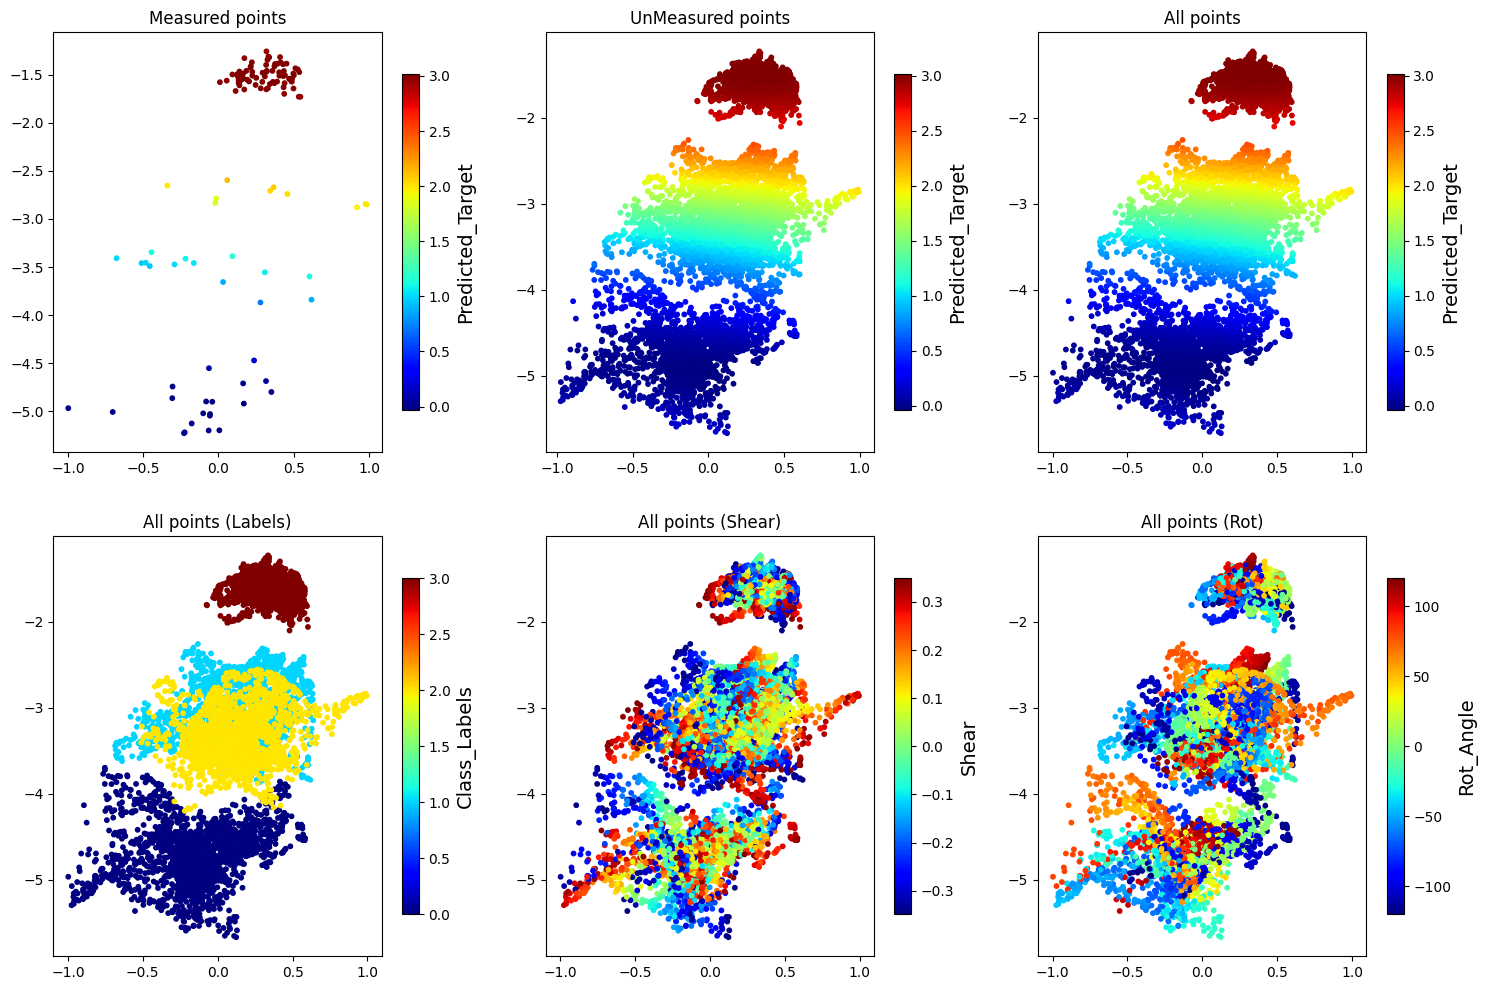

In [54]:
embeded_train4 = dkl_BO_4.embed(X4_train)  # Measured points
embeded_unmeasured4 = dkl_BO_4.embed(X4_unmeasured)  # Unmeasured points
embeded14 = dkl_BO_4.embed(X4)   # All points

fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (18,12))

im = ax[0,0].scatter(embeded_train4[:, 1], embeded_train4[:, 0], s=10, c = predmean_train4, cmap = 'jet')
ax[0,0].set_title('Measured points')
cbar = fig.colorbar(im, ax=ax[0,0], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,1].scatter(embeded_unmeasured4[:, 1], embeded_unmeasured4[:, 0], s=10,
                c = predmean_unmeas4, cmap = 'jet')
ax[0,1].set_title('UnMeasured points')
cbar = fig.colorbar(im, ax=ax[0,1], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,2].scatter(embeded14[:, 1], embeded14[:, 0], s=10, c = predmean14, cmap = 'jet')
ax[0,2].set_title('All points')
cbar = fig.colorbar(im, ax=ax[0,2], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,0].scatter(embeded14[:, 1], embeded14[:, 0], s=10, c = labels_all, cmap = 'jet')
ax[1,0].set_title('All points (Labels)')
cbar = fig.colorbar(im, ax=ax[1,0], shrink=.8)
cbar.set_label("Class_Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,1].scatter(embeded14[:, 1], embeded14[:, 0], s=10, c = shears_all[:,0], cmap = 'jet')
ax[1,1].set_title('All points (Shear)')
cbar = fig.colorbar(im, ax=ax[1,1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,2].scatter(embeded14[:, 1], embeded14[:, 0], s=10, c = angles_all, cmap = 'jet')
ax[1,2].set_title('All points (Rot)')
cbar = fig.colorbar(im, ax=ax[1,2], shrink=.8)
cbar.set_label("Rot_Angle", fontsize=14)
cbar.ax.tick_params(labelsize=10)

ANd now you can see how the DKL learned the "card function" from lcubs to diamonds. Diamonds are set apart (as can be expected), spades and hearts are pretty close. Note that Rotational angles got disentangled for all hands.

# Card parameters as a function

Now, let's run the same analysis assuming that we want to learn the rotation or shear, but at teh same time we do not care about the specific hands. What happens then?

## Shear

In [55]:
X5 = np.copy(X)
targets5 = np.copy(shears_all[:,0])

rng_key_5, rng_key_predict_5 = gpax.utils.get_keys()
dkl_5 = gpax.viDKL(900, 2, 'RBF')
dkl_5.fit(rng_key_5, X5, targets5)

100%|██████████| 1000/1000 [02:40<00:00,  6.24it/s, init loss: 68795.8166, avg. loss [951-1000]: 45962.4339]



Inferred GP kernel parameters
k_length         [2.3282 3.1946]
k_scale          0.1636
noise            0.0085


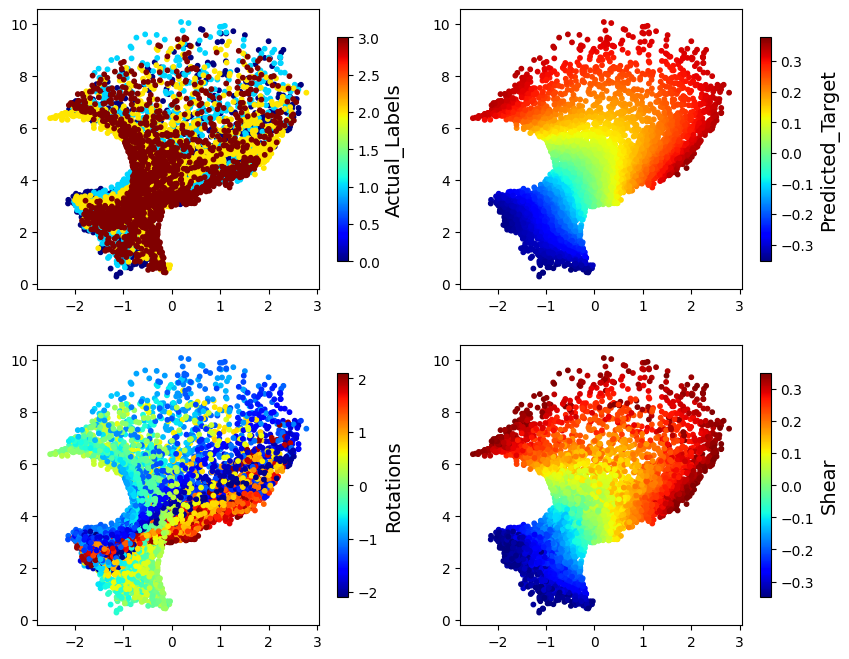

In [56]:
embeded_5 = dkl_5.embed(X5)
pred_mean5, pred_var5 = dkl_5.predict_in_batches(rng_key_predict_5, X5, batch_size=batch_size_reconstruct)
pred_std5 = jnp.sqrt(pred_var5)

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10,8))

im = ax[0,0].scatter(embeded_5[:, 1], embeded_5[:, 0], s=10, c = labels_all, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,0], shrink=.8)
cbar.set_label("Actual_Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,1].scatter(embeded_5[:, 1], embeded_5[:, 0], s=10, c = pred_mean5, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,1], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,0].scatter(embeded_5[:, 1], embeded_5[:, 0], s=10, c = torch.deg2rad(angles_all),
                     cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,0], shrink=.8)
cbar.set_label("Rotations", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,1].scatter(embeded_5[:, 1], embeded_5[:, 0], s=10, c = shears_all[:,0], cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)

Now we see the DKL latent space when our goal was to learn the shear. Predicted target and ground truth look almost the same. Note that the hands overlap (we were not interested in them), and as a bonus we got rotations disentangled in direction perpendicular to the shear.

In [57]:
np.random.seed(0)
idx5 = np.random.choice(np.arange(len(X5)), size = init_num, replace = False)
X5_train = X5[idx5]
X5_unmeasured = np.delete(X5, idx5, axis=0)

indices_total_5 = np.arange(len(X))
indices_train_5 = indices_total_5[idx5]
y5_train = targets5[idx5]
indices_unmeasured_5 = np.delete(indices_total_5, idx5)

In [58]:
exp_mean5, exp_std5 = [], []
dkl_mean5, dkl_std5 = [], []
embed_traj5 = []
traj_mean5, traj_std5 = [], []

exploration_steps = exp_step


for e in range(exploration_steps):
    print("\nStep {}".format(e+1))
    # Obtain/update DKL posterior
    rng_key15, rng_key_predict15 = gpax.utils.get_keys()
    dkl_BO_5 = gpax.viDKL(900, 2, 'RBF')
    dkl_BO_5.fit(rng_key15, X5_train, y5_train)
    # Compute acqusition function
    y_mean, y_var = dkl_BO_5.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        rng_key_predict15, X5_unmeasured, batch_size=250)
    y_std = jnp.sqrt(y_var)
    obj = y_mean + 10 * y_std  # UCB = mu + 10 * sigma
    # Get the next point to evaluate
    id_next = obj.argmax()

    # let's get the mean and std of the next point predicted by dkl_BO
    exp_mean5.append(y_mean[id_next])
    exp_std5.append(y_std[id_next])

    x_next = X5_unmeasured[id_next]
    ind_next = indices_unmeasured_5[id_next]

    # Getting the mean and std of the next point as predicted by the dkl trained on the full dataset
    dkl_mean5.append(pred_mean5[ind_next])
    dkl_std5.append(pred_std5[ind_next])

    # Perform evaluation
#     y_measured = eval_ferrosim(x_next)
    # For now we will only read out the brute force results
    y_measured = targets5[ind_next]

    # Update training arrays
    X5_train = np.append(X5_train, x_next[None], axis=0)
    y5_train = np.append(y5_train, y_measured)
    X5_unmeasured = np.delete(X5_unmeasured, id_next, axis=0)
    indices_unmeasured_5 = np.delete(indices_unmeasured_5, id_next)

    embed_traj = dkl_BO_5.embed(X5_train)
    traj_m, traj_s = dkl_BO_5.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        rng_key_predict15, X5_train, batch_size=batch_size_learn)

    embed_traj5.append(embed_traj)
    traj_mean5.append(traj_m)


Step 1


100%|██████████| 1000/1000 [00:02<00:00, 391.20it/s, init loss: 60100.0389, avg. loss [951-1000]: 56922.5598]



Inferred GP kernel parameters
k_length         [0.3559 0.3679]
k_scale          0.2868
noise            0.0148

Step 2


100%|██████████| 1000/1000 [00:02<00:00, 386.13it/s, init loss: 60101.2200, avg. loss [951-1000]: 56921.2880]



Inferred GP kernel parameters
k_length         [0.3667 0.3432]
k_scale          0.29150000000000004
noise            0.0142

Step 3


100%|██████████| 1000/1000 [00:02<00:00, 379.70it/s, init loss: 60102.4254, avg. loss [951-1000]: 56920.0269]



Inferred GP kernel parameters
k_length         [0.3673 0.3664]
k_scale          0.28750000000000003
noise            0.013600000000000001

Step 4


100%|██████████| 1000/1000 [00:02<00:00, 394.44it/s, init loss: 60103.6982, avg. loss [951-1000]: 56918.3823]



Inferred GP kernel parameters
k_length         [0.3669 0.3404]
k_scale          0.2914
noise            0.0132

Step 5


100%|██████████| 1000/1000 [00:02<00:00, 390.37it/s, init loss: 60104.9366, avg. loss [951-1000]: 56917.0980]



Inferred GP kernel parameters
k_length         [0.3677 0.3499]
k_scale          0.28750000000000003
noise            0.013000000000000001

Step 6


100%|██████████| 1000/1000 [00:02<00:00, 392.55it/s, init loss: 60106.1270, avg. loss [951-1000]: 56916.5666]



Inferred GP kernel parameters
k_length         [0.3696 0.3828]
k_scale          0.2808
noise            0.0128

Step 7


100%|██████████| 1000/1000 [00:02<00:00, 379.19it/s, init loss: 60107.4024, avg. loss [951-1000]: 56915.0061]



Inferred GP kernel parameters
k_length         [0.3679 0.3509]
k_scale          0.2939
noise            0.0125

Step 8


100%|██████████| 1000/1000 [00:02<00:00, 384.26it/s, init loss: 60108.6570, avg. loss [951-1000]: 56915.8202]



Inferred GP kernel parameters
k_length         [0.3675 0.3944]
k_scale          0.2849
noise            0.0128

Step 9


100%|██████████| 1000/1000 [00:02<00:00, 376.73it/s, init loss: 60109.9266, avg. loss [951-1000]: 56913.3497]



Inferred GP kernel parameters
k_length         [0.3599 0.4361]
k_scale          0.2728
noise            0.012400000000000001

Step 10


100%|██████████| 1000/1000 [00:02<00:00, 382.37it/s, init loss: 60111.1315, avg. loss [951-1000]: 56911.1795]



Inferred GP kernel parameters
k_length         [0.3556 0.364 ]
k_scale          0.2864
noise            0.0119

Step 11


100%|██████████| 1000/1000 [00:02<00:00, 378.30it/s, init loss: 60112.3520, avg. loss [951-1000]: 56912.0724]



Inferred GP kernel parameters
k_length         [0.369  0.3722]
k_scale          0.27490000000000003
noise            0.012

Step 12


100%|██████████| 1000/1000 [00:02<00:00, 375.04it/s, init loss: 60113.5283, avg. loss [951-1000]: 56908.9930]



Inferred GP kernel parameters
k_length         [0.3462 0.3673]
k_scale          0.2884
noise            0.011600000000000001

Step 13


100%|██████████| 1000/1000 [00:02<00:00, 411.74it/s, init loss: 60114.8005, avg. loss [951-1000]: 56908.9025]



Inferred GP kernel parameters
k_length         [0.3703 0.3671]
k_scale          0.2914
noise            0.0117

Step 14


100%|██████████| 1000/1000 [00:02<00:00, 408.67it/s, init loss: 60116.0656, avg. loss [951-1000]: 56914.5190]



Inferred GP kernel parameters
k_length         [0.4981 0.5193]
k_scale          0.24100000000000002
noise            0.0119

Step 15


100%|██████████| 1000/1000 [00:02<00:00, 384.99it/s, init loss: 60117.3407, avg. loss [951-1000]: 56905.6039]



Inferred GP kernel parameters
k_length         [0.3822 0.3879]
k_scale          0.2843
noise            0.0112

Step 16


100%|██████████| 1000/1000 [00:02<00:00, 399.01it/s, init loss: 60118.6096, avg. loss [951-1000]: 56903.4072]



Inferred GP kernel parameters
k_length         [0.3571 0.3686]
k_scale          0.2882
noise            0.0111

Step 17


100%|██████████| 1000/1000 [00:02<00:00, 406.32it/s, init loss: 60119.8822, avg. loss [951-1000]: 56902.3661]



Inferred GP kernel parameters
k_length         [0.3566 0.3616]
k_scale          0.28650000000000003
noise            0.0109

Step 18


100%|██████████| 1000/1000 [00:02<00:00, 391.88it/s, init loss: 60121.1563, avg. loss [951-1000]: 56901.6259]



Inferred GP kernel parameters
k_length         [0.4436 0.3977]
k_scale          0.27090000000000003
noise            0.0111

Step 19


100%|██████████| 1000/1000 [00:02<00:00, 400.53it/s, init loss: 60122.4249, avg. loss [951-1000]: 56899.8768]



Inferred GP kernel parameters
k_length         [0.3666 0.3738]
k_scale          0.2864
noise            0.010700000000000001

Step 20


100%|██████████| 1000/1000 [00:02<00:00, 389.87it/s, init loss: 60123.6627, avg. loss [951-1000]: 56899.1106]



Inferred GP kernel parameters
k_length         [0.3679 0.3745]
k_scale          0.2859
noise            0.0106

Step 21


100%|██████████| 1000/1000 [00:02<00:00, 392.81it/s, init loss: 60124.9222, avg. loss [951-1000]: 56897.0737]



Inferred GP kernel parameters
k_length         [0.3679 0.3728]
k_scale          0.2811
noise            0.010400000000000001

Step 22


100%|██████████| 1000/1000 [00:02<00:00, 392.48it/s, init loss: 60126.1896, avg. loss [951-1000]: 56895.2525]



Inferred GP kernel parameters
k_length         [0.3625 0.3656]
k_scale          0.2812
noise            0.010400000000000001

Step 23


100%|██████████| 1000/1000 [00:02<00:00, 398.64it/s, init loss: 60127.4636, avg. loss [951-1000]: 56896.0568]



Inferred GP kernel parameters
k_length         [0.3728 0.3804]
k_scale          0.27840000000000004
noise            0.010400000000000001

Step 24


100%|██████████| 1000/1000 [00:02<00:00, 399.98it/s, init loss: 60128.7381, avg. loss [951-1000]: 56905.1185]



Inferred GP kernel parameters
k_length         [0.3961 0.3849]
k_scale          0.1837
noise            0.0122

Step 25


100%|██████████| 1000/1000 [00:02<00:00, 392.87it/s, init loss: 60129.9202, avg. loss [951-1000]: 56894.3530]



Inferred GP kernel parameters
k_length         [0.3857 0.4048]
k_scale          0.2726
noise            0.0105

Step 26


100%|██████████| 1000/1000 [00:02<00:00, 402.38it/s, init loss: 60131.1900, avg. loss [951-1000]: 56890.1773]



Inferred GP kernel parameters
k_length         [0.3681 0.3611]
k_scale          0.2867
noise            0.010100000000000001

Step 27


100%|██████████| 1000/1000 [00:02<00:00, 395.58it/s, init loss: 60132.3805, avg. loss [951-1000]: 56888.9228]



Inferred GP kernel parameters
k_length         [0.3637 0.3713]
k_scale          0.28390000000000004
noise            0.010100000000000001

Step 28


100%|██████████| 1000/1000 [00:02<00:00, 391.52it/s, init loss: 60133.6546, avg. loss [951-1000]: 56886.8798]



Inferred GP kernel parameters
k_length         [0.3557 0.3679]
k_scale          0.28600000000000003
noise            0.0099

Step 29


100%|██████████| 1000/1000 [00:02<00:00, 398.14it/s, init loss: 60134.9050, avg. loss [951-1000]: 56886.9731]



Inferred GP kernel parameters
k_length         [0.3668 0.3937]
k_scale          0.2857
noise            0.010100000000000001

Step 30


100%|██████████| 1000/1000 [00:02<00:00, 387.81it/s, init loss: 60136.1721, avg. loss [951-1000]: 56884.3963]



Inferred GP kernel parameters
k_length         [0.3689 0.3603]
k_scale          0.2796
noise            0.0099

Step 31


100%|██████████| 1000/1000 [00:02<00:00, 389.12it/s, init loss: 60137.3787, avg. loss [951-1000]: 56897.1135]



Inferred GP kernel parameters
k_length         [0.3647 0.3465]
k_scale          0.2063
noise            0.0112

Step 32


100%|██████████| 1000/1000 [00:02<00:00, 401.91it/s, init loss: 60138.6150, avg. loss [951-1000]: 56883.9119]



Inferred GP kernel parameters
k_length         [0.3693 0.369 ]
k_scale          0.2816
noise            0.01

Step 33


100%|██████████| 1000/1000 [00:02<00:00, 388.91it/s, init loss: 60139.8862, avg. loss [951-1000]: 56883.6813]



Inferred GP kernel parameters
k_length         [0.4533 0.393 ]
k_scale          0.2652
noise            0.01

Step 34


100%|██████████| 1000/1000 [00:02<00:00, 388.25it/s, init loss: 60141.1516, avg. loss [951-1000]: 56881.2928]



Inferred GP kernel parameters
k_length         [0.393  0.3968]
k_scale          0.2752
noise            0.0099

Step 35


100%|██████████| 1000/1000 [00:02<00:00, 385.92it/s, init loss: 60142.3696, avg. loss [951-1000]: 56878.8909]



Inferred GP kernel parameters
k_length         [0.3678 0.3775]
k_scale          0.2732
noise            0.0098

Step 36


100%|██████████| 1000/1000 [00:02<00:00, 392.97it/s, init loss: 60143.6210, avg. loss [951-1000]: 56877.5647]



Inferred GP kernel parameters
k_length         [0.3801 0.379 ]
k_scale          0.2755
noise            0.0098

Step 37


100%|██████████| 1000/1000 [00:02<00:00, 390.43it/s, init loss: 60144.8782, avg. loss [951-1000]: 56875.5554]



Inferred GP kernel parameters
k_length         [0.3765 0.3718]
k_scale          0.27390000000000003
noise            0.0097

Step 38


100%|██████████| 1000/1000 [00:02<00:00, 377.98it/s, init loss: 60146.1229, avg. loss [951-1000]: 56873.4969]



Inferred GP kernel parameters
k_length         [0.3666 0.3705]
k_scale          0.2785
noise            0.009600000000000001

Step 39


100%|██████████| 1000/1000 [00:02<00:00, 389.19it/s, init loss: 60147.3574, avg. loss [951-1000]: 56871.9165]



Inferred GP kernel parameters
k_length         [0.3682 0.3542]
k_scale          0.27640000000000003
noise            0.009600000000000001

Step 40


100%|██████████| 1000/1000 [00:02<00:00, 389.63it/s, init loss: 60148.5026, avg. loss [951-1000]: 56870.3465]



Inferred GP kernel parameters
k_length         [0.3938 0.3755]
k_scale          0.2713
noise            0.0095

Step 41


100%|██████████| 1000/1000 [00:02<00:00, 390.43it/s, init loss: 60149.7085, avg. loss [951-1000]: 56869.6610]



Inferred GP kernel parameters
k_length         [0.3592 0.3768]
k_scale          0.2728
noise            0.009600000000000001

Step 42


100%|██████████| 1000/1000 [00:02<00:00, 394.99it/s, init loss: 60150.9567, avg. loss [951-1000]: 56887.1760]



Inferred GP kernel parameters
k_length         [0.3981 0.3786]
k_scale          0.21330000000000002
noise            0.0102

Step 43


100%|██████████| 1000/1000 [00:02<00:00, 398.94it/s, init loss: 60152.2144, avg. loss [951-1000]: 56870.1680]



Inferred GP kernel parameters
k_length         [0.3912 0.3931]
k_scale          0.26180000000000003
noise            0.0097

Step 44


100%|██████████| 1000/1000 [00:02<00:00, 375.52it/s, init loss: 60153.4823, avg. loss [951-1000]: 56866.6677]



Inferred GP kernel parameters
k_length         [0.3906 0.3922]
k_scale          0.2682
noise            0.0095

Step 45


100%|██████████| 1000/1000 [00:02<00:00, 372.37it/s, init loss: 60154.7465, avg. loss [951-1000]: 56865.7188]



Inferred GP kernel parameters
k_length         [0.3465 0.3679]
k_scale          0.23190000000000002
noise            0.009600000000000001

Step 46


100%|██████████| 1000/1000 [00:02<00:00, 404.59it/s, init loss: 60155.9978, avg. loss [951-1000]: 56862.7607]



Inferred GP kernel parameters
k_length         [0.3569 0.3679]
k_scale          0.26940000000000003
noise            0.0094

Step 47


100%|██████████| 1000/1000 [00:02<00:00, 401.27it/s, init loss: 60157.2424, avg. loss [951-1000]: 56871.0671]



Inferred GP kernel parameters
k_length         [0.4294 0.4326]
k_scale          0.196
noise            0.01

Step 48


100%|██████████| 1000/1000 [00:02<00:00, 398.43it/s, init loss: 60158.5089, avg. loss [951-1000]: 56862.5671]



Inferred GP kernel parameters
k_length         [0.3978 0.3608]
k_scale          0.2647
noise            0.0095

Step 49


100%|██████████| 1000/1000 [00:02<00:00, 404.52it/s, init loss: 60159.7743, avg. loss [951-1000]: 56860.7848]



Inferred GP kernel parameters
k_length         [0.4292 0.5055]
k_scale          0.24050000000000002
noise            0.0095

Step 50


100%|██████████| 1000/1000 [00:02<00:00, 389.79it/s, init loss: 60160.9727, avg. loss [951-1000]: 56867.9365]



Inferred GP kernel parameters
k_length         [0.371  0.3878]
k_scale          0.1849
noise            0.010100000000000001

Step 51


100%|██████████| 1000/1000 [00:02<00:00, 406.23it/s, init loss: 60162.1632, avg. loss [951-1000]: 56860.6343]



Inferred GP kernel parameters
k_length         [0.5064 0.467 ]
k_scale          0.24180000000000001
noise            0.009600000000000001

Step 52


100%|██████████| 1000/1000 [00:02<00:00, 402.30it/s, init loss: 60163.3503, avg. loss [951-1000]: 56855.7781]



Inferred GP kernel parameters
k_length         [0.4059 0.3788]
k_scale          0.2649
noise            0.009300000000000001

Step 53


100%|██████████| 1000/1000 [00:02<00:00, 397.42it/s, init loss: 60164.5935, avg. loss [951-1000]: 56853.0298]



Inferred GP kernel parameters
k_length         [0.3721 0.4081]
k_scale          0.2707
noise            0.009300000000000001

Step 54


100%|██████████| 1000/1000 [00:02<00:00, 399.27it/s, init loss: 60165.8076, avg. loss [951-1000]: 56855.1056]



Inferred GP kernel parameters
k_length         [0.4368 0.4939]
k_scale          0.24630000000000002
noise            0.0095

Step 55


100%|██████████| 1000/1000 [00:02<00:00, 407.17it/s, init loss: 60167.0829, avg. loss [951-1000]: 56852.7362]



Inferred GP kernel parameters
k_length         [0.3793 0.3801]
k_scale          0.2664
noise            0.009300000000000001

Step 56


100%|██████████| 1000/1000 [00:02<00:00, 397.45it/s, init loss: 60168.3347, avg. loss [951-1000]: 56848.8319]



Inferred GP kernel parameters
k_length         [0.3679 0.3703]
k_scale          0.2684
noise            0.0092

Step 57


100%|██████████| 1000/1000 [00:02<00:00, 404.87it/s, init loss: 60169.5397, avg. loss [951-1000]: 56848.6522]



Inferred GP kernel parameters
k_length         [0.3679 0.3657]
k_scale          0.2738
noise            0.0091

Step 58


100%|██████████| 1000/1000 [00:02<00:00, 401.27it/s, init loss: 60170.7034, avg. loss [951-1000]: 56849.2887]



Inferred GP kernel parameters
k_length         [0.4056 0.3755]
k_scale          0.263
noise            0.0092

Step 59


100%|██████████| 1000/1000 [00:02<00:00, 392.48it/s, init loss: 60171.9422, avg. loss [951-1000]: 56845.2739]



Inferred GP kernel parameters
k_length         [0.3863 0.3927]
k_scale          0.27190000000000003
noise            0.0092

Step 60


100%|██████████| 1000/1000 [00:02<00:00, 381.27it/s, init loss: 60173.2180, avg. loss [951-1000]: 56859.9249]



Inferred GP kernel parameters
k_length         [0.3326 0.3794]
k_scale          0.20070000000000002
noise            0.0099

Step 61


100%|██████████| 1000/1000 [00:02<00:00, 370.48it/s, init loss: 60174.4616, avg. loss [951-1000]: 56841.8260]



Inferred GP kernel parameters
k_length         [0.3694 0.3693]
k_scale          0.2706
noise            0.009000000000000001

Step 62


100%|██████████| 1000/1000 [00:02<00:00, 389.70it/s, init loss: 60175.7366, avg. loss [951-1000]: 56851.8495]



Inferred GP kernel parameters
k_length         [0.3505 0.3679]
k_scale          0.1967
noise            0.0099

Step 63


100%|██████████| 1000/1000 [00:02<00:00, 385.41it/s, init loss: 60176.9828, avg. loss [951-1000]: 56838.8769]



Inferred GP kernel parameters
k_length         [0.3681 0.374 ]
k_scale          0.2657
noise            0.009000000000000001

Step 64


100%|██████████| 1000/1000 [00:02<00:00, 389.11it/s, init loss: 60178.2493, avg. loss [951-1000]: 56838.2308]



Inferred GP kernel parameters
k_length         [0.3742 0.4296]
k_scale          0.26940000000000003
noise            0.009000000000000001

Step 65


100%|██████████| 1000/1000 [00:02<00:00, 388.92it/s, init loss: 60179.4813, avg. loss [951-1000]: 56850.1952]



Inferred GP kernel parameters
k_length         [0.5237 0.4705]
k_scale          0.1874
noise            0.009600000000000001

Step 66


100%|██████████| 1000/1000 [00:02<00:00, 389.97it/s, init loss: 60180.7049, avg. loss [951-1000]: 56836.5392]



Inferred GP kernel parameters
k_length         [0.3878 0.3906]
k_scale          0.2622
noise            0.009000000000000001

Step 67


100%|██████████| 1000/1000 [00:02<00:00, 402.07it/s, init loss: 60181.9374, avg. loss [951-1000]: 56833.9568]



Inferred GP kernel parameters
k_length         [0.3805 0.3748]
k_scale          0.2676
noise            0.009000000000000001

Step 68


100%|██████████| 1000/1000 [00:02<00:00, 400.39it/s, init loss: 60183.1450, avg. loss [951-1000]: 56834.2441]



Inferred GP kernel parameters
k_length         [0.391  0.3716]
k_scale          0.271
noise            0.009000000000000001

Step 69


100%|██████████| 1000/1000 [00:02<00:00, 401.16it/s, init loss: 60184.3853, avg. loss [951-1000]: 56831.7411]



Inferred GP kernel parameters
k_length         [0.3769 0.3802]
k_scale          0.26080000000000003
noise            0.009000000000000001

Step 70


100%|██████████| 1000/1000 [00:02<00:00, 395.37it/s, init loss: 60185.6578, avg. loss [951-1000]: 56832.9450]



Inferred GP kernel parameters
k_length         [0.3948 0.3966]
k_scale          0.26780000000000004
noise            0.0089

Step 71


100%|██████████| 1000/1000 [00:02<00:00, 393.36it/s, init loss: 60186.8603, avg. loss [951-1000]: 56826.8832]



Inferred GP kernel parameters
k_length         [0.3562 0.3657]
k_scale          0.269
noise            0.0088

Step 72


100%|██████████| 1000/1000 [00:02<00:00, 398.55it/s, init loss: 60188.1095, avg. loss [951-1000]: 56826.4726]



Inferred GP kernel parameters
k_length         [0.3801 0.3768]
k_scale          0.2664
noise            0.0088

Step 73


100%|██████████| 1000/1000 [00:02<00:00, 394.43it/s, init loss: 60189.3116, avg. loss [951-1000]: 56825.5500]



Inferred GP kernel parameters
k_length         [0.3922 0.3772]
k_scale          0.2636
noise            0.009000000000000001

Step 74


100%|██████████| 1000/1000 [00:02<00:00, 397.67it/s, init loss: 60190.5476, avg. loss [951-1000]: 56828.1813]



Inferred GP kernel parameters
k_length         [0.4327 0.391 ]
k_scale          0.2459
noise            0.0094

Step 75


100%|██████████| 1000/1000 [00:02<00:00, 401.30it/s, init loss: 60191.8262, avg. loss [951-1000]: 56823.0154]



Inferred GP kernel parameters
k_length         [0.3819 0.384 ]
k_scale          0.269
noise            0.0089

Step 76


100%|██████████| 1000/1000 [00:02<00:00, 391.68it/s, init loss: 60193.1005, avg. loss [951-1000]: 56834.7089]



Inferred GP kernel parameters
k_length         [0.3278 0.3728]
k_scale          0.2093
noise            0.009300000000000001

Step 77


100%|██████████| 1000/1000 [00:02<00:00, 398.10it/s, init loss: 60194.3576, avg. loss [951-1000]: 56819.5599]



Inferred GP kernel parameters
k_length         [0.3746 0.3856]
k_scale          0.259
noise            0.0089

Step 78


100%|██████████| 1000/1000 [00:02<00:00, 387.52it/s, init loss: 60195.6155, avg. loss [951-1000]: 56820.4441]



Inferred GP kernel parameters
k_length         [0.401 0.364]
k_scale          0.2645
noise            0.0089

Step 79


100%|██████████| 1000/1000 [00:02<00:00, 398.34it/s, init loss: 60196.8741, avg. loss [951-1000]: 56825.7540]



Inferred GP kernel parameters
k_length         [0.3849 0.4202]
k_scale          0.2349
noise            0.0092

Step 80


100%|██████████| 1000/1000 [00:02<00:00, 395.07it/s, init loss: 60198.1393, avg. loss [951-1000]: 56815.6924]



Inferred GP kernel parameters
k_length         [0.3607 0.3709]
k_scale          0.259
noise            0.0089

Step 81


100%|██████████| 1000/1000 [00:02<00:00, 385.56it/s, init loss: 60199.4098, avg. loss [951-1000]: 56817.5199]



Inferred GP kernel parameters
k_length         [0.4184 0.3957]
k_scale          0.25120000000000003
noise            0.009000000000000001

Step 82


100%|██████████| 1000/1000 [00:02<00:00, 395.64it/s, init loss: 60200.6451, avg. loss [951-1000]: 56813.2756]



Inferred GP kernel parameters
k_length         [0.361  0.3709]
k_scale          0.2595
noise            0.0088

Step 83


100%|██████████| 1000/1000 [00:02<00:00, 395.92it/s, init loss: 60201.8048, avg. loss [951-1000]: 56814.0775]



Inferred GP kernel parameters
k_length         [0.3907 0.3799]
k_scale          0.2544
noise            0.0089

Step 84


100%|██████████| 1000/1000 [00:02<00:00, 402.56it/s, init loss: 60202.9836, avg. loss [951-1000]: 56826.6274]



Inferred GP kernel parameters
k_length         [0.3482 0.3688]
k_scale          0.1975
noise            0.0095

Step 85


100%|██████████| 1000/1000 [00:02<00:00, 395.00it/s, init loss: 60204.2397, avg. loss [951-1000]: 56820.0923]



Inferred GP kernel parameters
k_length         [0.365  0.3249]
k_scale          0.18610000000000002
noise            0.009300000000000001

Step 86


100%|██████████| 1000/1000 [00:02<00:00, 393.37it/s, init loss: 60205.4690, avg. loss [951-1000]: 56816.7667]



Inferred GP kernel parameters
k_length         [0.4023 0.4217]
k_scale          0.2151
noise            0.0094

Step 87


100%|██████████| 1000/1000 [00:02<00:00, 397.59it/s, init loss: 60206.6515, avg. loss [951-1000]: 56808.2858]



Inferred GP kernel parameters
k_length         [0.3738 0.3845]
k_scale          0.2564
noise            0.009000000000000001

Step 88


100%|██████████| 1000/1000 [00:02<00:00, 392.31it/s, init loss: 60207.9006, avg. loss [951-1000]: 56808.9714]



Inferred GP kernel parameters
k_length         [0.4669 0.4722]
k_scale          0.23340000000000002
noise            0.009000000000000001

Step 89


100%|██████████| 1000/1000 [00:02<00:00, 386.60it/s, init loss: 60209.1578, avg. loss [951-1000]: 56809.9572]



Inferred GP kernel parameters
k_length         [0.3844 0.3687]
k_scale          0.2484
noise            0.009000000000000001

Step 90


100%|██████████| 1000/1000 [00:02<00:00, 394.64it/s, init loss: 60210.4163, avg. loss [951-1000]: 56807.3913]



Inferred GP kernel parameters
k_length         [0.3781 0.374 ]
k_scale          0.22440000000000002
noise            0.0094

Step 91


100%|██████████| 1000/1000 [00:02<00:00, 392.41it/s, init loss: 60211.6061, avg. loss [951-1000]: 56821.3958]



Inferred GP kernel parameters
k_length         [0.378  0.3929]
k_scale          0.1731
noise            0.0098

Step 92


100%|██████████| 1000/1000 [00:02<00:00, 389.34it/s, init loss: 60212.8439, avg. loss [951-1000]: 56817.1042]



Inferred GP kernel parameters
k_length         [0.3191 0.3679]
k_scale          0.19820000000000002
noise            0.0095

Step 93


100%|██████████| 1000/1000 [00:02<00:00, 401.56it/s, init loss: 60214.1090, avg. loss [951-1000]: 56818.4829]



Inferred GP kernel parameters
k_length         [0.3976 0.3752]
k_scale          0.24450000000000002
noise            0.009300000000000001

Step 94


100%|██████████| 1000/1000 [00:02<00:00, 385.81it/s, init loss: 60215.3651, avg. loss [951-1000]: 56801.7055]



Inferred GP kernel parameters
k_length         [0.4082 0.4375]
k_scale          0.21730000000000002
noise            0.0092

Step 95


100%|██████████| 1000/1000 [00:02<00:00, 381.87it/s, init loss: 60216.4937, avg. loss [951-1000]: 56807.3684]



Inferred GP kernel parameters
k_length         [0.4533 0.4649]
k_scale          0.2156
noise            0.0092

Step 96


100%|██████████| 1000/1000 [00:02<00:00, 393.41it/s, init loss: 60217.7282, avg. loss [951-1000]: 56811.9322]



Inferred GP kernel parameters
k_length         [0.4212 0.3853]
k_scale          0.2147
noise            0.0094

Step 97


100%|██████████| 1000/1000 [00:02<00:00, 396.78it/s, init loss: 60218.9305, avg. loss [951-1000]: 56820.3924]



Inferred GP kernel parameters
k_length         [0.3626 0.363 ]
k_scale          0.22030000000000002
noise            0.0094

Step 98


100%|██████████| 1000/1000 [00:02<00:00, 383.96it/s, init loss: 60220.1431, avg. loss [951-1000]: 56798.2383]



Inferred GP kernel parameters
k_length         [0.4038 0.3866]
k_scale          0.2434
noise            0.009000000000000001

Step 99


100%|██████████| 1000/1000 [00:02<00:00, 386.48it/s, init loss: 60221.4000, avg. loss [951-1000]: 56792.8593]



Inferred GP kernel parameters
k_length         [0.386  0.3736]
k_scale          0.2508
noise            0.0089

Step 100


100%|██████████| 1000/1000 [00:02<00:00, 382.62it/s, init loss: 60222.6265, avg. loss [951-1000]: 56800.5998]



Inferred GP kernel parameters
k_length         [0.4262 0.4667]
k_scale          0.2169
noise            0.0091


In [59]:
shear_results = {}
shear_results['X_train'] = X5_train
shear_results['y_train'] = y5_train
shear_results['X_unmeasured'] = X5_unmeasured
shear_results['indices_unmeasured'] = indices_unmeasured_5
shear_results['dkl_mean'] = dkl_mean5
shear_results['dkl_std'] = dkl_std5
shear_results['exp_mean'] = exp_mean5
shear_results['exp_std'] = exp_std5
shear_results['traj_mean'] = traj_mean5
shear_results['traj_std'] = traj_std5
shear_results['embed_traj'] = embed_traj5

with open('shear_results.pickle', 'wb') as handle:
    pickle.dump(shear_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [60]:
with open('shear_results.pickle', 'rb') as f:
    shear_results = pickle.load(f)

X5_train = shear_results['X_train']
y5_train = shear_results['y_train']
X5_unmeasured = shear_results['X_unmeasured']
indices_unmeasured_5 = shear_results['indices_unmeasured']
dkl_mean5 = shear_results['dkl_mean']
dkl_std5 = shear_results['dkl_std']
exp_mean5 = shear_results['exp_mean']
exp_std5 = shear_results['exp_std']
traj_mean5 = shear_results['traj_mean']
traj_std5 = shear_results['traj_std']
embed_traj5 = shear_results['embed_traj']

In [61]:
rng_key15, rng_key_predict15 = gpax.utils.get_keys()
dkl_BO_5 = gpax.viDKL(900, 2, 'RBF')
dkl_BO_5.fit(rng_key15, X5_train, y5_train)

predmean_train5, predstd_train5 = dkl_BO_5.predict_in_batches(rng_key_predict15, X5_train, batch_size=batch_size_learn)
predmean_unmeas5, predstd_unmeas5 = dkl_BO_5.predict_in_batches(rng_key_predict15, X5_unmeasured, batch_size=batch_size_reconstruct)
predmean15, predstd15 = dkl_BO_5.predict_in_batches(rng_key_predict15, X5, batch_size=batch_size_reconstruct)

100%|██████████| 1000/1000 [00:02<00:00, 382.12it/s, init loss: 60223.8695, avg. loss [951-1000]: 56798.3333]



Inferred GP kernel parameters
k_length         [0.5128 0.4511]
k_scale          0.2197
noise            0.009000000000000001


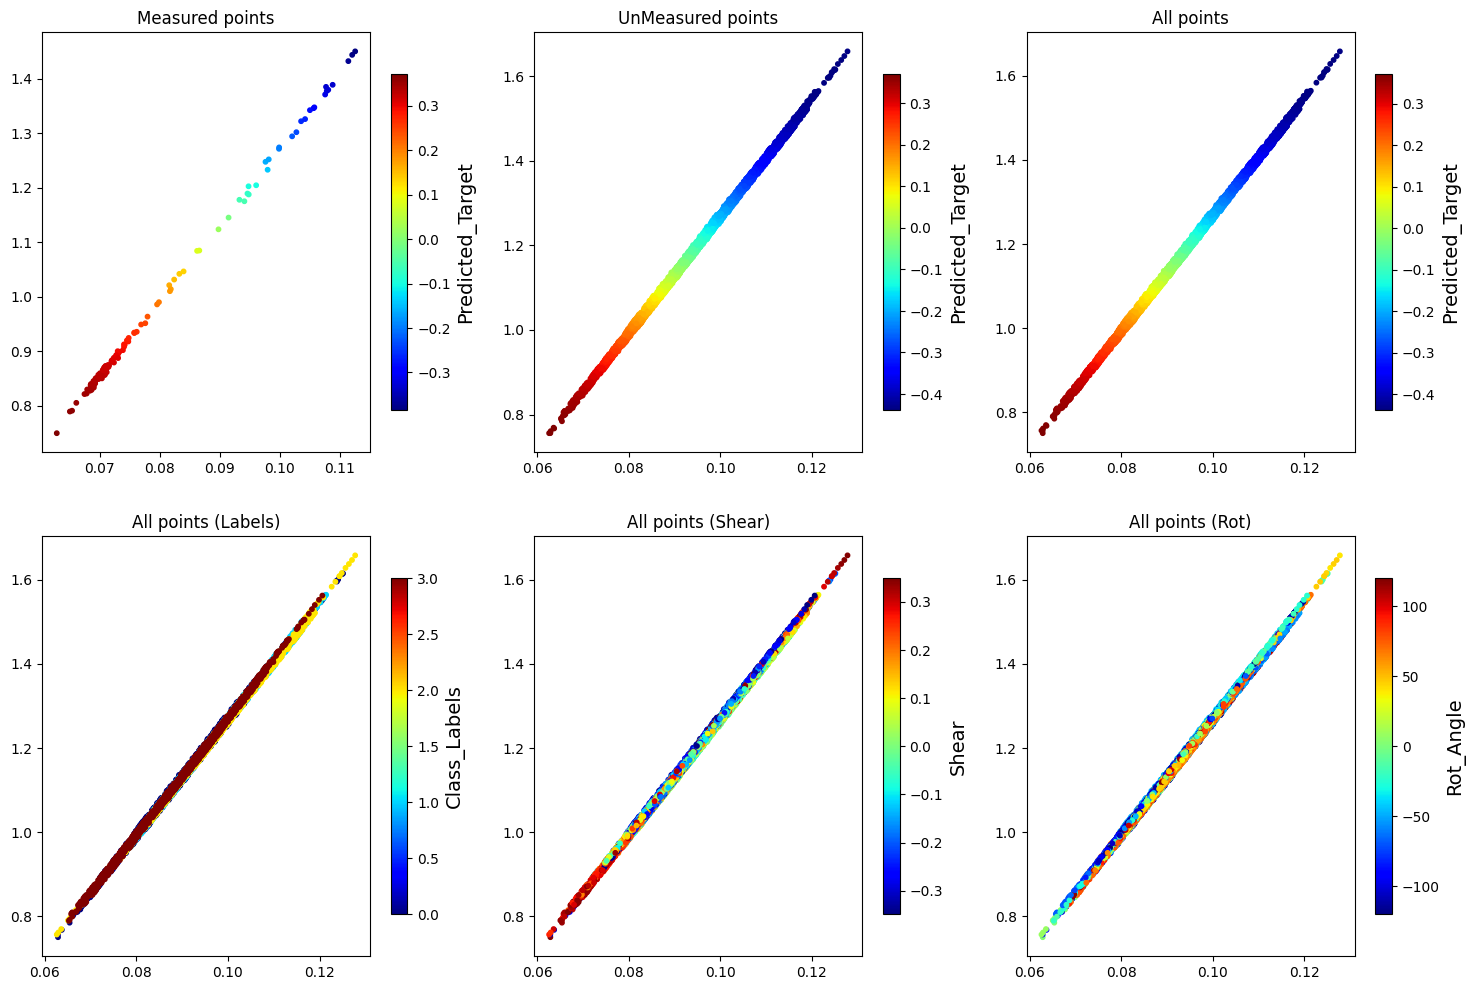

In [62]:
embeded_train5 = dkl_BO_5.embed(X5_train)  # Measured points
embeded_unmeasured5 = dkl_BO_5.embed(X5_unmeasured)  # Unmeasured points
embeded15 = dkl_BO_5.embed(X5)   # All points

fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (18,12))

im = ax[0,0].scatter(embeded_train5[:, 1], embeded_train5[:, 0], s=10, c = predmean_train5, cmap = 'jet')
ax[0,0].set_title('Measured points')
cbar = fig.colorbar(im, ax=ax[0,0], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,1].scatter(embeded_unmeasured5[:, 1], embeded_unmeasured5[:, 0], s=10,
                c = predmean_unmeas5, cmap = 'jet')
ax[0,1].set_title('UnMeasured points')
cbar = fig.colorbar(im, ax=ax[0,1], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,2].scatter(embeded15[:, 1], embeded15[:, 0], s=10, c = predmean15, cmap = 'jet')
ax[0,2].set_title('All points')
cbar = fig.colorbar(im, ax=ax[0,2], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,0].scatter(embeded15[:, 1], embeded15[:, 0], s=10, c = labels_all, cmap = 'jet')
ax[1,0].set_title('All points (Labels)')
cbar = fig.colorbar(im, ax=ax[1,0], shrink=.8)
cbar.set_label("Class_Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,1].scatter(embeded15[:, 1], embeded15[:, 0], s=10, c = shears_all[:,0], cmap = 'jet')
ax[1,1].set_title('All points (Shear)')
cbar = fig.colorbar(im, ax=ax[1,1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,2].scatter(embeded15[:, 1], embeded15[:, 0], s=10, c = angles_all, cmap = 'jet')
ax[1,2].set_title('All points (Rot)')
cbar = fig.colorbar(im, ax=ax[1,2], shrink=.8)
cbar.set_label("Rot_Angle", fontsize=14)
cbar.ax.tick_params(labelsize=10)

And now we have done it as active learning. NOte that in this case the predicted targets form two regions in latent space. So, th elatent distirbution is much better behaved then for VAE, but not as good as for the full DKL. Still, we learned only with 1% of the data.

## Rotations

In [63]:
targets6 = np.copy(angles_all)

rng_key_6, rng_key_predict_6 = gpax.utils.get_keys()
dkl_6 = gpax.viDKL(900, 2, 'RBF')
dkl_6.fit(rng_key_6, X, targets6)

100%|██████████| 1000/1000 [02:40<00:00,  6.23it/s, init loss: 13772531.3452, avg. loss [951-1000]: 114913.3078]



Inferred GP kernel parameters
k_length         [2.1603 1.5887]
k_scale          2.8360000000000003
noise            1.7402000000000002


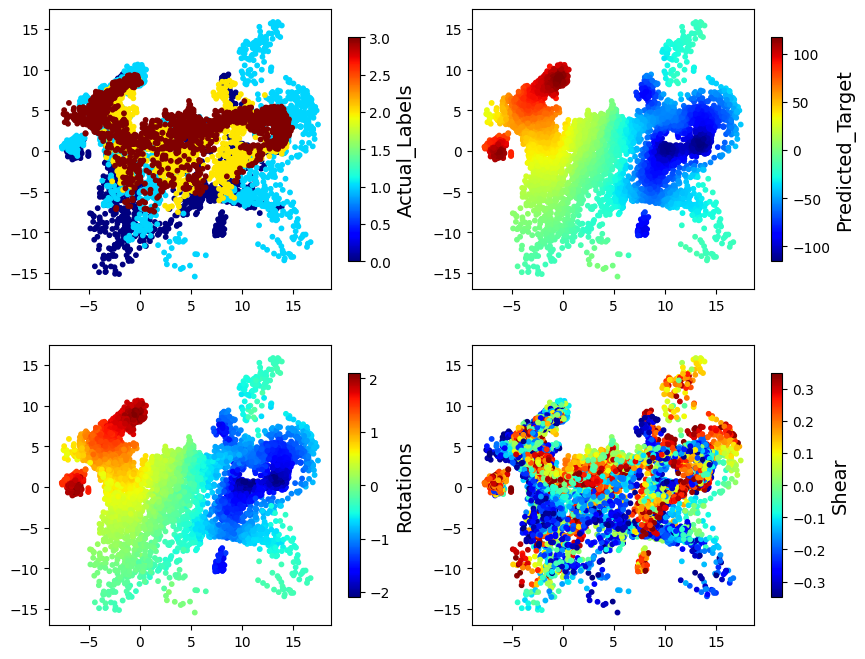

In [64]:
embeded_6 = dkl_6.embed(X)
pred_mean6, pred_var6 = dkl_6.predict_in_batches(rng_key_predict_6, X, batch_size=batch_size_reconstruct)
pred_std6 = jnp.sqrt(pred_var6)

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10,8))

im = ax[0,0].scatter(embeded_6[:, 1], embeded_6[:, 0], s=10, c = labels_all, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,0], shrink=.8)
cbar.set_label("Actual_Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,1].scatter(embeded_6[:, 1], embeded_6[:, 0], s=10, c = pred_mean6, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,1], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,0].scatter(embeded_6[:, 1], embeded_6[:, 0], s=10, c = torch.deg2rad(angles_all),
                     cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,0], shrink=.8)
cbar.set_label("Rotations", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,1].scatter(embeded_6[:, 1], embeded_6[:, 0], s=10, c = shears_all[:,0], cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)

In [65]:
X6 = np.copy(X)
np.random.seed(0)
idx6 = np.random.choice(np.arange(len(X6)), size = init_num, replace = False)
X6_train = X6[idx6]
X6_unmeasured = np.delete(X6, idx6, axis=0)

indices_total_6 = np.arange(len(X))
indices_train_6 = indices_total_6[idx6]
y6_train = targets6[idx6]
indices_unmeasured_6 = np.delete(indices_total_6, idx6)

In [66]:
exp_mean6, exp_std6 = [], []
dkl_mean6, dkl_std6 = [], []
embed_traj6 = []
traj_mean6, traj_std6 = [], []

exploration_steps = exp_step


for e in range(exploration_steps):
    print("\nStep {}".format(e+1))
    # Obtain/update DKL posterior
    rng_key16, rng_key_predict16 = gpax.utils.get_keys()
    dkl_BO_6 = gpax.viDKL(900, 2, 'RBF')
    dkl_BO_6.fit(rng_key16, X6_train, y6_train)
    # Compute acqusition function
    y_mean, y_var = dkl_BO_6.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        rng_key_predict16, X6_unmeasured, batch_size=250)
    y_std = jnp.sqrt(y_var)
    obj = y_mean + 10 * y_std  # UCB = mu + 10 * sigma
    # Get the next point to evaluate
    id_next = obj.argmax()

    # let's get the mean and std of the next point predicted by dkl_BO
    exp_mean6.append(y_mean[id_next])
    exp_std6.append(y_std[id_next])

    x_next = X6_unmeasured[id_next]
    ind_next = indices_unmeasured_6[id_next]

    # Getting the mean and std of the next point as predicted by the dkl trained on the full dataset
    dkl_mean6.append(pred_mean6[ind_next])
    dkl_std6.append(pred_std6[ind_next])

    # Perform evaluation
#     y_measured = eval_ferrosim(x_next)
    # For now we will only read out the brute force results
    y_measured = targets6[ind_next]

    # Update training arrays
    X6_train = np.append(X6_train, x_next[None], axis=0)
    y6_train = np.append(y6_train, y_measured)
    X6_unmeasured = np.delete(X6_unmeasured, id_next, axis=0)
    indices_unmeasured_6 = np.delete(indices_unmeasured_6, id_next)

    embed_traj = dkl_BO_6.embed(X6_train)
    traj_m, traj_s = dkl_BO_6.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        rng_key_predict16, X6_train, batch_size=batch_size_learn)

    embed_traj6.append(embed_traj)
    traj_mean6.append(traj_m)


Step 1


100%|██████████| 1000/1000 [00:02<00:00, 390.35it/s, init loss: 82929.5878, avg. loss [951-1000]: 59889.2401]



Inferred GP kernel parameters
k_length         [1.2435 0.807 ]
k_scale          8.344000000000001
noise            14.2056

Step 2


100%|██████████| 1000/1000 [00:02<00:00, 390.56it/s, init loss: 86897.2103, avg. loss [951-1000]: 60054.8089]



Inferred GP kernel parameters
k_length         [1.5474 1.304 ]
k_scale          10.650500000000001
noise            9.9745

Step 3


100%|██████████| 1000/1000 [00:02<00:00, 383.63it/s, init loss: 88325.8622, avg. loss [951-1000]: 60254.0722]



Inferred GP kernel parameters
k_length         [1.3719 0.9754]
k_scale          8.6475
noise            12.9954

Step 4


100%|██████████| 1000/1000 [00:02<00:00, 375.78it/s, init loss: 90159.0830, avg. loss [951-1000]: 60388.6421]



Inferred GP kernel parameters
k_length         [1.434 1.024]
k_scale          9.4845
noise            11.1331

Step 5


100%|██████████| 1000/1000 [00:02<00:00, 390.97it/s, init loss: 90457.7591, avg. loss [951-1000]: 60301.7231]



Inferred GP kernel parameters
k_length         [1.428  1.0738]
k_scale          9.5436
noise            10.622300000000001

Step 6


100%|██████████| 1000/1000 [00:02<00:00, 383.12it/s, init loss: 92520.5339, avg. loss [951-1000]: 60534.7955]



Inferred GP kernel parameters
k_length         [1.5861 1.1553]
k_scale          8.498700000000001
noise            12.9092

Step 7


100%|██████████| 1000/1000 [00:02<00:00, 383.72it/s, init loss: 93577.1921, avg. loss [951-1000]: 60339.1560]



Inferred GP kernel parameters
k_length         [1.8842 1.2315]
k_scale          8.8076
noise            9.162700000000001

Step 8


100%|██████████| 1000/1000 [00:02<00:00, 384.04it/s, init loss: 96546.8917, avg. loss [951-1000]: 60659.0589]



Inferred GP kernel parameters
k_length         [1.485 1.031]
k_scale          8.3056
noise            12.954500000000001

Step 9


100%|██████████| 1000/1000 [00:02<00:00, 382.69it/s, init loss: 100016.5958, avg. loss [951-1000]: 60214.6500]



Inferred GP kernel parameters
k_length         [2.0593 1.4011]
k_scale          7.830900000000001
noise            9.600100000000001

Step 10


100%|██████████| 1000/1000 [00:02<00:00, 373.28it/s, init loss: 100051.2313, avg. loss [951-1000]: 61029.8202]



Inferred GP kernel parameters
k_length         [1.6615 1.1653]
k_scale          8.4724
noise            10.9063

Step 11


100%|██████████| 1000/1000 [00:02<00:00, 366.74it/s, init loss: 101961.8230, avg. loss [951-1000]: 61251.0938]



Inferred GP kernel parameters
k_length         [1.5637 1.156 ]
k_scale          8.8712
noise            11.3035

Step 12


100%|██████████| 1000/1000 [00:02<00:00, 371.83it/s, init loss: 105195.9268, avg. loss [951-1000]: 61574.4444]



Inferred GP kernel parameters
k_length         [1.462  1.0112]
k_scale          8.4701
noise            12.7988

Step 13


100%|██████████| 1000/1000 [00:02<00:00, 383.56it/s, init loss: 105751.4357, avg. loss [951-1000]: 61701.2293]



Inferred GP kernel parameters
k_length         [1.4595 0.9795]
k_scale          8.7258
noise            12.288300000000001

Step 14


100%|██████████| 1000/1000 [00:02<00:00, 393.23it/s, init loss: 106104.9188, avg. loss [951-1000]: 61611.6536]



Inferred GP kernel parameters
k_length         [1.4767 1.0659]
k_scale          9.0318
noise            11.1517

Step 15


100%|██████████| 1000/1000 [00:02<00:00, 402.20it/s, init loss: 109519.5882, avg. loss [951-1000]: 60852.2440]



Inferred GP kernel parameters
k_length         [2.2581 1.6827]
k_scale          7.6138
noise            6.9897

Step 16


100%|██████████| 1000/1000 [00:02<00:00, 390.69it/s, init loss: 109841.2625, avg. loss [951-1000]: 60392.7203]



Inferred GP kernel parameters
k_length         [2.4719 1.7549]
k_scale          6.560300000000001
noise            3.5131

Step 17


100%|██████████| 1000/1000 [00:02<00:00, 403.55it/s, init loss: 112021.6494, avg. loss [951-1000]: 61129.1370]



Inferred GP kernel parameters
k_length         [2.0844 1.5297]
k_scale          7.6694
noise            4.9398

Step 18


100%|██████████| 1000/1000 [00:02<00:00, 401.96it/s, init loss: 113773.5332, avg. loss [951-1000]: 61437.0560]



Inferred GP kernel parameters
k_length         [2.1393 1.5124]
k_scale          7.3726
noise            6.3007

Step 19


100%|██████████| 1000/1000 [00:02<00:00, 392.38it/s, init loss: 116906.2922, avg. loss [951-1000]: 61638.0611]



Inferred GP kernel parameters
k_length         [1.729  1.2667]
k_scale          8.568
noise            8.8027

Step 20


100%|██████████| 1000/1000 [00:02<00:00, 393.86it/s, init loss: 117780.6658, avg. loss [951-1000]: 61121.3275]



Inferred GP kernel parameters
k_length         [2.2542 1.6778]
k_scale          7.5549
noise            4.4871

Step 21


100%|██████████| 1000/1000 [00:02<00:00, 398.52it/s, init loss: 120495.4424, avg. loss [951-1000]: 62078.3402]



Inferred GP kernel parameters
k_length         [1.8892 1.3141]
k_scale          8.321900000000001
noise            8.3976

Step 22


100%|██████████| 1000/1000 [00:02<00:00, 391.77it/s, init loss: 122167.2686, avg. loss [951-1000]: 60757.8294]



Inferred GP kernel parameters
k_length         [2.0574 1.4163]
k_scale          5.9294
noise            4.2948

Step 23


100%|██████████| 1000/1000 [00:02<00:00, 395.41it/s, init loss: 122495.0533, avg. loss [951-1000]: 61608.5201]



Inferred GP kernel parameters
k_length         [1.7079 1.2623]
k_scale          7.8311
noise            7.9811000000000005

Step 24


100%|██████████| 1000/1000 [00:02<00:00, 388.88it/s, init loss: 125882.1449, avg. loss [951-1000]: 62068.6602]



Inferred GP kernel parameters
k_length         [2.2084 1.4664]
k_scale          7.0924000000000005
noise            7.745

Step 25


100%|██████████| 1000/1000 [00:02<00:00, 397.03it/s, init loss: 131163.1965, avg. loss [951-1000]: 63083.5316]



Inferred GP kernel parameters
k_length         [1.723  1.2066]
k_scale          9.484200000000001
noise            9.4178

Step 26


100%|██████████| 1000/1000 [00:02<00:00, 388.39it/s, init loss: 132558.3381, avg. loss [951-1000]: 61874.6203]



Inferred GP kernel parameters
k_length         [2.2401 1.5866]
k_scale          7.3942000000000005
noise            6.0657000000000005

Step 27


100%|██████████| 1000/1000 [00:02<00:00, 400.13it/s, init loss: 133427.7856, avg. loss [951-1000]: 62749.9632]



Inferred GP kernel parameters
k_length         [1.8938 1.453 ]
k_scale          7.7201
noise            7.948600000000001

Step 28


100%|██████████| 1000/1000 [00:02<00:00, 386.30it/s, init loss: 136831.8732, avg. loss [951-1000]: 62036.6964]



Inferred GP kernel parameters
k_length         [2.169  1.5751]
k_scale          6.0037
noise            6.7828

Step 29


100%|██████████| 1000/1000 [00:02<00:00, 396.35it/s, init loss: 139250.4442, avg. loss [951-1000]: 62362.7406]



Inferred GP kernel parameters
k_length         [1.7463 1.2432]
k_scale          8.7779
noise            6.9205000000000005

Step 30


100%|██████████| 1000/1000 [00:02<00:00, 395.27it/s, init loss: 139476.7346, avg. loss [951-1000]: 61673.9108]



Inferred GP kernel parameters
k_length         [1.9253 1.3527]
k_scale          7.808000000000001
noise            4.4107

Step 31


100%|██████████| 1000/1000 [00:02<00:00, 399.48it/s, init loss: 139633.7552, avg. loss [951-1000]: 61395.1426]



Inferred GP kernel parameters
k_length         [2.0308 1.4889]
k_scale          7.2997000000000005
noise            4.8091

Step 32


100%|██████████| 1000/1000 [00:02<00:00, 387.65it/s, init loss: 144549.0557, avg. loss [951-1000]: 62365.8301]



Inferred GP kernel parameters
k_length         [1.955  1.2158]
k_scale          8.504
noise            6.0282

Step 33


100%|██████████| 1000/1000 [00:02<00:00, 394.53it/s, init loss: 145809.2730, avg. loss [951-1000]: 62851.0024]



Inferred GP kernel parameters
k_length         [1.643  1.2875]
k_scale          8.3358
noise            7.9103

Step 34


100%|██████████| 1000/1000 [00:02<00:00, 391.12it/s, init loss: 147907.5576, avg. loss [951-1000]: 61793.2478]



Inferred GP kernel parameters
k_length         [2.0317 1.4061]
k_scale          7.807300000000001
noise            4.272600000000001

Step 35


100%|██████████| 1000/1000 [00:02<00:00, 391.82it/s, init loss: 150433.0419, avg. loss [951-1000]: 62258.5871]



Inferred GP kernel parameters
k_length         [1.8268 1.3   ]
k_scale          8.4468
noise            6.7476

Step 36


100%|██████████| 1000/1000 [00:02<00:00, 385.91it/s, init loss: 153624.7461, avg. loss [951-1000]: 62223.7825]



Inferred GP kernel parameters
k_length         [1.9336 1.2524]
k_scale          8.092600000000001
noise            5.6756

Step 37


100%|██████████| 1000/1000 [00:04<00:00, 245.30it/s, init loss: 154957.6337, avg. loss [951-1000]: 61540.2954]



Inferred GP kernel parameters
k_length         [2.1149 1.459 ]
k_scale          7.037400000000001
noise            3.7737000000000003

Step 38


100%|██████████| 1000/1000 [00:02<00:00, 391.52it/s, init loss: 157216.7423, avg. loss [951-1000]: 61490.2320]



Inferred GP kernel parameters
k_length         [2.2294 1.4735]
k_scale          5.5709
noise            3.2904

Step 39


100%|██████████| 1000/1000 [00:02<00:00, 384.04it/s, init loss: 158635.3634, avg. loss [951-1000]: 61792.9658]



Inferred GP kernel parameters
k_length         [1.9351 1.3377]
k_scale          7.6176
noise            3.9035

Step 40


100%|██████████| 1000/1000 [00:02<00:00, 390.71it/s, init loss: 161756.0736, avg. loss [951-1000]: 61887.5029]



Inferred GP kernel parameters
k_length         [2.0636 1.3247]
k_scale          7.3024000000000004
noise            3.7682

Step 41


100%|██████████| 1000/1000 [00:02<00:00, 396.46it/s, init loss: 162296.8113, avg. loss [951-1000]: 61801.8409]



Inferred GP kernel parameters
k_length         [2.0748 1.3529]
k_scale          6.1976
noise            3.6994000000000002

Step 42


100%|██████████| 1000/1000 [00:02<00:00, 390.19it/s, init loss: 165100.7249, avg. loss [951-1000]: 62226.0823]



Inferred GP kernel parameters
k_length         [1.8602 1.2294]
k_scale          7.2906
noise            5.614

Step 43


100%|██████████| 1000/1000 [00:02<00:00, 393.39it/s, init loss: 166543.4942, avg. loss [951-1000]: 60978.4234]



Inferred GP kernel parameters
k_length         [2.1912 1.3265]
k_scale          5.7291
noise            2.8464

Step 44


100%|██████████| 1000/1000 [00:02<00:00, 373.13it/s, init loss: 169695.0603, avg. loss [951-1000]: 61450.7534]



Inferred GP kernel parameters
k_length         [1.889  1.3588]
k_scale          6.0758
noise            3.3045

Step 45


100%|██████████| 1000/1000 [00:02<00:00, 372.03it/s, init loss: 169697.2622, avg. loss [951-1000]: 61043.4021]



Inferred GP kernel parameters
k_length         [2.0765 1.3509]
k_scale          5.5524000000000004
noise            2.9178

Step 46


100%|██████████| 1000/1000 [00:02<00:00, 396.49it/s, init loss: 169710.0779, avg. loss [951-1000]: 61589.8811]



Inferred GP kernel parameters
k_length         [1.8949 1.2286]
k_scale          6.3096000000000005
noise            3.6262000000000003

Step 47


100%|██████████| 1000/1000 [00:02<00:00, 407.34it/s, init loss: 171482.0452, avg. loss [951-1000]: 62513.4014]



Inferred GP kernel parameters
k_length         [1.7483 1.3143]
k_scale          6.6047
noise            5.942

Step 48


100%|██████████| 1000/1000 [00:02<00:00, 399.04it/s, init loss: 172720.6491, avg. loss [951-1000]: 61443.7762]



Inferred GP kernel parameters
k_length         [1.9337 1.2904]
k_scale          6.367500000000001
noise            3.369

Step 49


100%|██████████| 1000/1000 [00:02<00:00, 406.52it/s, init loss: 173705.6230, avg. loss [951-1000]: 61196.3291]



Inferred GP kernel parameters
k_length         [1.9789 1.2731]
k_scale          5.7323
noise            3.9520000000000004

Step 50


100%|██████████| 1000/1000 [00:02<00:00, 393.30it/s, init loss: 175385.2329, avg. loss [951-1000]: 61685.8413]



Inferred GP kernel parameters
k_length         [1.9443 1.2808]
k_scale          6.2292000000000005
noise            3.8722000000000003

Step 51


100%|██████████| 1000/1000 [00:02<00:00, 381.10it/s, init loss: 176497.9533, avg. loss [951-1000]: 62032.3743]



Inferred GP kernel parameters
k_length         [1.8982 1.3167]
k_scale          6.2007
noise            4.2779

Step 52


100%|██████████| 1000/1000 [00:02<00:00, 396.01it/s, init loss: 178294.9132, avg. loss [951-1000]: 61689.4236]



Inferred GP kernel parameters
k_length         [1.9634 1.2966]
k_scale          6.6997
noise            3.8294

Step 53


100%|██████████| 1000/1000 [00:02<00:00, 400.80it/s, init loss: 179812.8085, avg. loss [951-1000]: 61888.9113]



Inferred GP kernel parameters
k_length         [2.1232 1.3492]
k_scale          5.5917
noise            3.2806

Step 54


100%|██████████| 1000/1000 [00:02<00:00, 398.00it/s, init loss: 180922.6715, avg. loss [951-1000]: 61157.5636]



Inferred GP kernel parameters
k_length         [1.9467 1.3066]
k_scale          5.7249
noise            2.7731000000000003

Step 55


100%|██████████| 1000/1000 [00:02<00:00, 402.42it/s, init loss: 182756.6385, avg. loss [951-1000]: 62025.2338]



Inferred GP kernel parameters
k_length         [1.8787 1.2164]
k_scale          6.5346
noise            4.1737

Step 56


100%|██████████| 1000/1000 [00:02<00:00, 391.09it/s, init loss: 183358.4454, avg. loss [951-1000]: 61872.3479]



Inferred GP kernel parameters
k_length         [1.8188 1.2479]
k_scale          6.7860000000000005
noise            3.7514000000000003

Step 57


100%|██████████| 1000/1000 [00:02<00:00, 408.78it/s, init loss: 183773.6351, avg. loss [951-1000]: 62527.1673]



Inferred GP kernel parameters
k_length         [1.7785 1.1979]
k_scale          7.0968
noise            6.000900000000001

Step 58


100%|██████████| 1000/1000 [00:02<00:00, 391.71it/s, init loss: 188527.5824, avg. loss [951-1000]: 62810.4100]



Inferred GP kernel parameters
k_length         [1.8354 1.259 ]
k_scale          6.3822
noise            5.2812

Step 59


100%|██████████| 1000/1000 [00:02<00:00, 406.33it/s, init loss: 190547.0604, avg. loss [951-1000]: 62478.8434]



Inferred GP kernel parameters
k_length         [2.0441 1.3234]
k_scale          5.5582
noise            3.8611

Step 60


100%|██████████| 1000/1000 [00:02<00:00, 400.18it/s, init loss: 191878.2498, avg. loss [951-1000]: 62608.2605]



Inferred GP kernel parameters
k_length         [2.0955 1.3581]
k_scale          5.6404000000000005
noise            4.1765

Step 61


100%|██████████| 1000/1000 [00:02<00:00, 403.63it/s, init loss: 194875.5181, avg. loss [951-1000]: 62630.2703]



Inferred GP kernel parameters
k_length         [1.8251 1.2417]
k_scale          6.4508
noise            4.7922

Step 62


100%|██████████| 1000/1000 [00:02<00:00, 400.27it/s, init loss: 196008.8935, avg. loss [951-1000]: 62711.3399]



Inferred GP kernel parameters
k_length         [1.8538 1.2927]
k_scale          6.8037
noise            4.1886

Step 63


100%|██████████| 1000/1000 [00:02<00:00, 399.71it/s, init loss: 196329.3527, avg. loss [951-1000]: 62491.0034]



Inferred GP kernel parameters
k_length         [1.8952 1.2548]
k_scale          6.268800000000001
noise            4.2968

Step 64


100%|██████████| 1000/1000 [00:02<00:00, 395.60it/s, init loss: 197591.1738, avg. loss [951-1000]: 61982.7511]



Inferred GP kernel parameters
k_length         [1.995  1.3336]
k_scale          6.0952
noise            3.7037

Step 65


100%|██████████| 1000/1000 [00:02<00:00, 399.10it/s, init loss: 198362.6748, avg. loss [951-1000]: 61931.5347]



Inferred GP kernel parameters
k_length         [2.0194 1.2763]
k_scale          6.107600000000001
noise            3.1467

Step 66


100%|██████████| 1000/1000 [00:02<00:00, 398.55it/s, init loss: 198386.5395, avg. loss [951-1000]: 61953.7376]



Inferred GP kernel parameters
k_length         [2.0461 1.3218]
k_scale          5.9863
noise            3.5639000000000003

Step 67


100%|██████████| 1000/1000 [00:02<00:00, 389.29it/s, init loss: 199117.8997, avg. loss [951-1000]: 62558.5913]



Inferred GP kernel parameters
k_length         [1.8572 1.2693]
k_scale          6.8011
noise            3.7542

Step 68


100%|██████████| 1000/1000 [00:02<00:00, 391.24it/s, init loss: 199741.0263, avg. loss [951-1000]: 62358.5000]



Inferred GP kernel parameters
k_length         [1.9463 1.3352]
k_scale          5.9779
noise            4.0357

Step 69


100%|██████████| 1000/1000 [00:02<00:00, 394.68it/s, init loss: 201283.6244, avg. loss [951-1000]: 62526.9465]



Inferred GP kernel parameters
k_length         [1.8843 1.2687]
k_scale          6.5606
noise            4.7356

Step 70


100%|██████████| 1000/1000 [00:02<00:00, 393.32it/s, init loss: 201637.0674, avg. loss [951-1000]: 62485.7816]



Inferred GP kernel parameters
k_length         [1.9558 1.2565]
k_scale          6.001600000000001
noise            4.0889

Step 71


100%|██████████| 1000/1000 [00:02<00:00, 393.62it/s, init loss: 203250.0192, avg. loss [951-1000]: 62059.2451]



Inferred GP kernel parameters
k_length         [1.9803 1.3755]
k_scale          5.6154
noise            3.6735

Step 72


100%|██████████| 1000/1000 [00:02<00:00, 397.80it/s, init loss: 203726.7753, avg. loss [951-1000]: 62092.1750]



Inferred GP kernel parameters
k_length         [1.9076 1.2623]
k_scale          5.6376
noise            3.4862

Step 73


100%|██████████| 1000/1000 [00:02<00:00, 405.59it/s, init loss: 204005.5319, avg. loss [951-1000]: 62489.8032]



Inferred GP kernel parameters
k_length         [1.8018 1.2499]
k_scale          5.782500000000001
noise            4.7954

Step 74


100%|██████████| 1000/1000 [00:02<00:00, 396.47it/s, init loss: 206629.3681, avg. loss [951-1000]: 62415.0491]



Inferred GP kernel parameters
k_length         [1.8943 1.2735]
k_scale          5.8775
noise            3.7441

Step 75


100%|██████████| 1000/1000 [00:02<00:00, 402.60it/s, init loss: 207452.7819, avg. loss [951-1000]: 61709.5719]



Inferred GP kernel parameters
k_length         [1.9683 1.2799]
k_scale          5.3817
noise            3.1772

Step 76


100%|██████████| 1000/1000 [00:02<00:00, 403.07it/s, init loss: 208948.6785, avg. loss [951-1000]: 62655.6688]



Inferred GP kernel parameters
k_length         [1.8525 1.2037]
k_scale          6.3292
noise            4.248600000000001

Step 77


100%|██████████| 1000/1000 [00:02<00:00, 396.95it/s, init loss: 212054.6948, avg. loss [951-1000]: 62066.5839]



Inferred GP kernel parameters
k_length         [2.0735 1.3826]
k_scale          5.266
noise            2.7715

Step 78


100%|██████████| 1000/1000 [00:02<00:00, 398.16it/s, init loss: 213169.6687, avg. loss [951-1000]: 62082.6429]



Inferred GP kernel parameters
k_length         [2.0816 1.3129]
k_scale          5.4805
noise            2.8971

Step 79


100%|██████████| 1000/1000 [00:02<00:00, 398.17it/s, init loss: 213212.7733, avg. loss [951-1000]: 62369.9540]



Inferred GP kernel parameters
k_length         [2.0246 1.3306]
k_scale          6.0585
noise            3.3899000000000004

Step 80


100%|██████████| 1000/1000 [00:02<00:00, 391.25it/s, init loss: 215905.1570, avg. loss [951-1000]: 62654.8610]



Inferred GP kernel parameters
k_length         [1.8522 1.2752]
k_scale          5.776800000000001
noise            4.2714

Step 81


100%|██████████| 1000/1000 [00:02<00:00, 401.94it/s, init loss: 216955.0110, avg. loss [951-1000]: 62273.0060]



Inferred GP kernel parameters
k_length         [1.9915 1.2941]
k_scale          5.824400000000001
noise            3.7979000000000003

Step 82


100%|██████████| 1000/1000 [00:02<00:00, 400.26it/s, init loss: 217659.1564, avg. loss [951-1000]: 62326.6411]



Inferred GP kernel parameters
k_length         [1.8039 1.2333]
k_scale          5.374700000000001
noise            3.9499000000000004

Step 83


100%|██████████| 1000/1000 [00:02<00:00, 396.44it/s, init loss: 218521.1775, avg. loss [951-1000]: 62071.4817]



Inferred GP kernel parameters
k_length         [2.0046 1.3041]
k_scale          5.3539
noise            2.9543

Step 84


100%|██████████| 1000/1000 [00:02<00:00, 392.77it/s, init loss: 220601.1356, avg. loss [951-1000]: 62510.2567]



Inferred GP kernel parameters
k_length         [2.0222 1.2571]
k_scale          6.2156
noise            3.1841000000000004

Step 85


100%|██████████| 1000/1000 [00:02<00:00, 399.62it/s, init loss: 224174.6439, avg. loss [951-1000]: 63233.6194]



Inferred GP kernel parameters
k_length         [1.726  1.2624]
k_scale          6.008900000000001
noise            3.8212

Step 86


100%|██████████| 1000/1000 [00:02<00:00, 391.74it/s, init loss: 226117.0601, avg. loss [951-1000]: 63138.0423]



Inferred GP kernel parameters
k_length         [1.83   1.2537]
k_scale          6.216
noise            4.3651

Step 87


100%|██████████| 1000/1000 [00:02<00:00, 389.23it/s, init loss: 227671.3025, avg. loss [951-1000]: 63616.2912]



Inferred GP kernel parameters
k_length         [1.8759 1.2718]
k_scale          6.3868
noise            4.1879

Step 88


100%|██████████| 1000/1000 [00:02<00:00, 394.64it/s, init loss: 228168.2808, avg. loss [951-1000]: 62696.7988]



Inferred GP kernel parameters
k_length         [1.957  1.4298]
k_scale          4.8638
noise            2.7826

Step 89


100%|██████████| 1000/1000 [00:02<00:00, 400.93it/s, init loss: 229299.0060, avg. loss [951-1000]: 63980.7955]



Inferred GP kernel parameters
k_length         [1.838  1.3251]
k_scale          6.9858
noise            4.2141

Step 90


100%|██████████| 1000/1000 [00:02<00:00, 394.45it/s, init loss: 231879.9003, avg. loss [951-1000]: 61509.5484]



Inferred GP kernel parameters
k_length         [2.0356 1.2769]
k_scale          5.958200000000001
noise            3.3436000000000003

Step 91


100%|██████████| 1000/1000 [00:02<00:00, 400.67it/s, init loss: 234701.6404, avg. loss [951-1000]: 63039.4970]



Inferred GP kernel parameters
k_length         [1.8937 1.3005]
k_scale          5.4548000000000005
noise            3.1209000000000002

Step 92


100%|██████████| 1000/1000 [00:02<00:00, 396.90it/s, init loss: 235931.9291, avg. loss [951-1000]: 63734.1742]



Inferred GP kernel parameters
k_length         [1.8868 1.2232]
k_scale          5.4473
noise            4.7344

Step 93


100%|██████████| 1000/1000 [00:02<00:00, 389.44it/s, init loss: 236225.2782, avg. loss [951-1000]: 62536.3453]



Inferred GP kernel parameters
k_length         [2.0398 1.2726]
k_scale          5.263
noise            3.2608

Step 94


100%|██████████| 1000/1000 [00:02<00:00, 393.05it/s, init loss: 236235.8750, avg. loss [951-1000]: 62927.2228]



Inferred GP kernel parameters
k_length         [1.9091 1.2769]
k_scale          5.618
noise            4.1177

Step 95


100%|██████████| 1000/1000 [00:02<00:00, 391.84it/s, init loss: 236858.4244, avg. loss [951-1000]: 62791.5138]



Inferred GP kernel parameters
k_length         [1.934  1.2655]
k_scale          5.5949
noise            3.6837

Step 96


100%|██████████| 1000/1000 [00:02<00:00, 393.16it/s, init loss: 237570.5793, avg. loss [951-1000]: 62150.5700]



Inferred GP kernel parameters
k_length         [2.1    1.3086]
k_scale          5.0282
noise            3.0437000000000003

Step 97


100%|██████████| 1000/1000 [00:02<00:00, 387.65it/s, init loss: 239904.6896, avg. loss [951-1000]: 62910.5638]



Inferred GP kernel parameters
k_length         [2.0454 1.2382]
k_scale          5.5991
noise            3.607

Step 98


100%|██████████| 1000/1000 [00:02<00:00, 396.41it/s, init loss: 240308.2943, avg. loss [951-1000]: 63427.6898]



Inferred GP kernel parameters
k_length         [1.95   1.2997]
k_scale          6.4348
noise            3.8765

Step 99


100%|██████████| 1000/1000 [00:02<00:00, 394.03it/s, init loss: 241638.7413, avg. loss [951-1000]: 63220.3466]



Inferred GP kernel parameters
k_length         [1.8888 1.2774]
k_scale          6.089
noise            3.5699

Step 100


100%|██████████| 1000/1000 [00:02<00:00, 393.97it/s, init loss: 243530.8408, avg. loss [951-1000]: 62700.6972]



Inferred GP kernel parameters
k_length         [1.938  1.3763]
k_scale          6.0019
noise            2.9226


In [67]:
rng_key16, rng_key_predict16 = gpax.utils.get_keys()
dkl_BO_6 = gpax.viDKL(900, 2, 'RBF')
dkl_BO_6.fit(rng_key16, X6_train, y6_train)

predmean_train6, predstd_train6 = dkl_BO_6.predict_in_batches(rng_key_predict16, X6_train, batch_size=batch_size_learn)
predmean_unmeas6, predstd_unmeas6 = dkl_BO_6.predict_in_batches(rng_key_predict16, X6_unmeasured, batch_size=batch_size_reconstruct)
predmean16, predstd16 = dkl_BO_6.predict_in_batches(rng_key_predict16, X6, batch_size=batch_size_reconstruct)

100%|██████████| 1000/1000 [00:02<00:00, 389.20it/s, init loss: 244831.2795, avg. loss [951-1000]: 62580.7637]



Inferred GP kernel parameters
k_length         [1.974  1.2676]
k_scale          5.8068
noise            3.2567000000000004


In [68]:
rot_results = {}
rot_results['X_train'] = X6_train
rot_results['y_train'] = y6_train
rot_results['X_unmeasured'] = X6_unmeasured
rot_results['indices_unmeasured'] = indices_unmeasured_6
rot_results['dkl_mean'] = dkl_mean6
rot_results['dkl_std'] = dkl_std6
rot_results['exp_mean'] = exp_mean6
rot_results['exp_std'] = exp_std6
rot_results['traj_mean'] = traj_mean6
rot_results['traj_std'] = traj_std6
rot_results['embed_traj'] = embed_traj6

with open('rot_results.pickle', 'wb') as handle:
    pickle.dump(rot_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

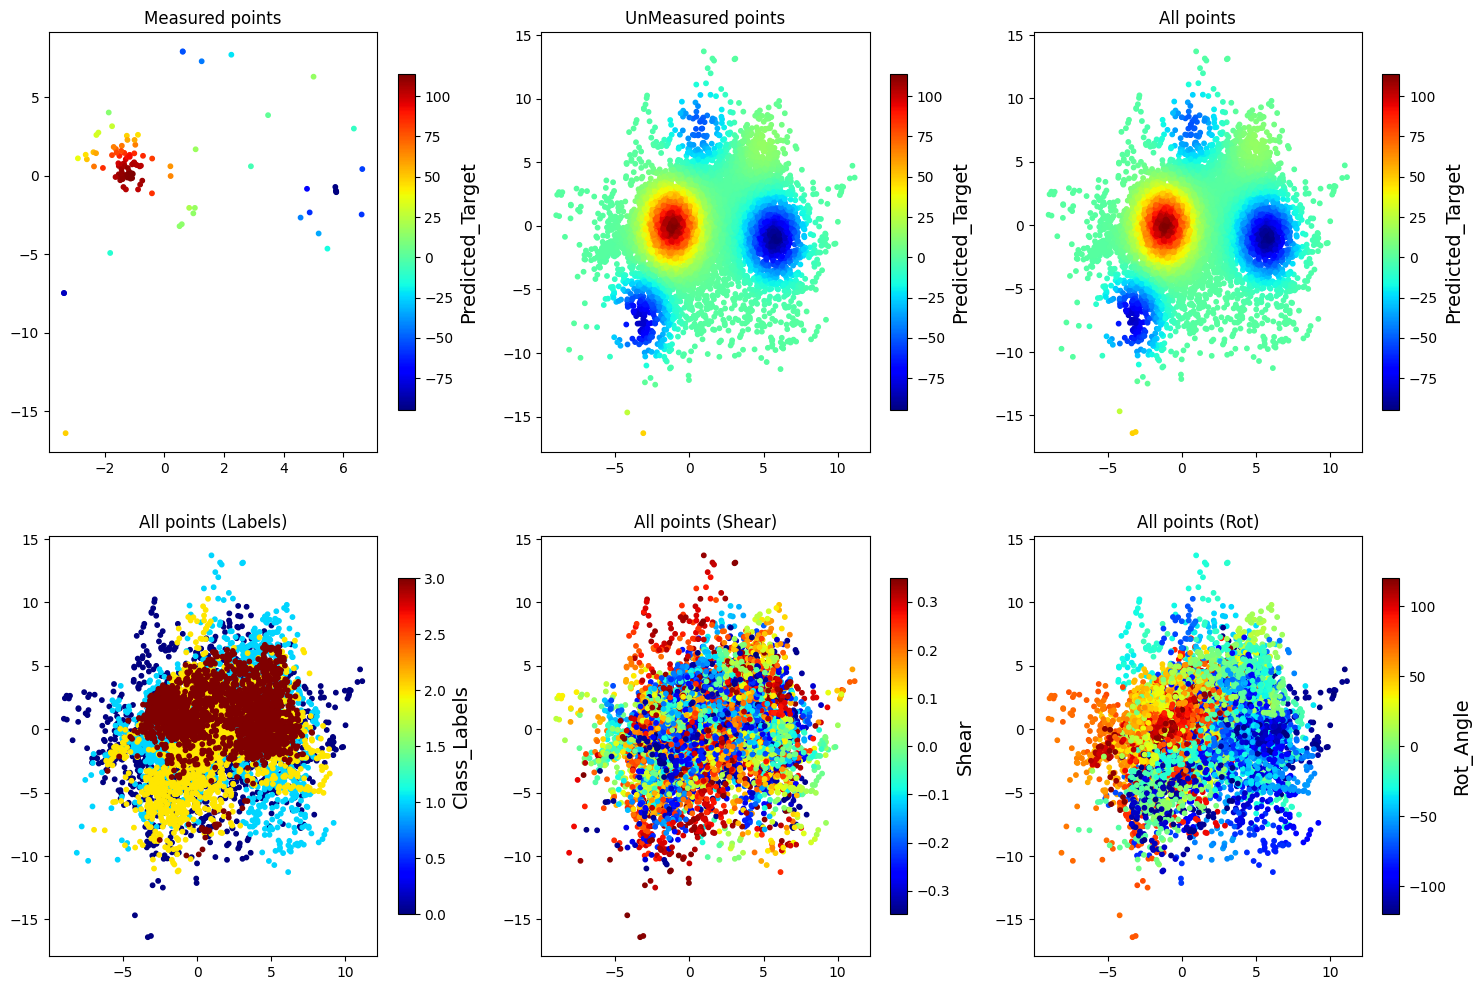

In [69]:
embeded_train6 = dkl_BO_6.embed(X6_train)  # Measured points
embeded_unmeasured6 = dkl_BO_6.embed(X6_unmeasured)  # Unmeasured points
embeded16 = dkl_BO_6.embed(X6)   # All points

fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (18,12))

im = ax[0,0].scatter(embeded_train6[:, 1], embeded_train6[:, 0], s=10, c = predmean_train6, cmap = 'jet')
ax[0,0].set_title('Measured points')
cbar = fig.colorbar(im, ax=ax[0,0], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,1].scatter(embeded_unmeasured6[:, 1], embeded_unmeasured6[:, 0], s=10,
                c = predmean_unmeas6, cmap = 'jet')
ax[0,1].set_title('UnMeasured points')
cbar = fig.colorbar(im, ax=ax[0,1], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,2].scatter(embeded16[:, 1], embeded16[:, 0], s=10, c = predmean16, cmap = 'jet')
ax[0,2].set_title('All points')
cbar = fig.colorbar(im, ax=ax[0,2], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,0].scatter(embeded16[:, 1], embeded16[:, 0], s=10, c = labels_all, cmap = 'jet')
ax[1,0].set_title('All points (Labels)')
cbar = fig.colorbar(im, ax=ax[1,0], shrink=.8)
cbar.set_label("Class_Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,1].scatter(embeded16[:, 1], embeded16[:, 0], s=10, c = shears_all[:,0], cmap = 'jet')
ax[1,1].set_title('All points (Shear)')
cbar = fig.colorbar(im, ax=ax[1,1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,2].scatter(embeded16[:, 1], embeded16[:, 0], s=10, c = angles_all, cmap = 'jet')
ax[1,2].set_title('All points (Rot)')
cbar = fig.colorbar(im, ax=ax[1,2], shrink=.8)
cbar.set_label("Rot_Angle", fontsize=14)
cbar.ax.tick_params(labelsize=10)